# Time Series Analysis of Algiers Temperature Data (2002-2023)

## Abstract
This project analyzes daily temperature data from Algiers spanning from 2002 to 2023. Using time series analysis techniques, specifically SARIMA modeling, we identify patterns, trends, and seasonal components in the temperature data. The goal is to develop a model that accurately captures the temperature dynamics and can be used for forecasting future temperatures in Algiers.

## Introduction
Temperature patterns are crucial for understanding climate dynamics, planning energy consumption, agriculture, and various other sectors. Algiers, the capital city of Algeria, has a Mediterranean climate with hot, dry summers and mild, wet winters. By analyzing historical temperature data from 2002 to 2023, we can identify long-term trends, seasonal patterns, and potentially detect any climate change signals. This analysis will help in understanding the temperature dynamics in Algiers and provide a basis for future temperature predictions.

In [ ]:
# Install required packages
install.packages(c("ggplot2", "forecast", "TSA", "tseries", "dplyr",
                   "knitr", "gridExtra", "MASS", "lawstat",
                   "FinTS", "ggthemes"))

Installing packages into ‘/home/lyes/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Warning message:
“package ‘MASS’ is not available for this version of R
‘MASS’ version 7.3-65 is in the repositories but depends on R (>= 4.4.0)
‘MASS’ version 7.3-65 is in the repositories but depends on R (>= 4.6)
‘MASS’ version 7.3-65 is in the repositories but depends on R (>= 4.5)

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


In [2]:
# Define the plot size
options(repr.plot.width = 24, repr.plot.height = 12)

In [3]:
# Load required libraries
library(ggplot2)
library(forecast)
library(tseries)
library(TSA)
library(dplyr)
library(gridExtra)
library(knitr)
library(MASS)
library(lawstat) # For runs test
library(FinTS)   # For ARCH test

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'TSA':
  method       from    
  fitted.Arima forecast
  plot.Arima   forecast


Attaching package: ‘TSA’


The following objects are masked from ‘package:stats’:

    acf, arima


The following object is masked from ‘package:utils’:

    tar



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘lawstat’


The following object is masked from ‘package:tseries’:

    runs.test


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

  

# ==========================================
# 1. DATA LOADING AND EXPLORATION
# ==========================================

In [4]:
# Load the temperature data
temp_data <- read.csv("../data/algiers_temp.csv")

In [5]:
# Convert the Date column to Date format
temp_data$time <- as.Date(temp_data$time)

In [6]:
# Display the first few rows
cat("First 5 rows of data:\n")
print(head(temp_data, 5))

First 5 rows of data:
        time temperature
1 2002-01-01        12.2
2 2002-01-02        12.2
3 2002-01-03        12.0
4 2002-01-04        10.2
5 2002-01-05        10.6


In [7]:
# Display basic information about the dataset
cat("\nDataset info:\n")
str(temp_data)


Dataset info:
'data.frame':	7913 obs. of  2 variables:
 $ time       : Date, format: "2002-01-01" "2002-01-02" ...
 $ temperature: num  12.2 12.2 12 10.2 10.6 9.9 8 7.8 9 9.4 ...


In [8]:
# Display summary statistics
cat("\nSummary statistics:\n")
print(summary(temp_data))


Summary statistics:
      time             temperature   
 Min.   :2002-01-01   Min.   : 2.00  
 1st Qu.:2007-06-02   1st Qu.:12.70  
 Median :2012-10-31   Median :17.20  
 Mean   :2012-10-31   Mean   :17.86  
 3rd Qu.:2018-04-01   3rd Qu.:23.30  
 Max.   :2023-08-31   Max.   :36.70  


In [9]:
# Calculate some additional statistics to understand the data better
cat("\nAdditional statistics:\n")
cat("Total number of observations:", nrow(temp_data), "\n")
cat("Date range:", min(temp_data$time), "to", max(temp_data$time), "\n")
cat("Temperature range:", min(temp_data$temperature), "to", max(temp_data$temperature), "°C\n")

# Check for missing values
missing_values <- sum(is.na(temp_data$temperature))
cat("Missing values in temperature:", missing_values, "\n")


Additional statistics:
Total number of observations: 7913 
Date range: 11688 to 19600 
Temperature range: 2 to 36.7 °C
Missing values in temperature: 0 


In [10]:
# Create a proper time series object with daily frequency
temp_ts <- ts(temp_data$temperature, frequency = 365.25)


# ==========================================
# 2. TIME SERIES VISUALIZATION
# ==========================================

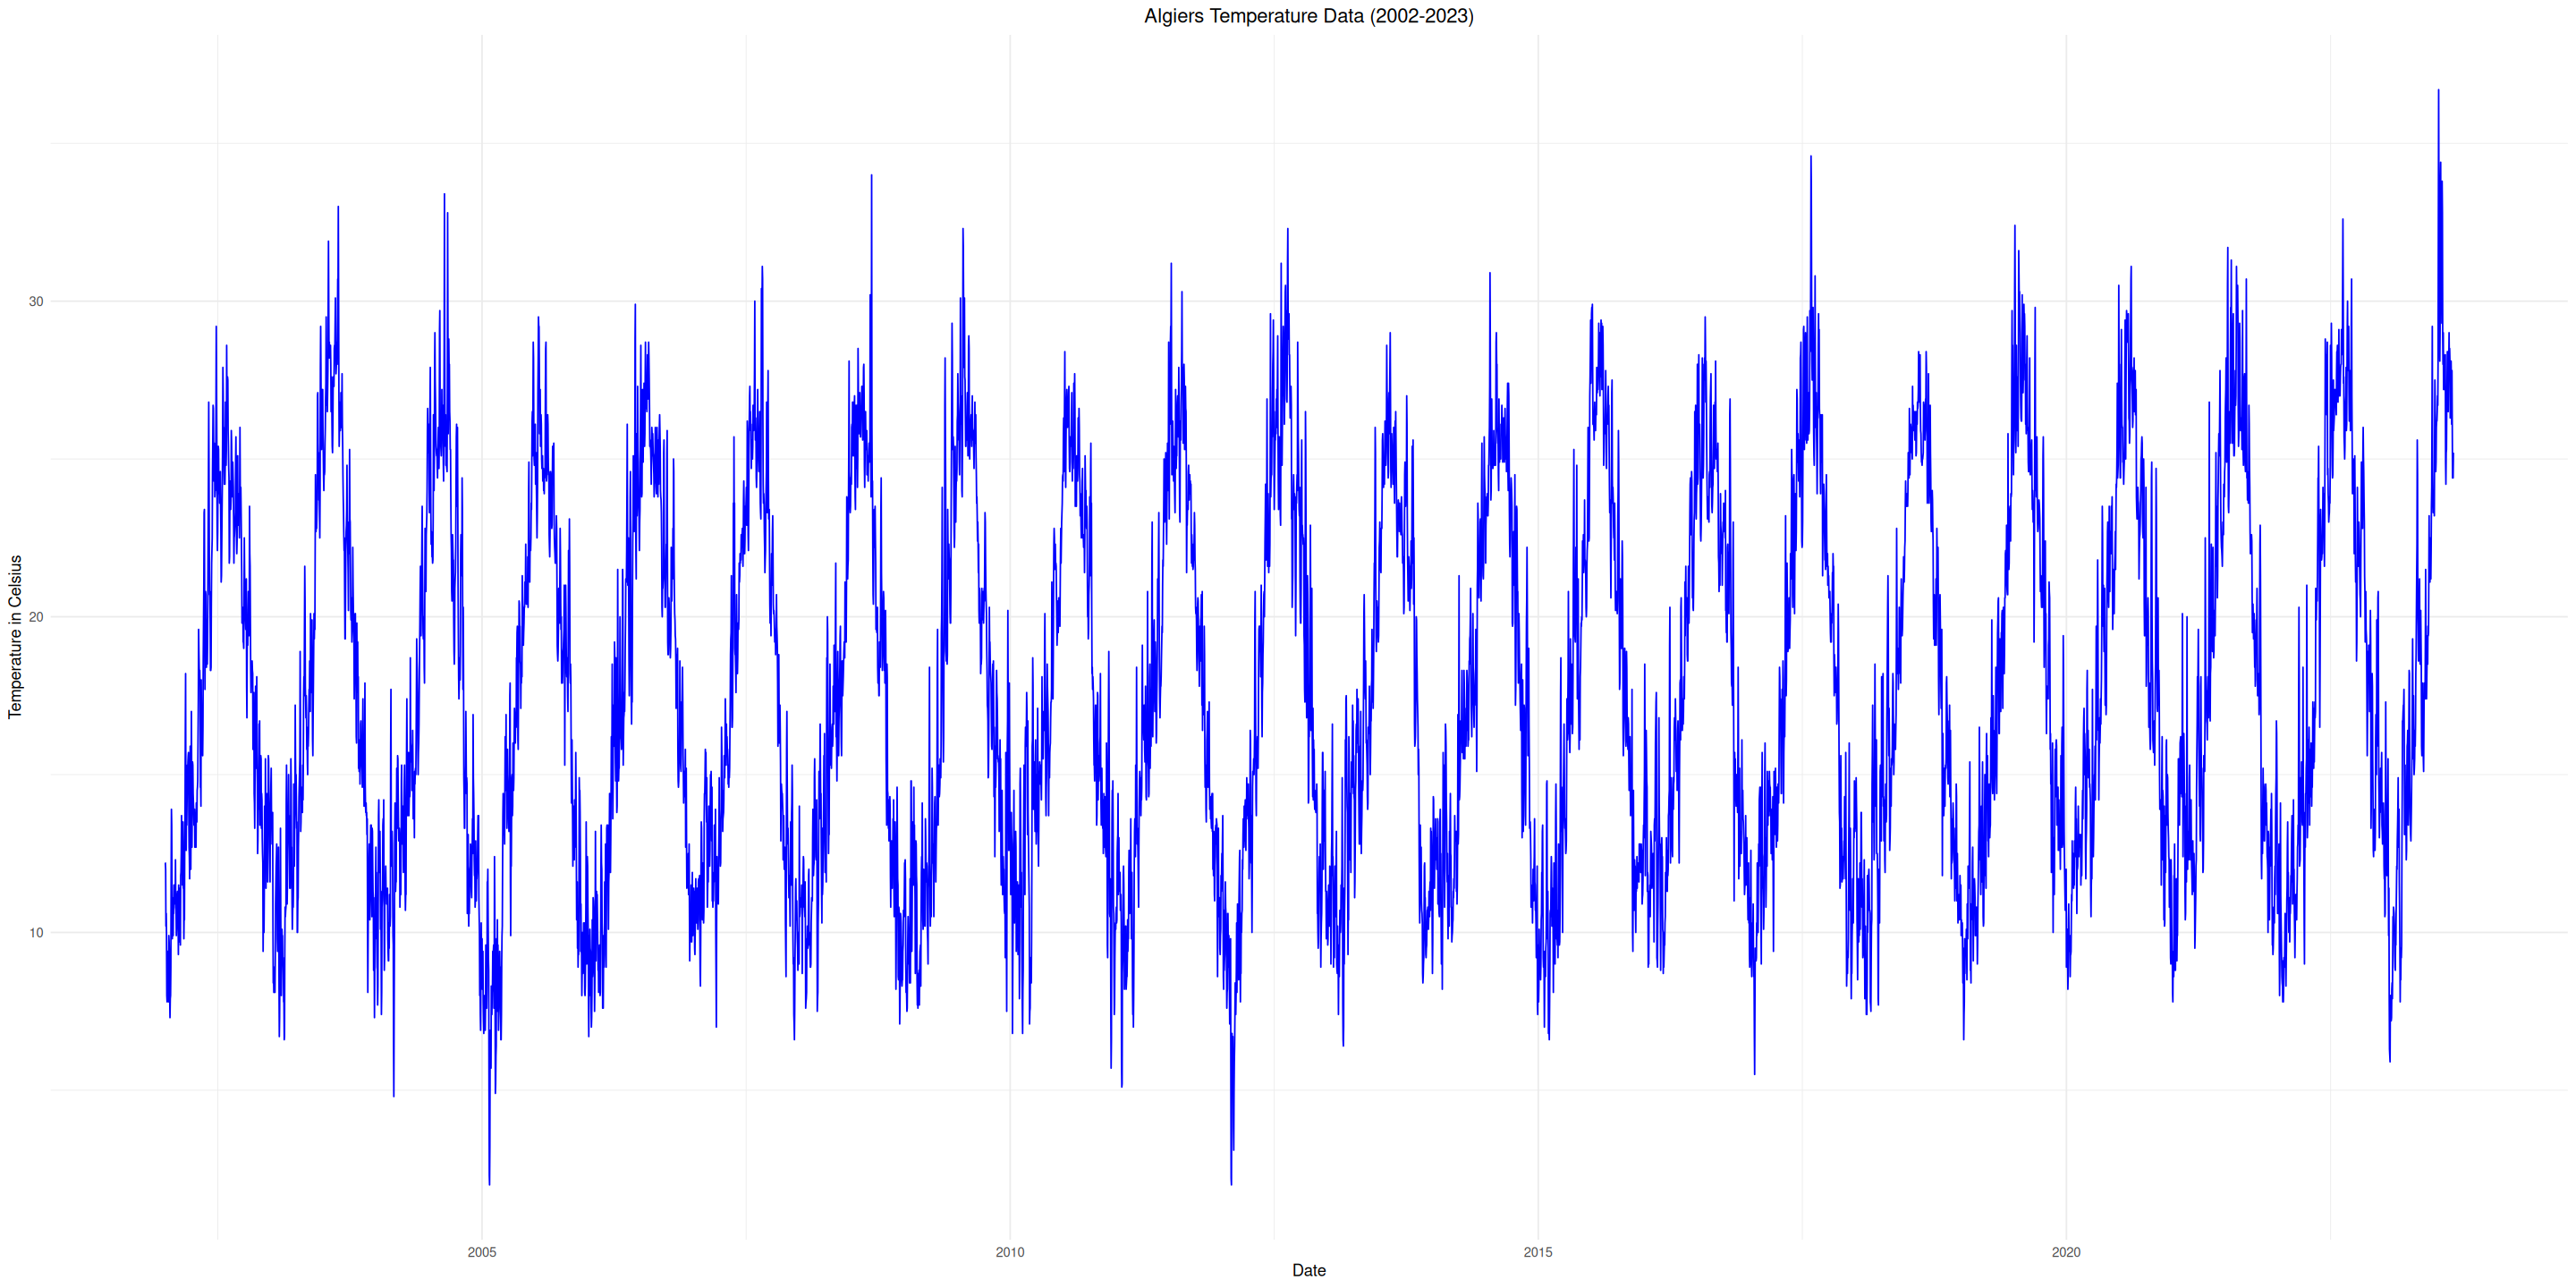

In [11]:
# Plot the temperature data
p1 <- ggplot(temp_data, aes(x = time, y = temperature)) +
  geom_line(color = "blue") +
  labs(title = "Algiers Temperature Data (2002-2023)",
       x = "Date", y = "Temperature in Celsius") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))
print(p1)

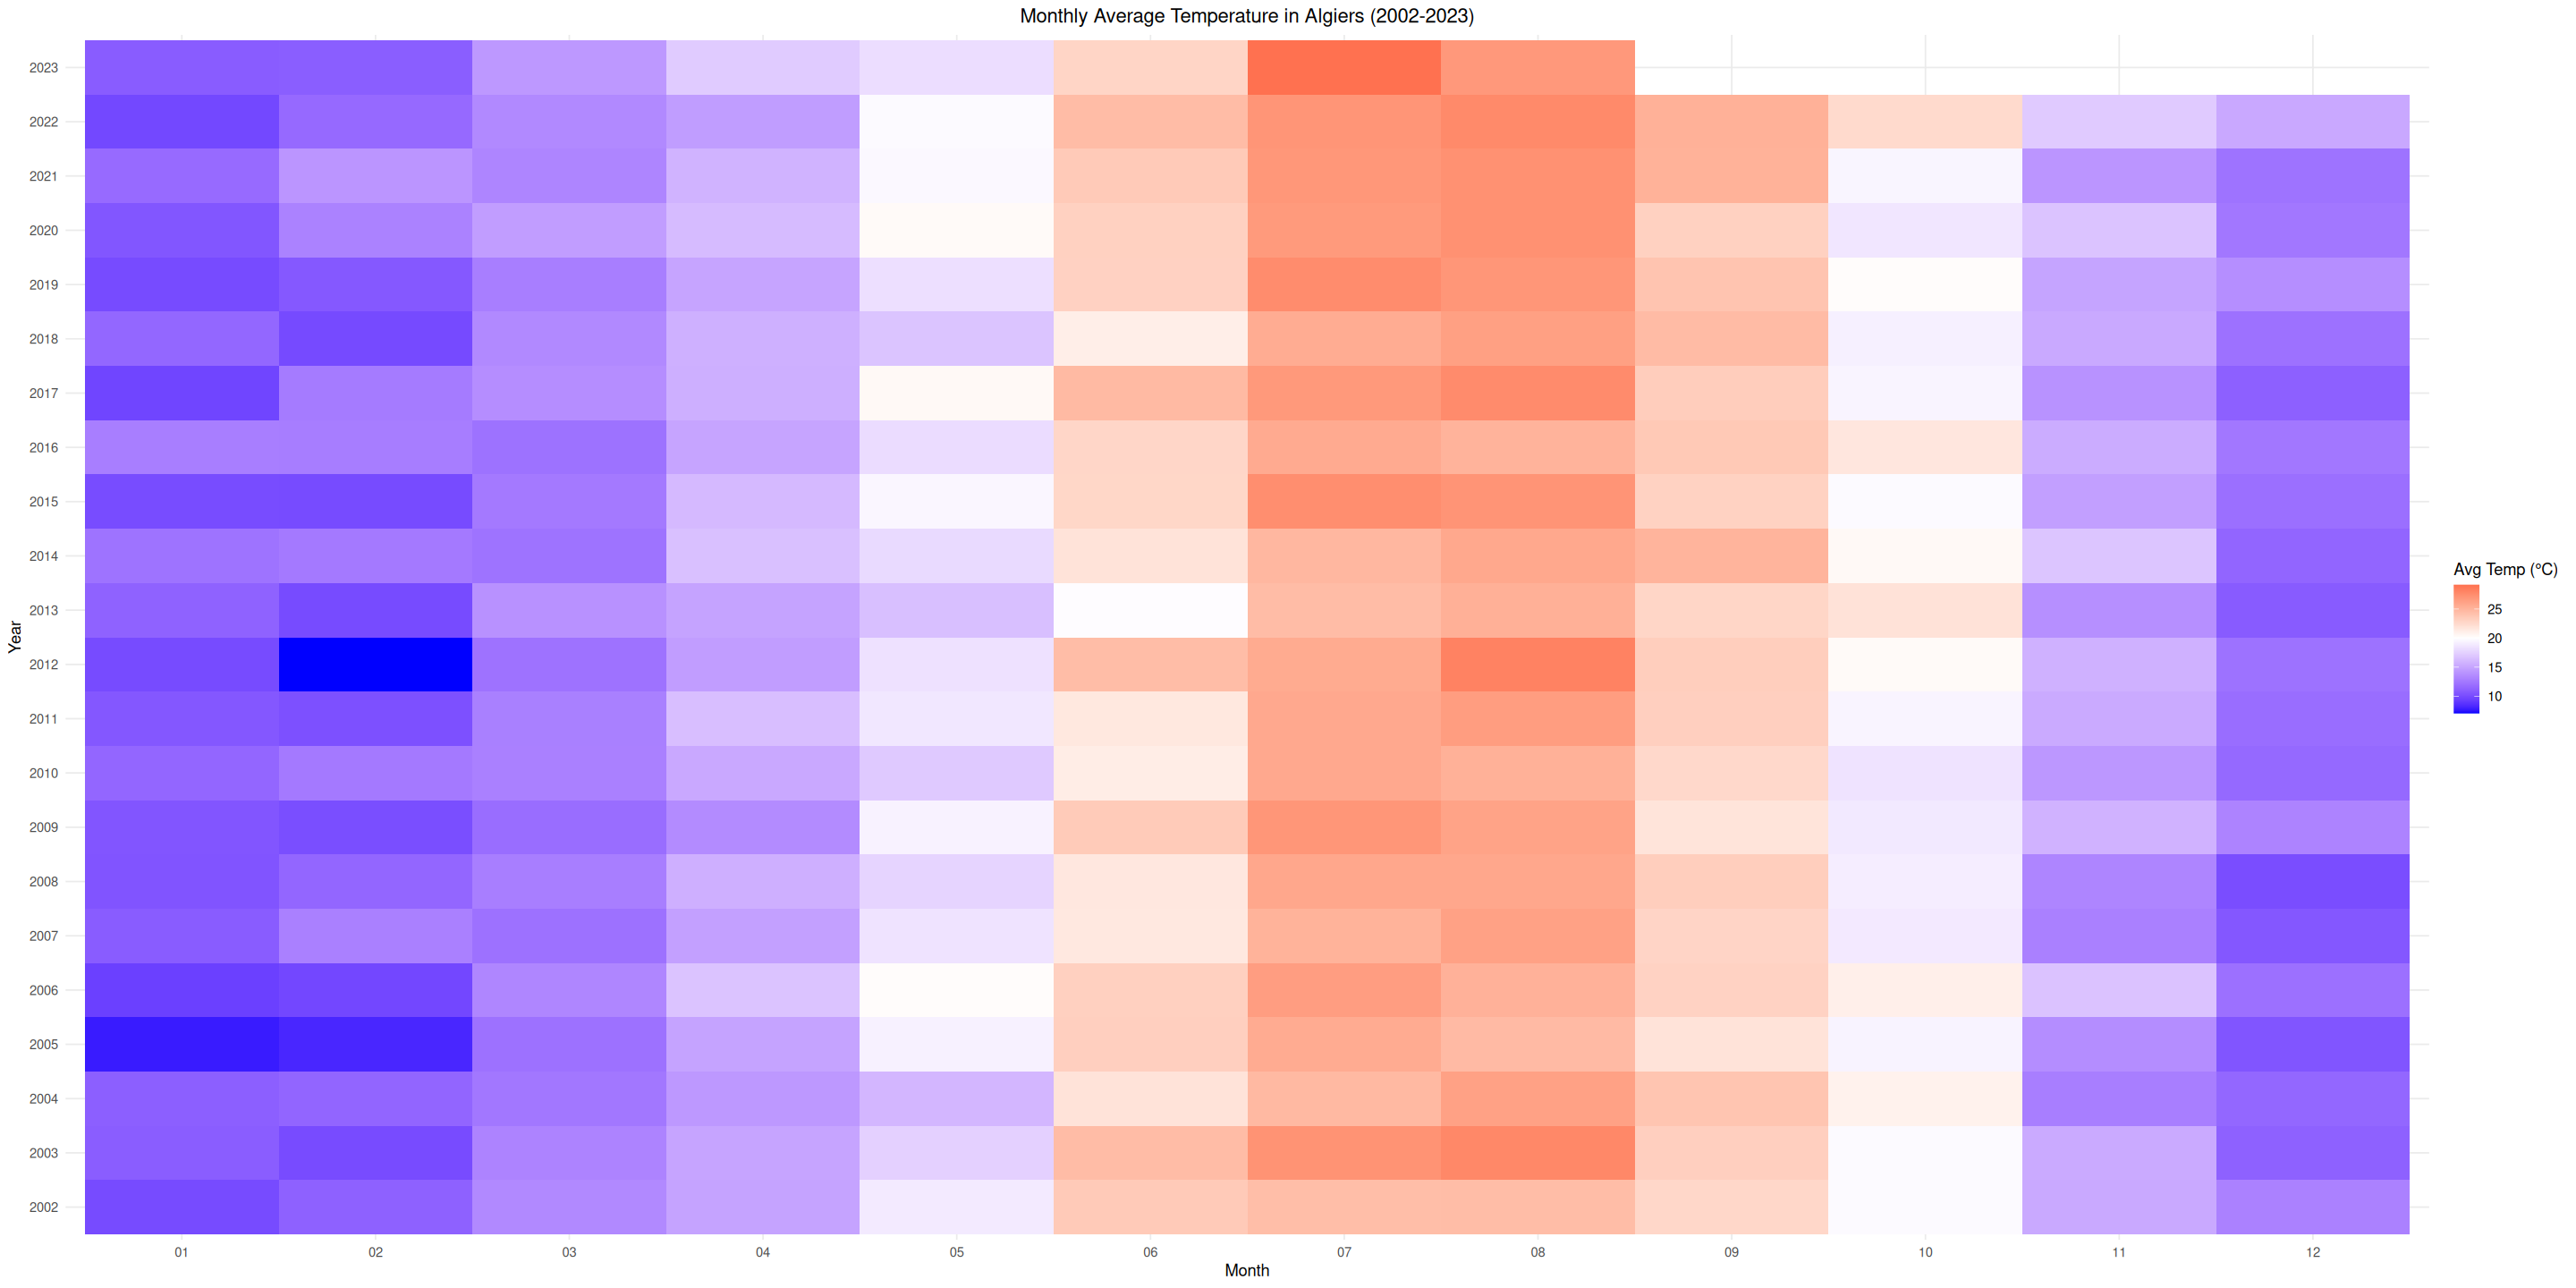

In [12]:
# Display annual and seasonal patterns using a month-year heatmap
temp_data$year <- format(temp_data$time, "%Y")
temp_data$month <- format(temp_data$time, "%m")

# Calculate monthly averages for each year
monthly_avg <- temp_data %>%
  group_by(year, month) %>%
  summarize(avg_temp = mean(temperature, na.rm = TRUE), .groups = 'drop')

# Create heatmap
ggplot(monthly_avg, aes(x = month, y = year, fill = avg_temp)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 20) +
  labs(title = "Monthly Average Temperature in Algiers (2002-2023)",
       x = "Month", y = "Year", fill = "Avg Temp (°C)") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

In [13]:
# Convert to monthly data for better seasonal analysis
monthly_temps <- aggregate(temperature ~ format(time, "%Y-%m"), temp_data, mean)
names(monthly_temps) <- c("yearmonth", "temperature")


In [14]:
# Convert to time series object
monthly_temp_ts <- ts(monthly_temps$temperature, frequency = 12, 
                      start = c(2002, 1))

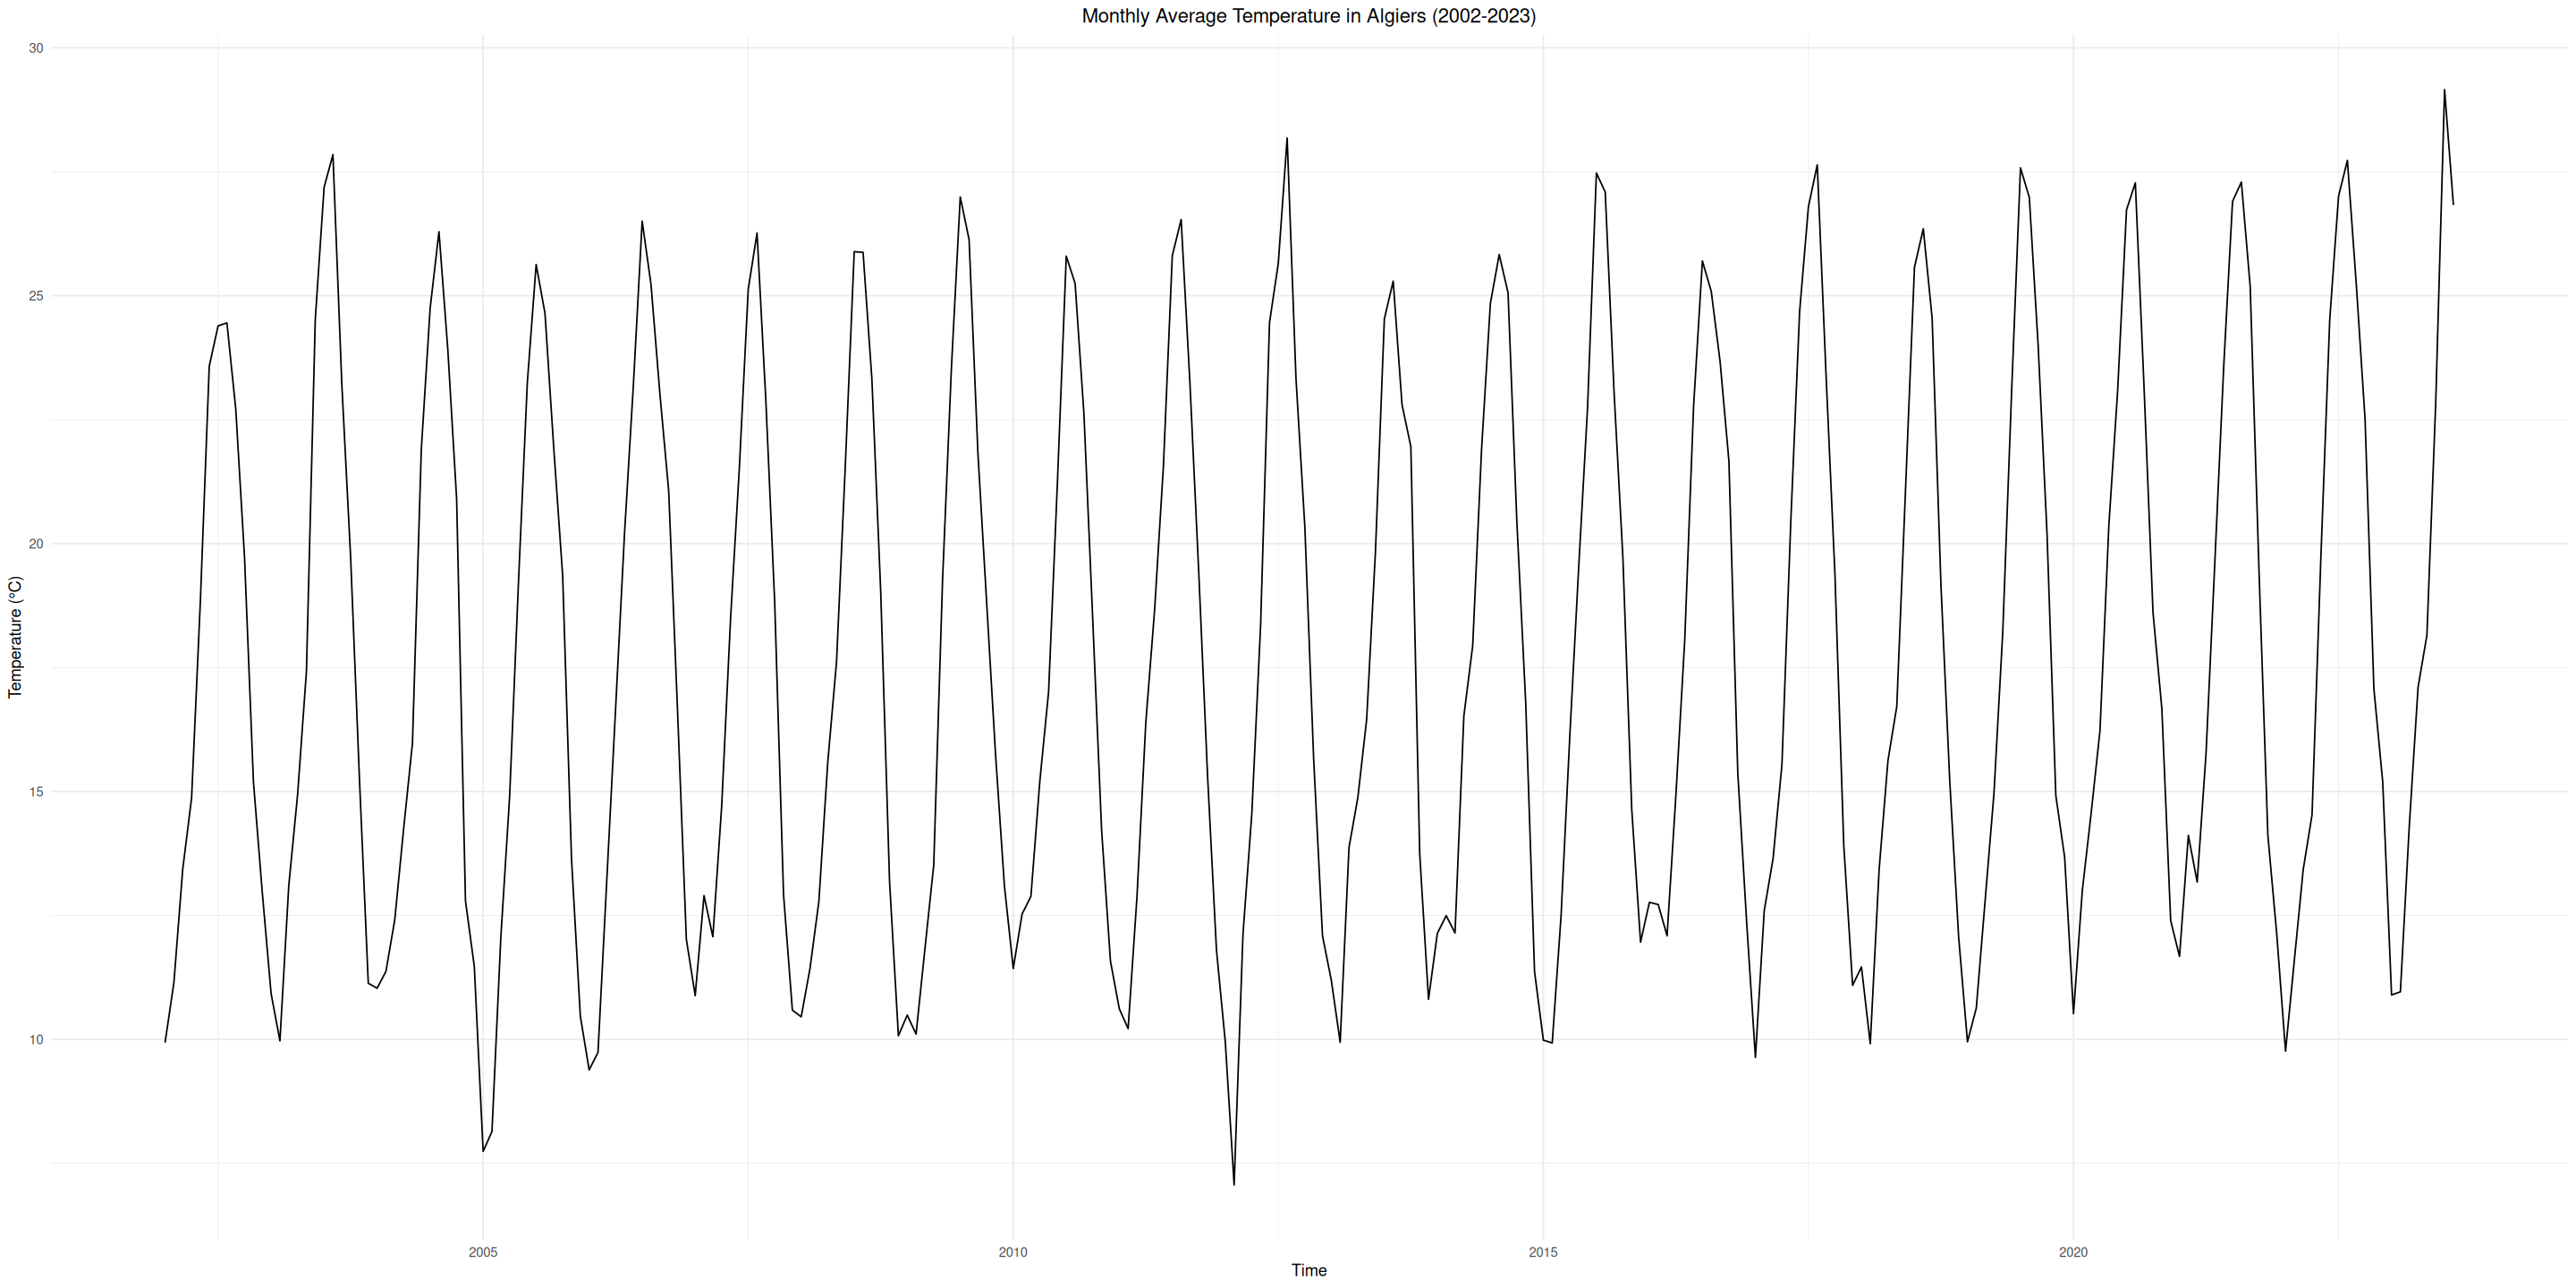

In [15]:
# Plot the monthly time series
autoplot(monthly_temp_ts) +
  labs(title = "Monthly Average Temperature in Algiers (2002-2023)",
       x = "Time", y = "Temperature (°C)") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

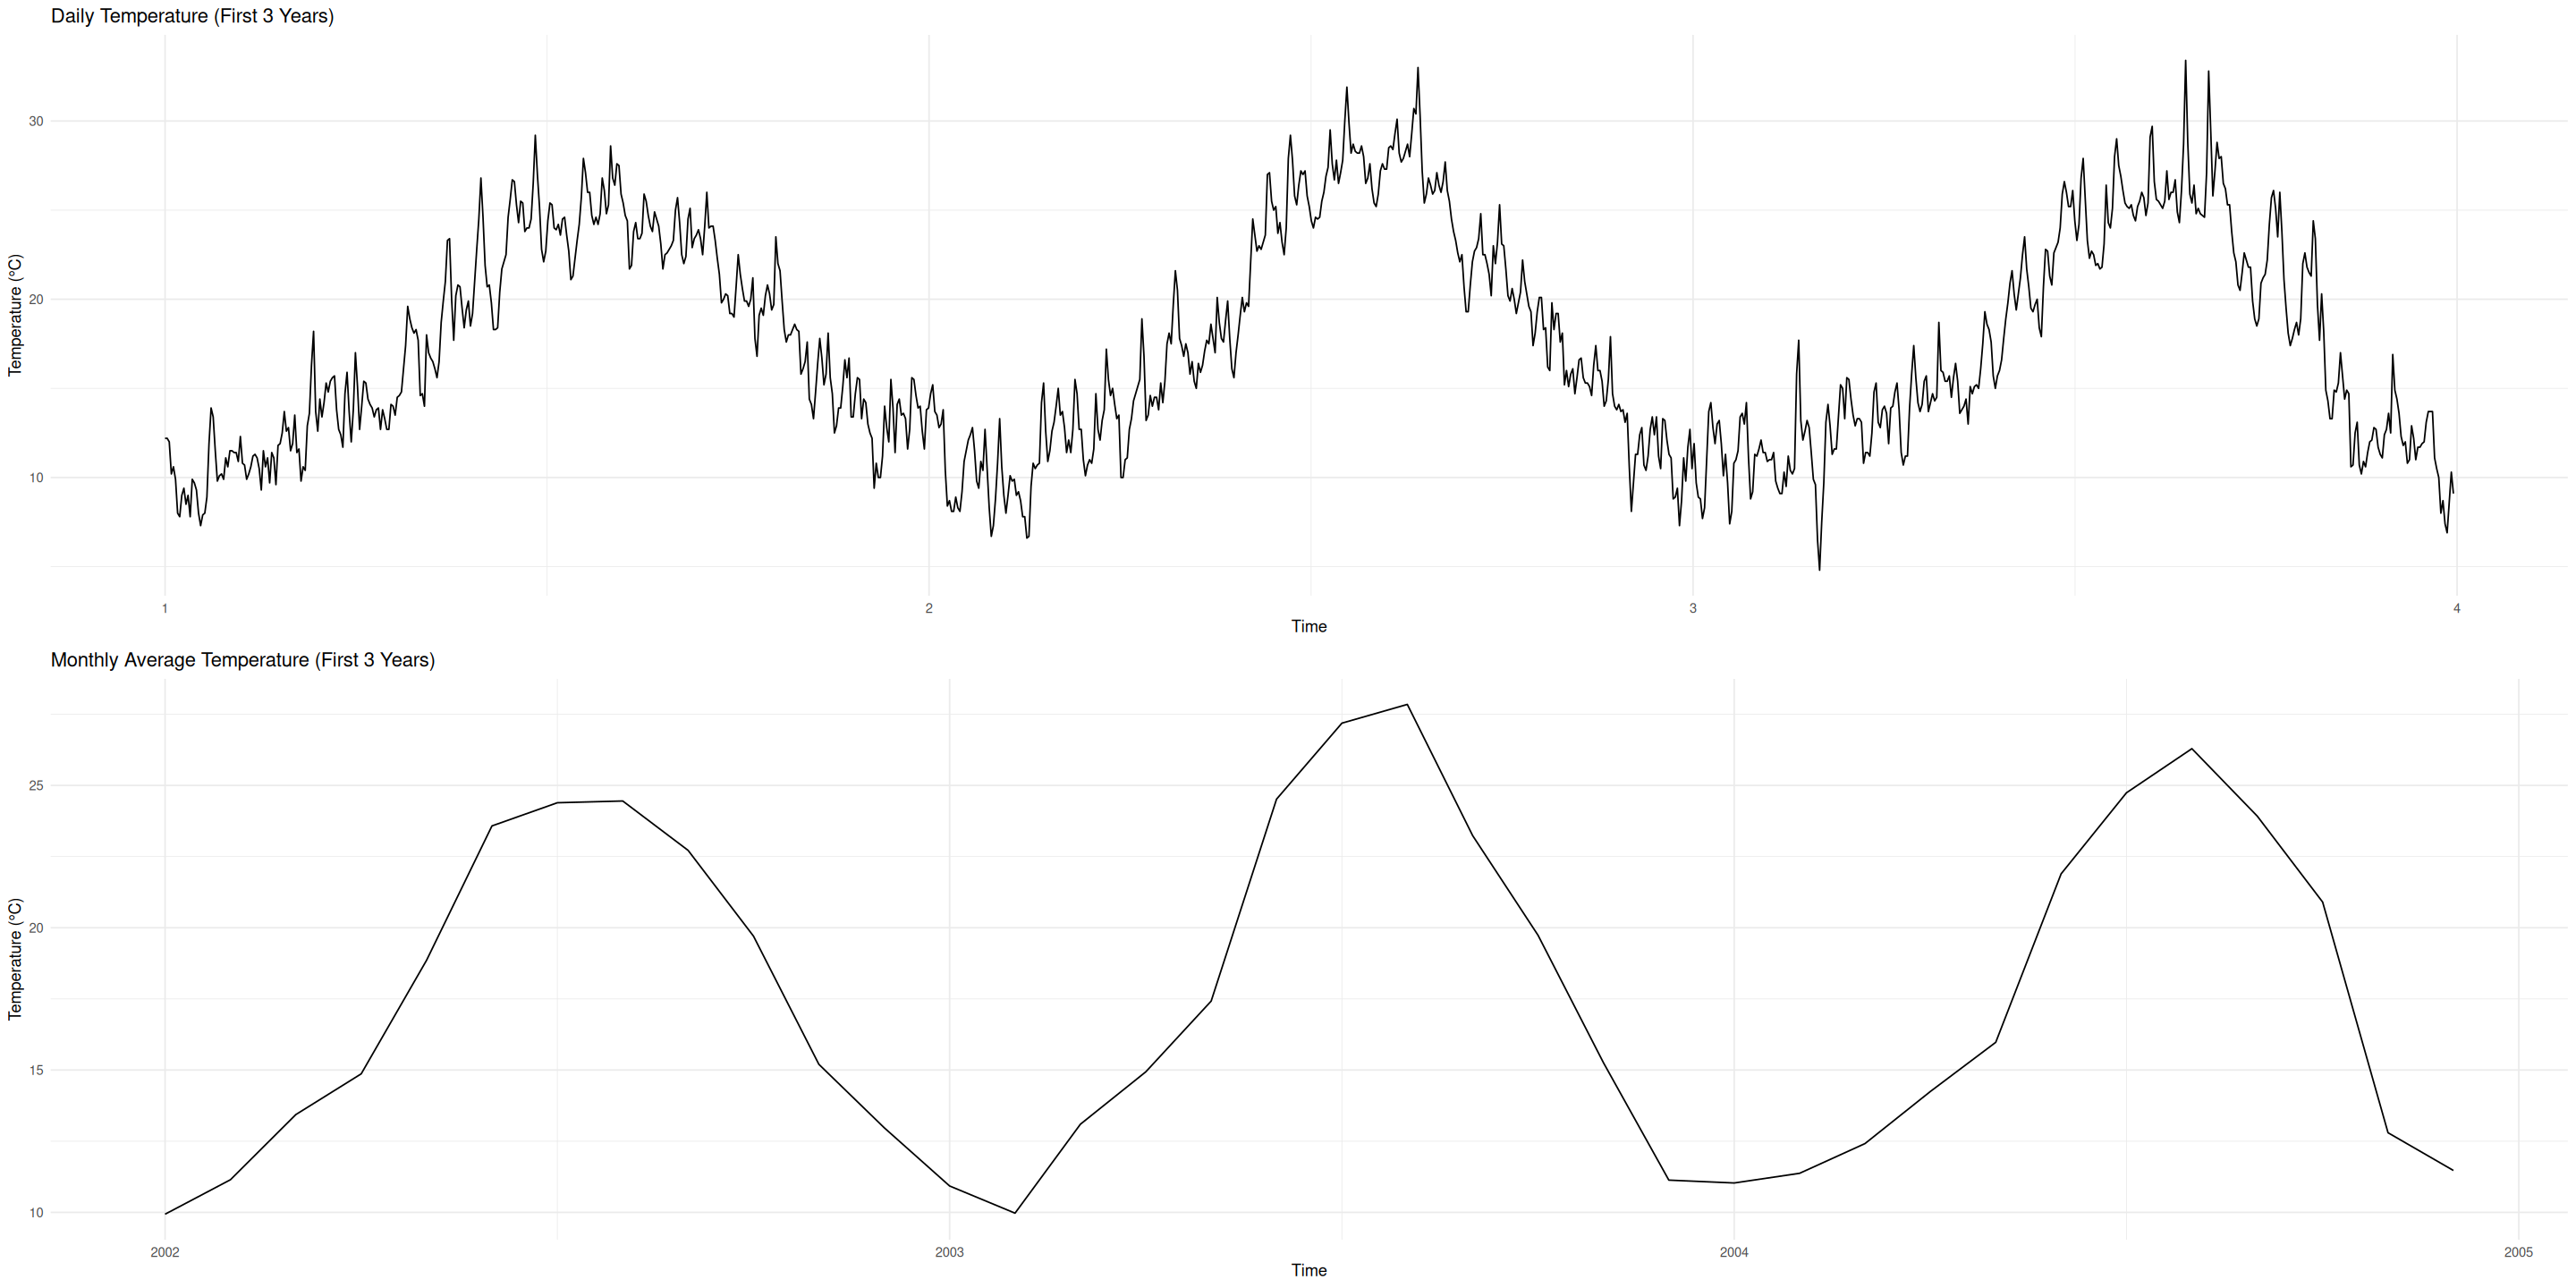

In [16]:
# Comparison of daily vs monthly data visualization - fixed version
# Extract the first 3 years of data for visualization
daily_subset <- head(temp_ts, 365 * 3)  # First ~3 years of daily data
monthly_subset <- head(monthly_temp_ts, 12 * 3)  # First 3 years of monthly data

p_daily <- autoplot(daily_subset) +
  labs(title = "Daily Temperature (First 3 Years)",
       x = "Time", y = "Temperature (°C)") +
  theme_minimal()

p_monthly <- autoplot(monthly_subset) +
  labs(title = "Monthly Average Temperature (First 3 Years)",
       x = "Time", y = "Temperature (°C)") +
  theme_minimal()

grid.arrange(p_daily, p_monthly, ncol = 1)

Based on the visualizations above, I've decided to focus on monthly data for this analysis as it clearly shows the seasonal patterns while reducing noise. The monthly aggregation makes the patterns more interpretable and is better suited for SARIMA modeling with seasonal components.

In [17]:
# Perform decomposition
decomp_monthly <- decompose(monthly_temp_ts)

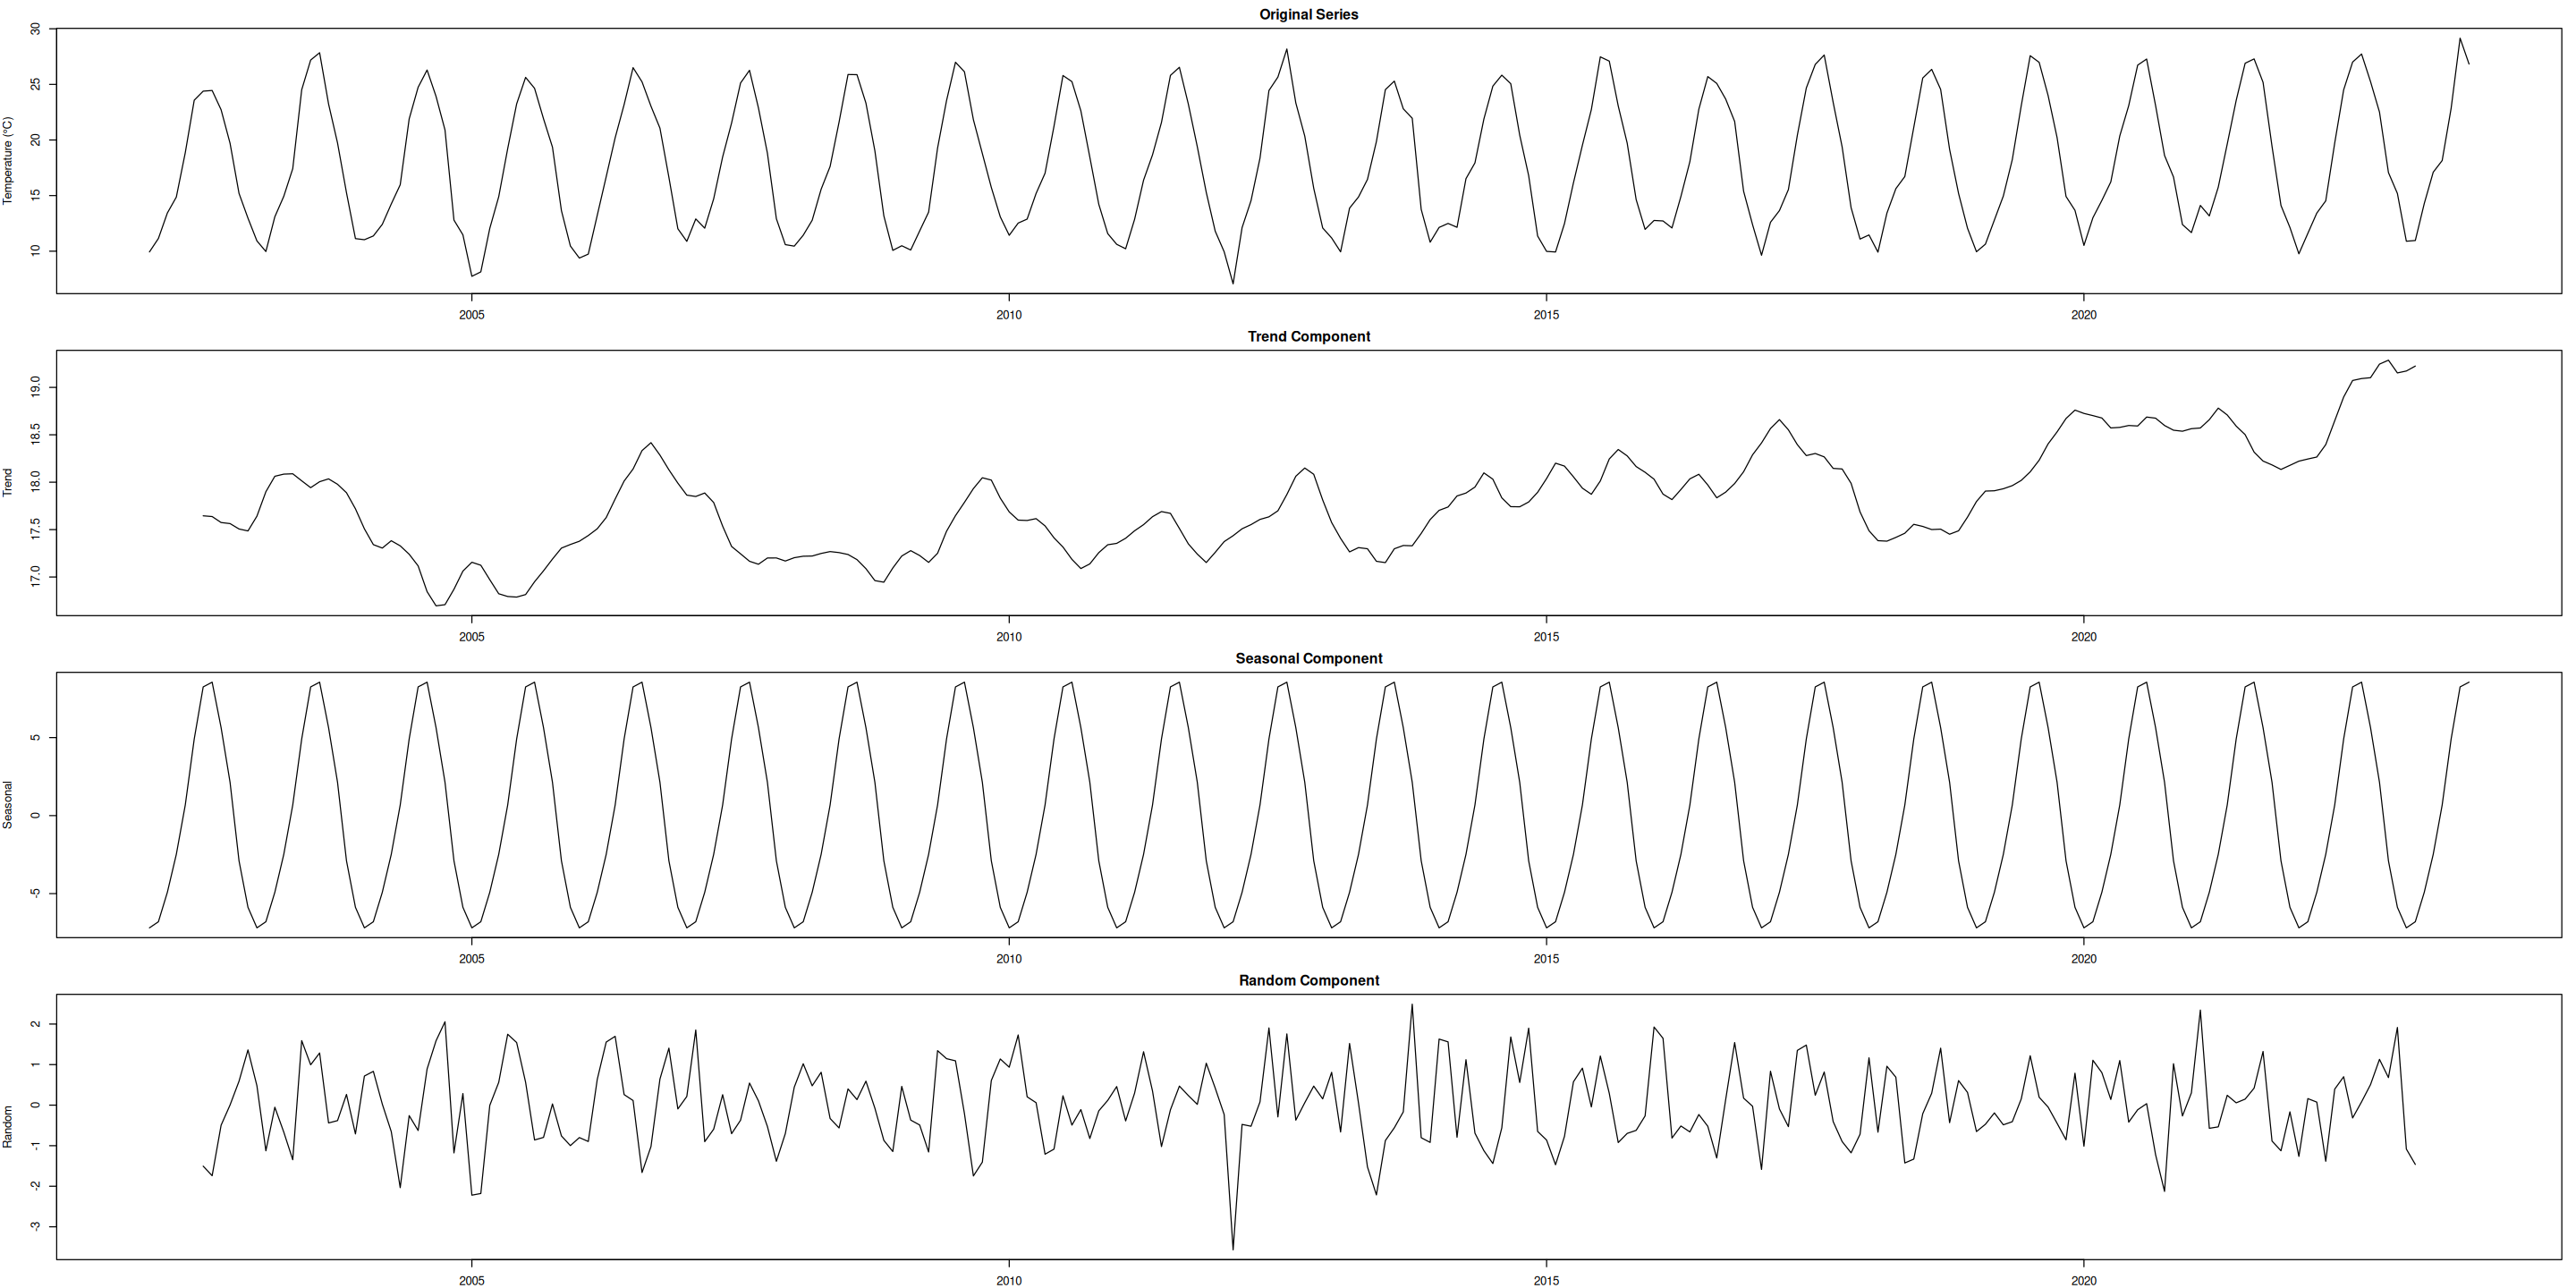

In [18]:
# Create separate plots for each component
par(bg = "white")
par(mfrow = c(4, 1), mar = c(2, 4, 2, 1))
plot(monthly_temp_ts, main = "Original Series", ylab = "Temperature (°C)")
plot(decomp_monthly$trend, main = "Trend Component", ylab = "Trend")
plot(decomp_monthly$seasonal, main = "Seasonal Component", ylab = "Seasonal")
plot(decomp_monthly$random, main = "Random Component", ylab = "Random")
par(mfrow = c(1, 1))

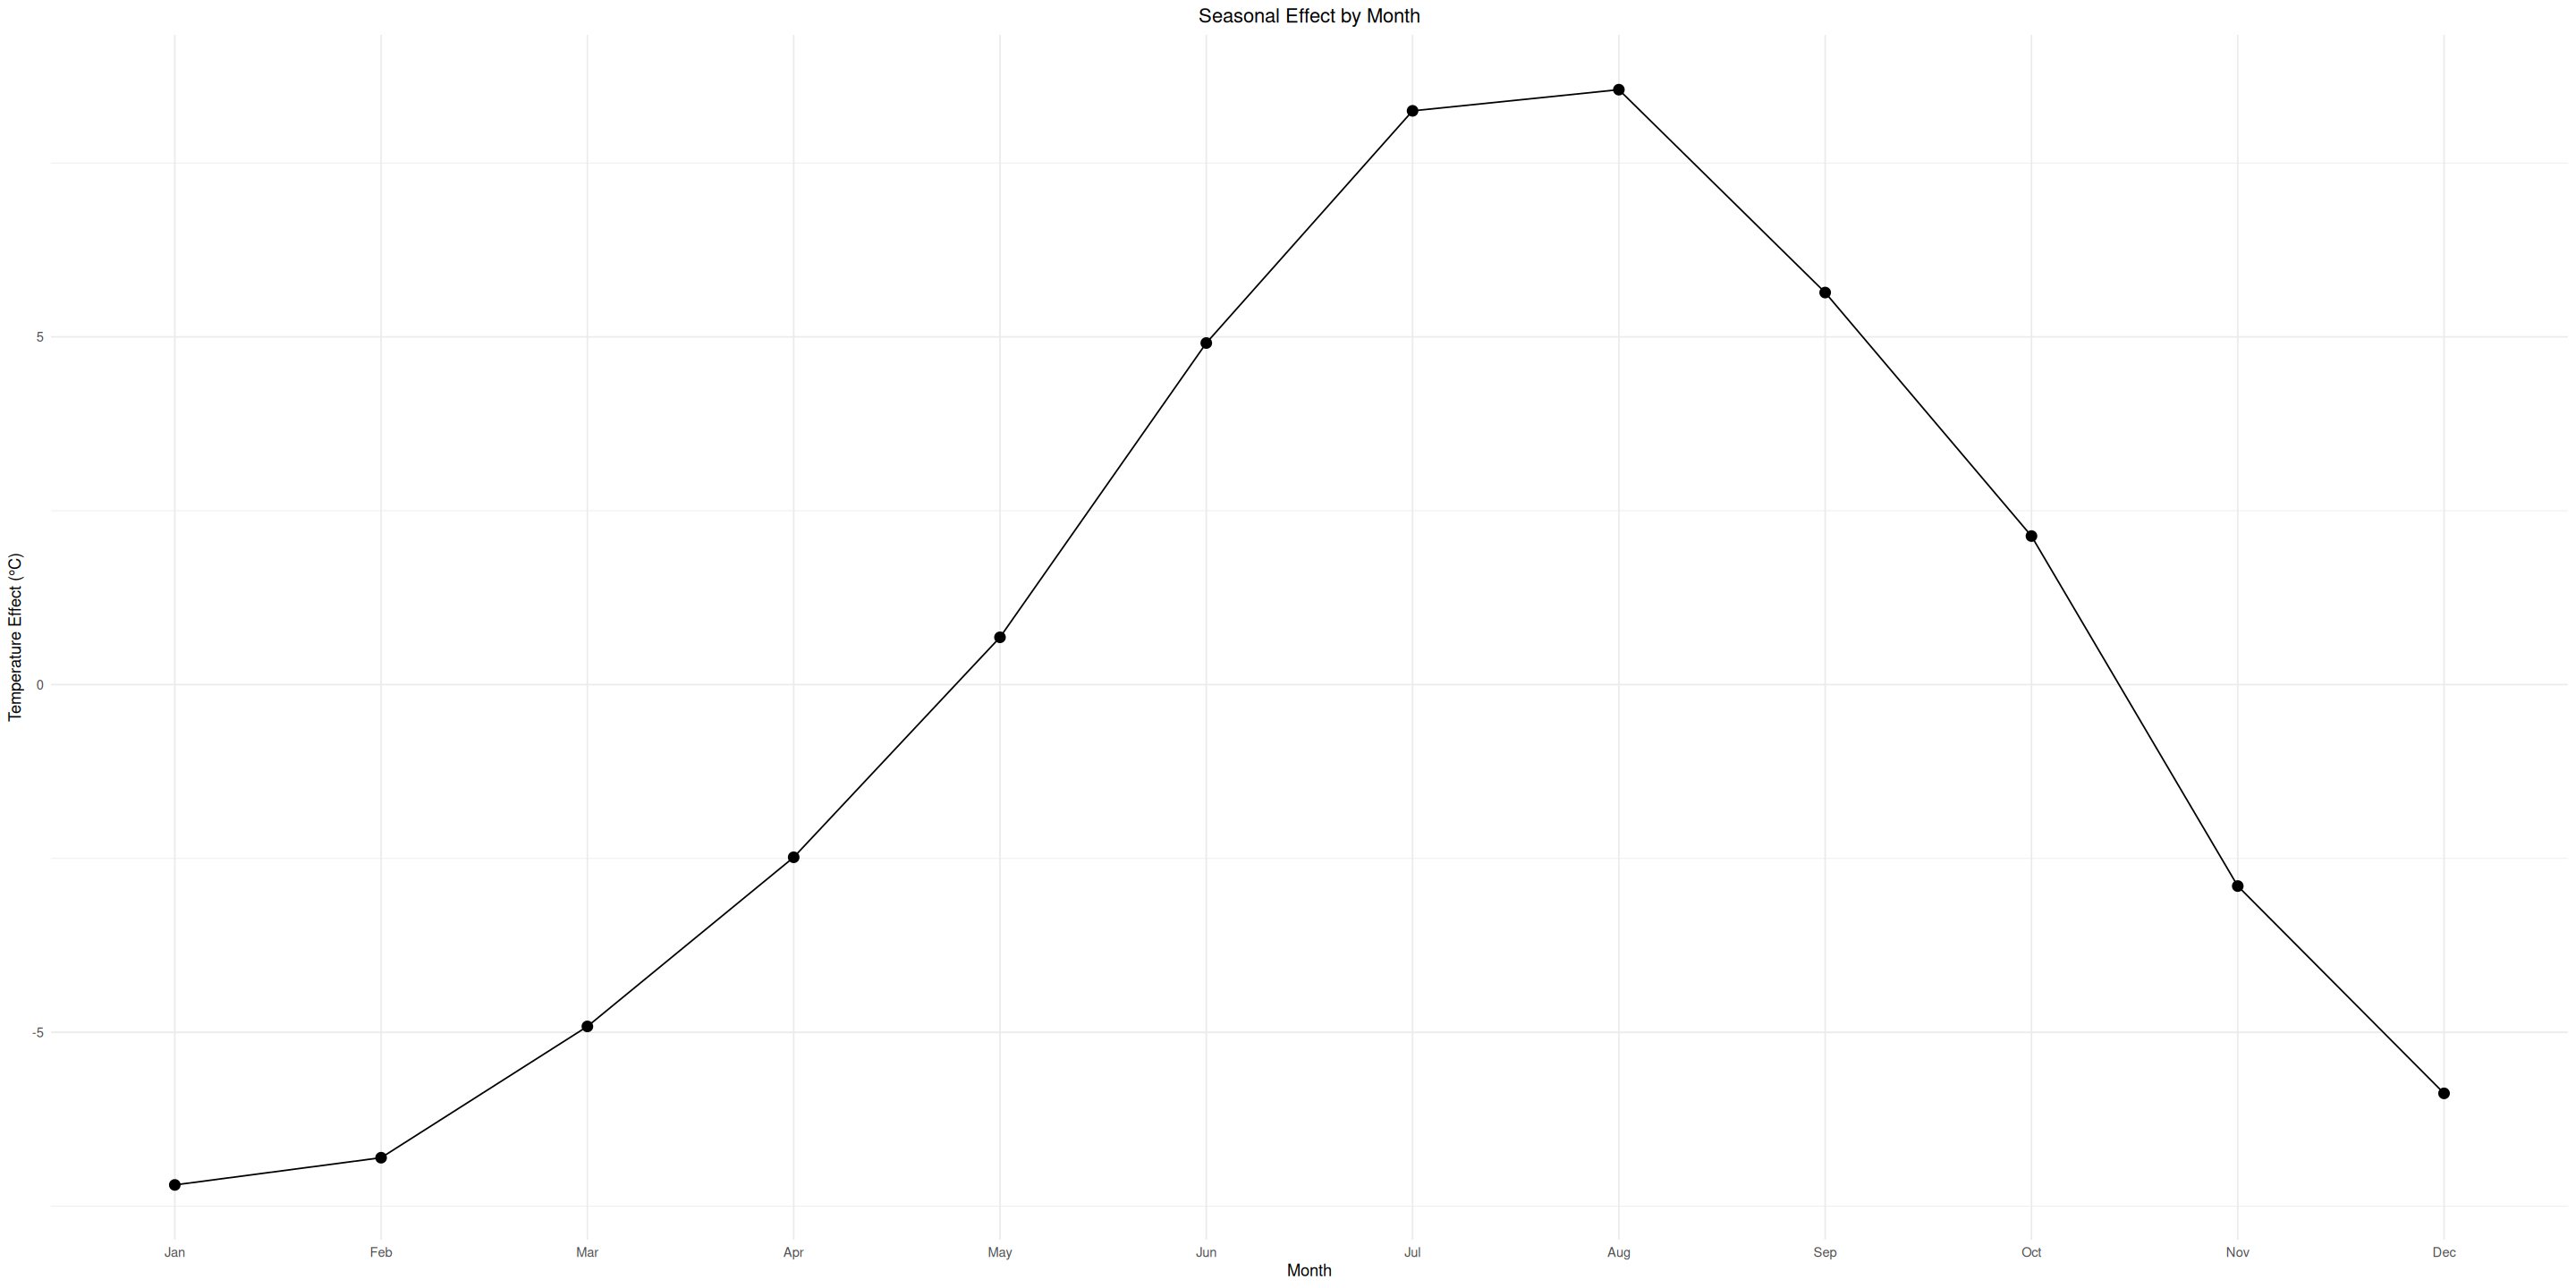

In [19]:
# Plot the seasonal component to examine the monthly pattern
seasonal_df <- data.frame(
  Month = 1:12,
  Seasonal_Effect = decomp_monthly$seasonal[1:12]
)

# Month names for better visualization
month_names <- c("Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                 "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")
seasonal_df$MonthName <- factor(month_names, levels = month_names)

ggplot(seasonal_df, aes(x = MonthName, y = Seasonal_Effect, group = 1)) +
  geom_line() +
  geom_point(size = 3) +
  labs(title = "Seasonal Effect by Month",
       x = "Month",
       y = "Temperature Effect (°C)") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

# ==========================================
# 3. STATIONARITY TESTING
# ==========================================

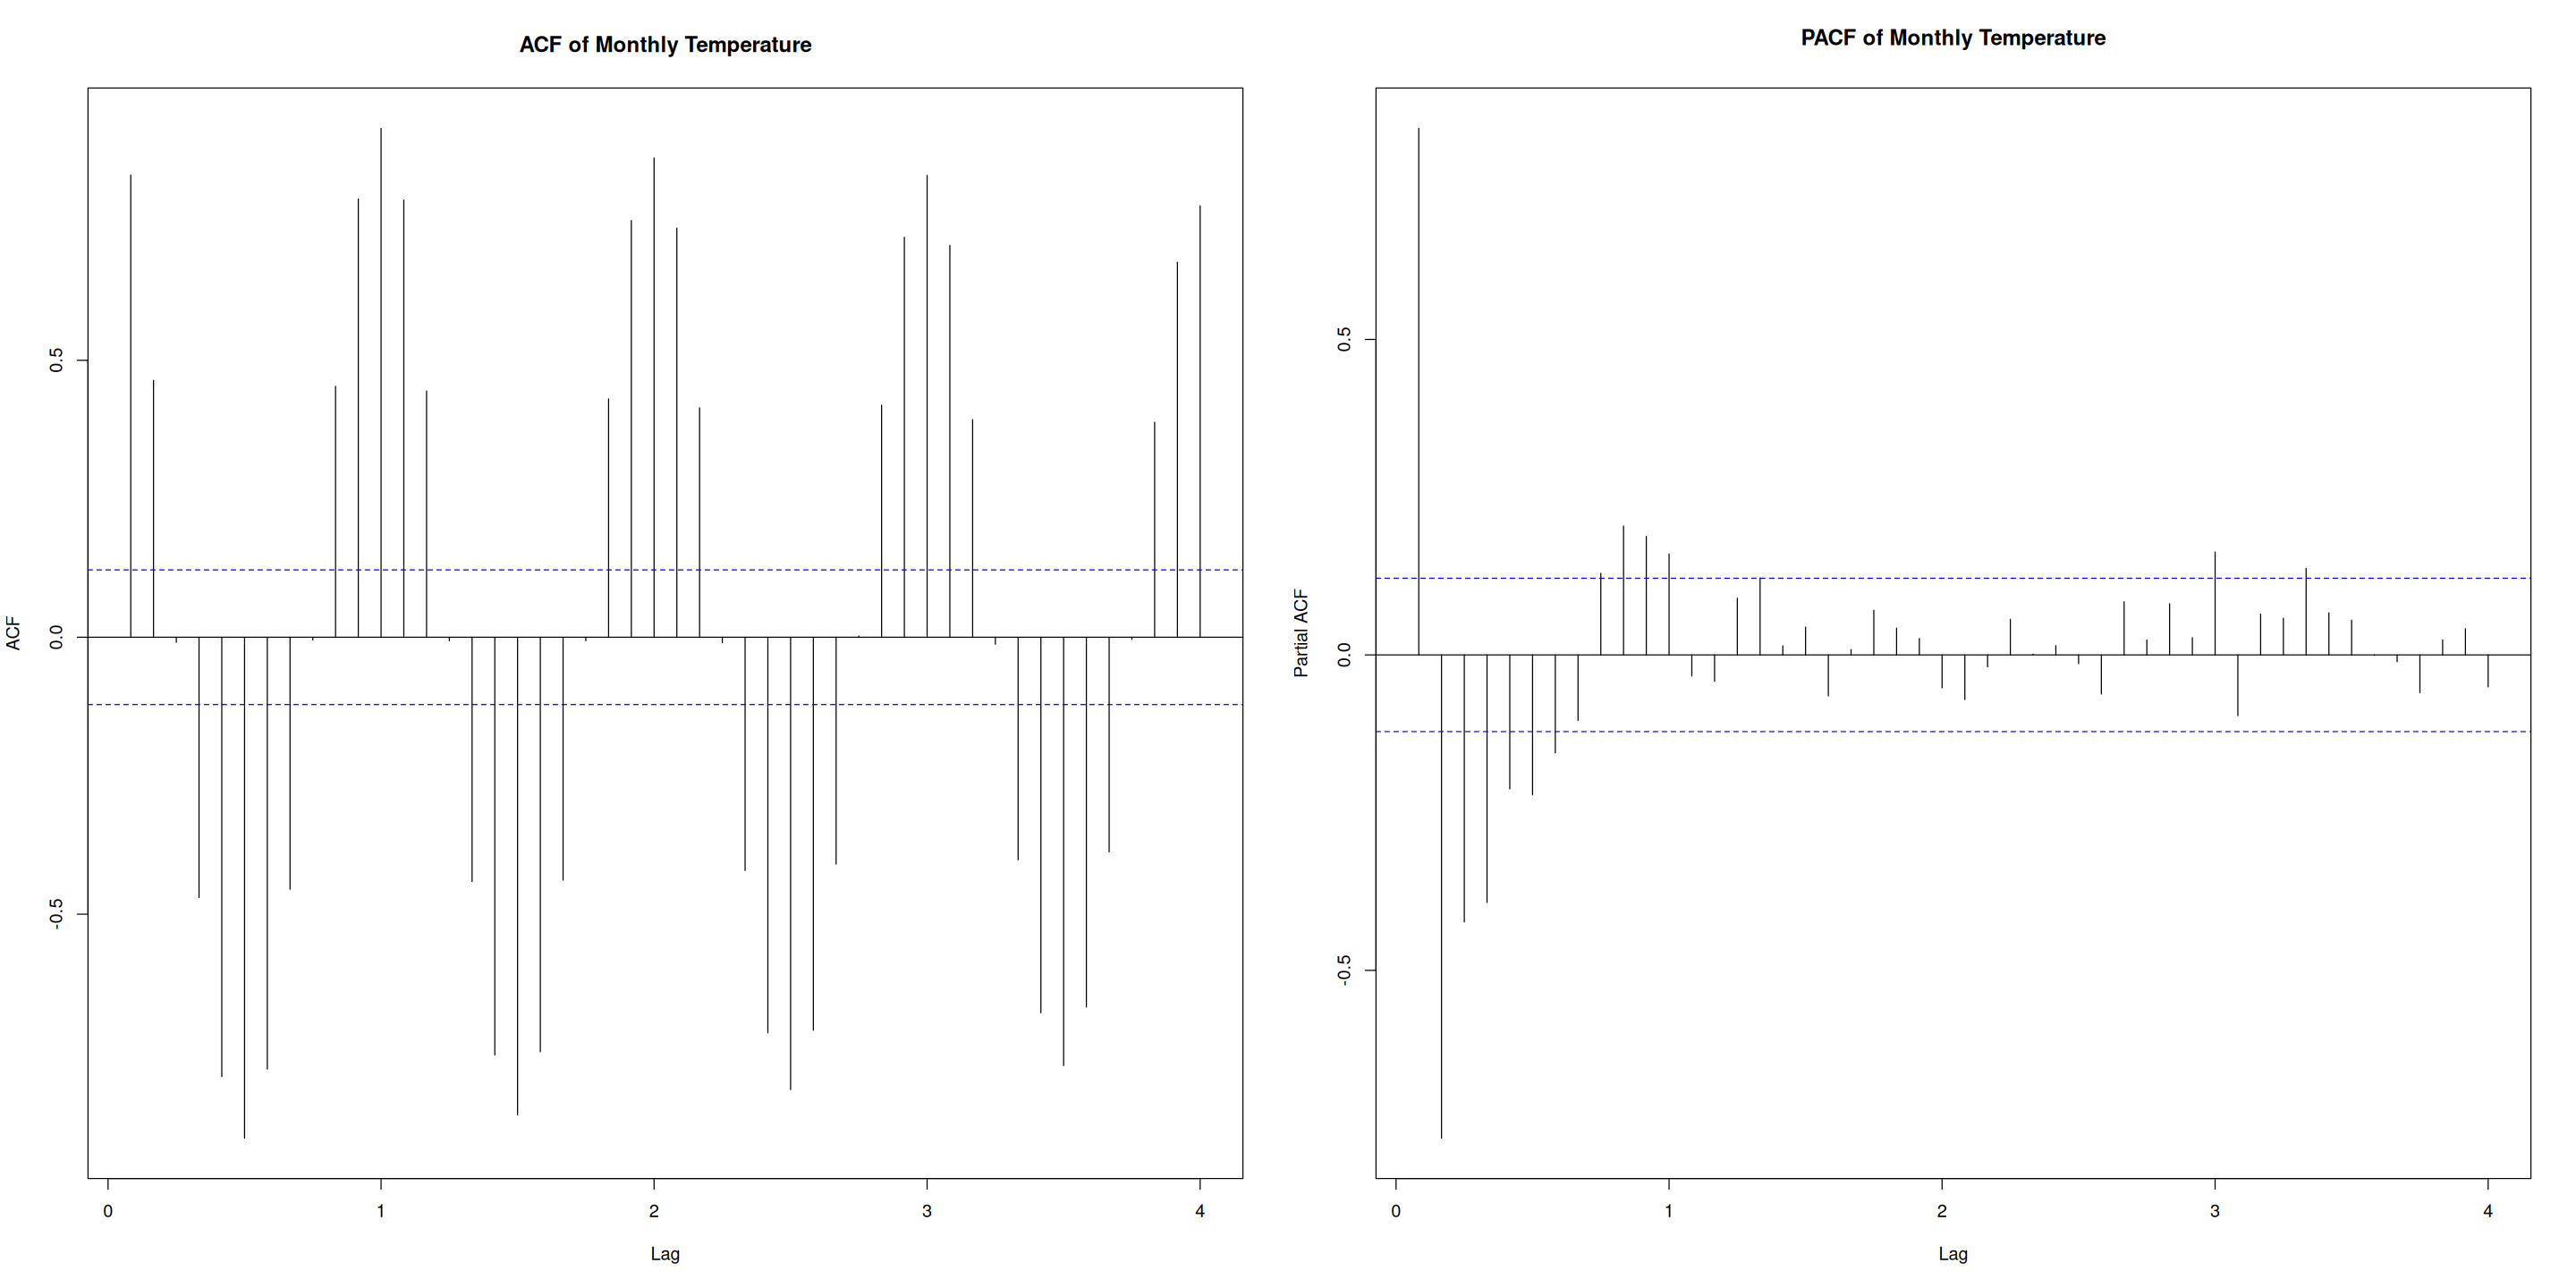

In [20]:
# Check for stationarity visually with ACF and PACF plots for monthly data
par(bg = "white")
par(mfrow = c(1, 2))
acf(monthly_temp_ts, main = "ACF of Monthly Temperature", lag.max = 48)
pacf(monthly_temp_ts, main = "PACF of Monthly Temperature", lag.max = 48)
par(mfrow = c(1, 1))

In [21]:
# Formal stationarity test for monthly data
adf_test <- adf.test(monthly_temp_ts)
print("Augmented Dickey-Fuller Test for Stationarity (Monthly Data):")
print(adf_test)

Warning message in adf.test(monthly_temp_ts):
“p-value smaller than printed p-value”


[1] "Augmented Dickey-Fuller Test for Stationarity (Monthly Data):"

	Augmented Dickey-Fuller Test

data:  monthly_temp_ts
Dickey-Fuller = -14.21, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary



In [22]:
# KPSS test for stationarity (alternative test)
kpss_test <- kpss.test(monthly_temp_ts)
print("KPSS Test for Stationarity (Monthly Data):")
print(kpss_test)

Warning message in kpss.test(monthly_temp_ts):
“p-value greater than printed p-value”


[1] "KPSS Test for Stationarity (Monthly Data):"

	KPSS Test for Level Stationarity

data:  monthly_temp_ts
KPSS Level = 0.083766, Truncation lag parameter = 5, p-value = 0.1



In [23]:
# Conclusion on stationarity
if (adf_test$p.value >= 0.05) {
  cat("ADF test: The monthly series is NOT stationary (p >= 0.05)\n")
} else {
  cat("ADF test: The monthly series is stationary (p < 0.05)\n")
}

if (kpss_test$p.value < 0.05) {
  cat("KPSS test: The monthly series is NOT stationary (p < 0.05)\n")
} else {
  cat("KPSS test: The monthly series is stationary (p >= 0.05)\n")
}

ADF test: The monthly series is stationary (p < 0.05)
KPSS test: The monthly series is stationary (p >= 0.05)


# ==========================================
# 4. DATA TRANSFORMATIONS
# ==========================================

In [24]:
# Check if we need to stabilize variance
lambda <- BoxCox.lambda(monthly_temp_ts)
cat("\nOptimal lambda for Box-Cox transformation:", lambda, "\n")


Optimal lambda for Box-Cox transformation: 0.9259724 


Warning message:
“In lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...) :
 extra argument ‘main’ will be disregarded”


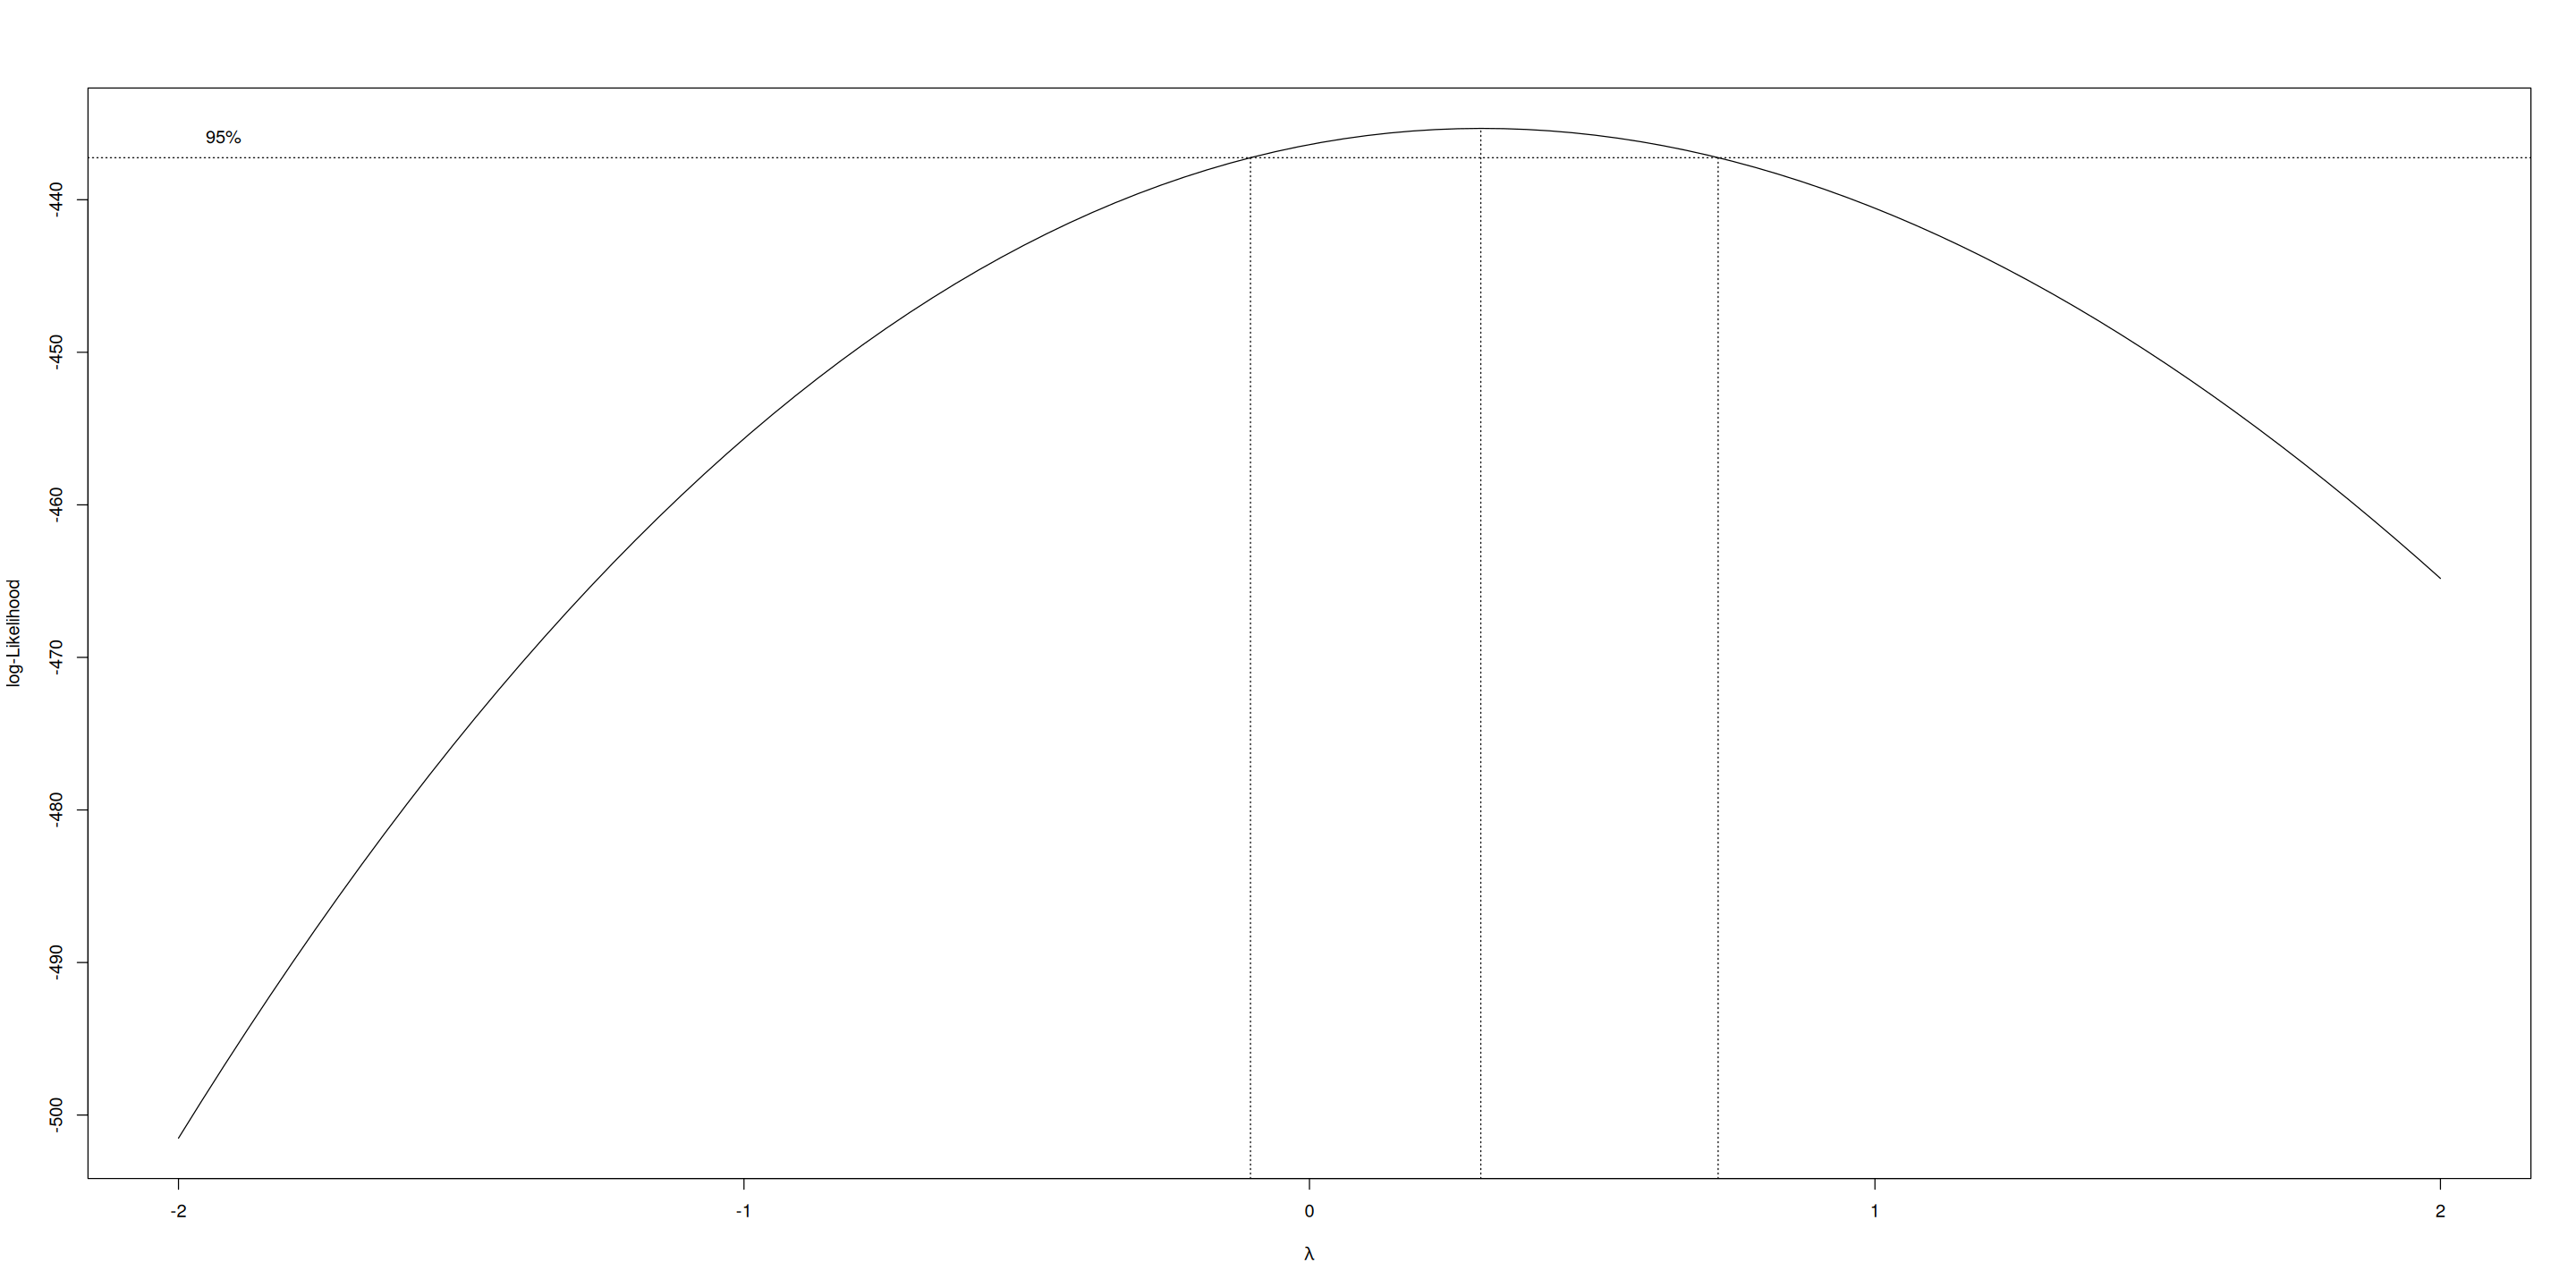

In [25]:
# Show Box-Cox transformation lambda selection plot
par(bg = "white")
boxcox(monthly_temp_ts ~ time(monthly_temp_ts),
       lambda = seq(-2, 2, by = 0.1),
       plotit = TRUE,
       main = "Box-Cox Transformation Parameter Selection")

In [26]:
# Apply Box-Cox transformation
temp_boxcox <- BoxCox(monthly_temp_ts, lambda)
cat("Box-Cox transformation applied with lambda =", lambda, "\n")


Box-Cox transformation applied with lambda = 0.9259724 


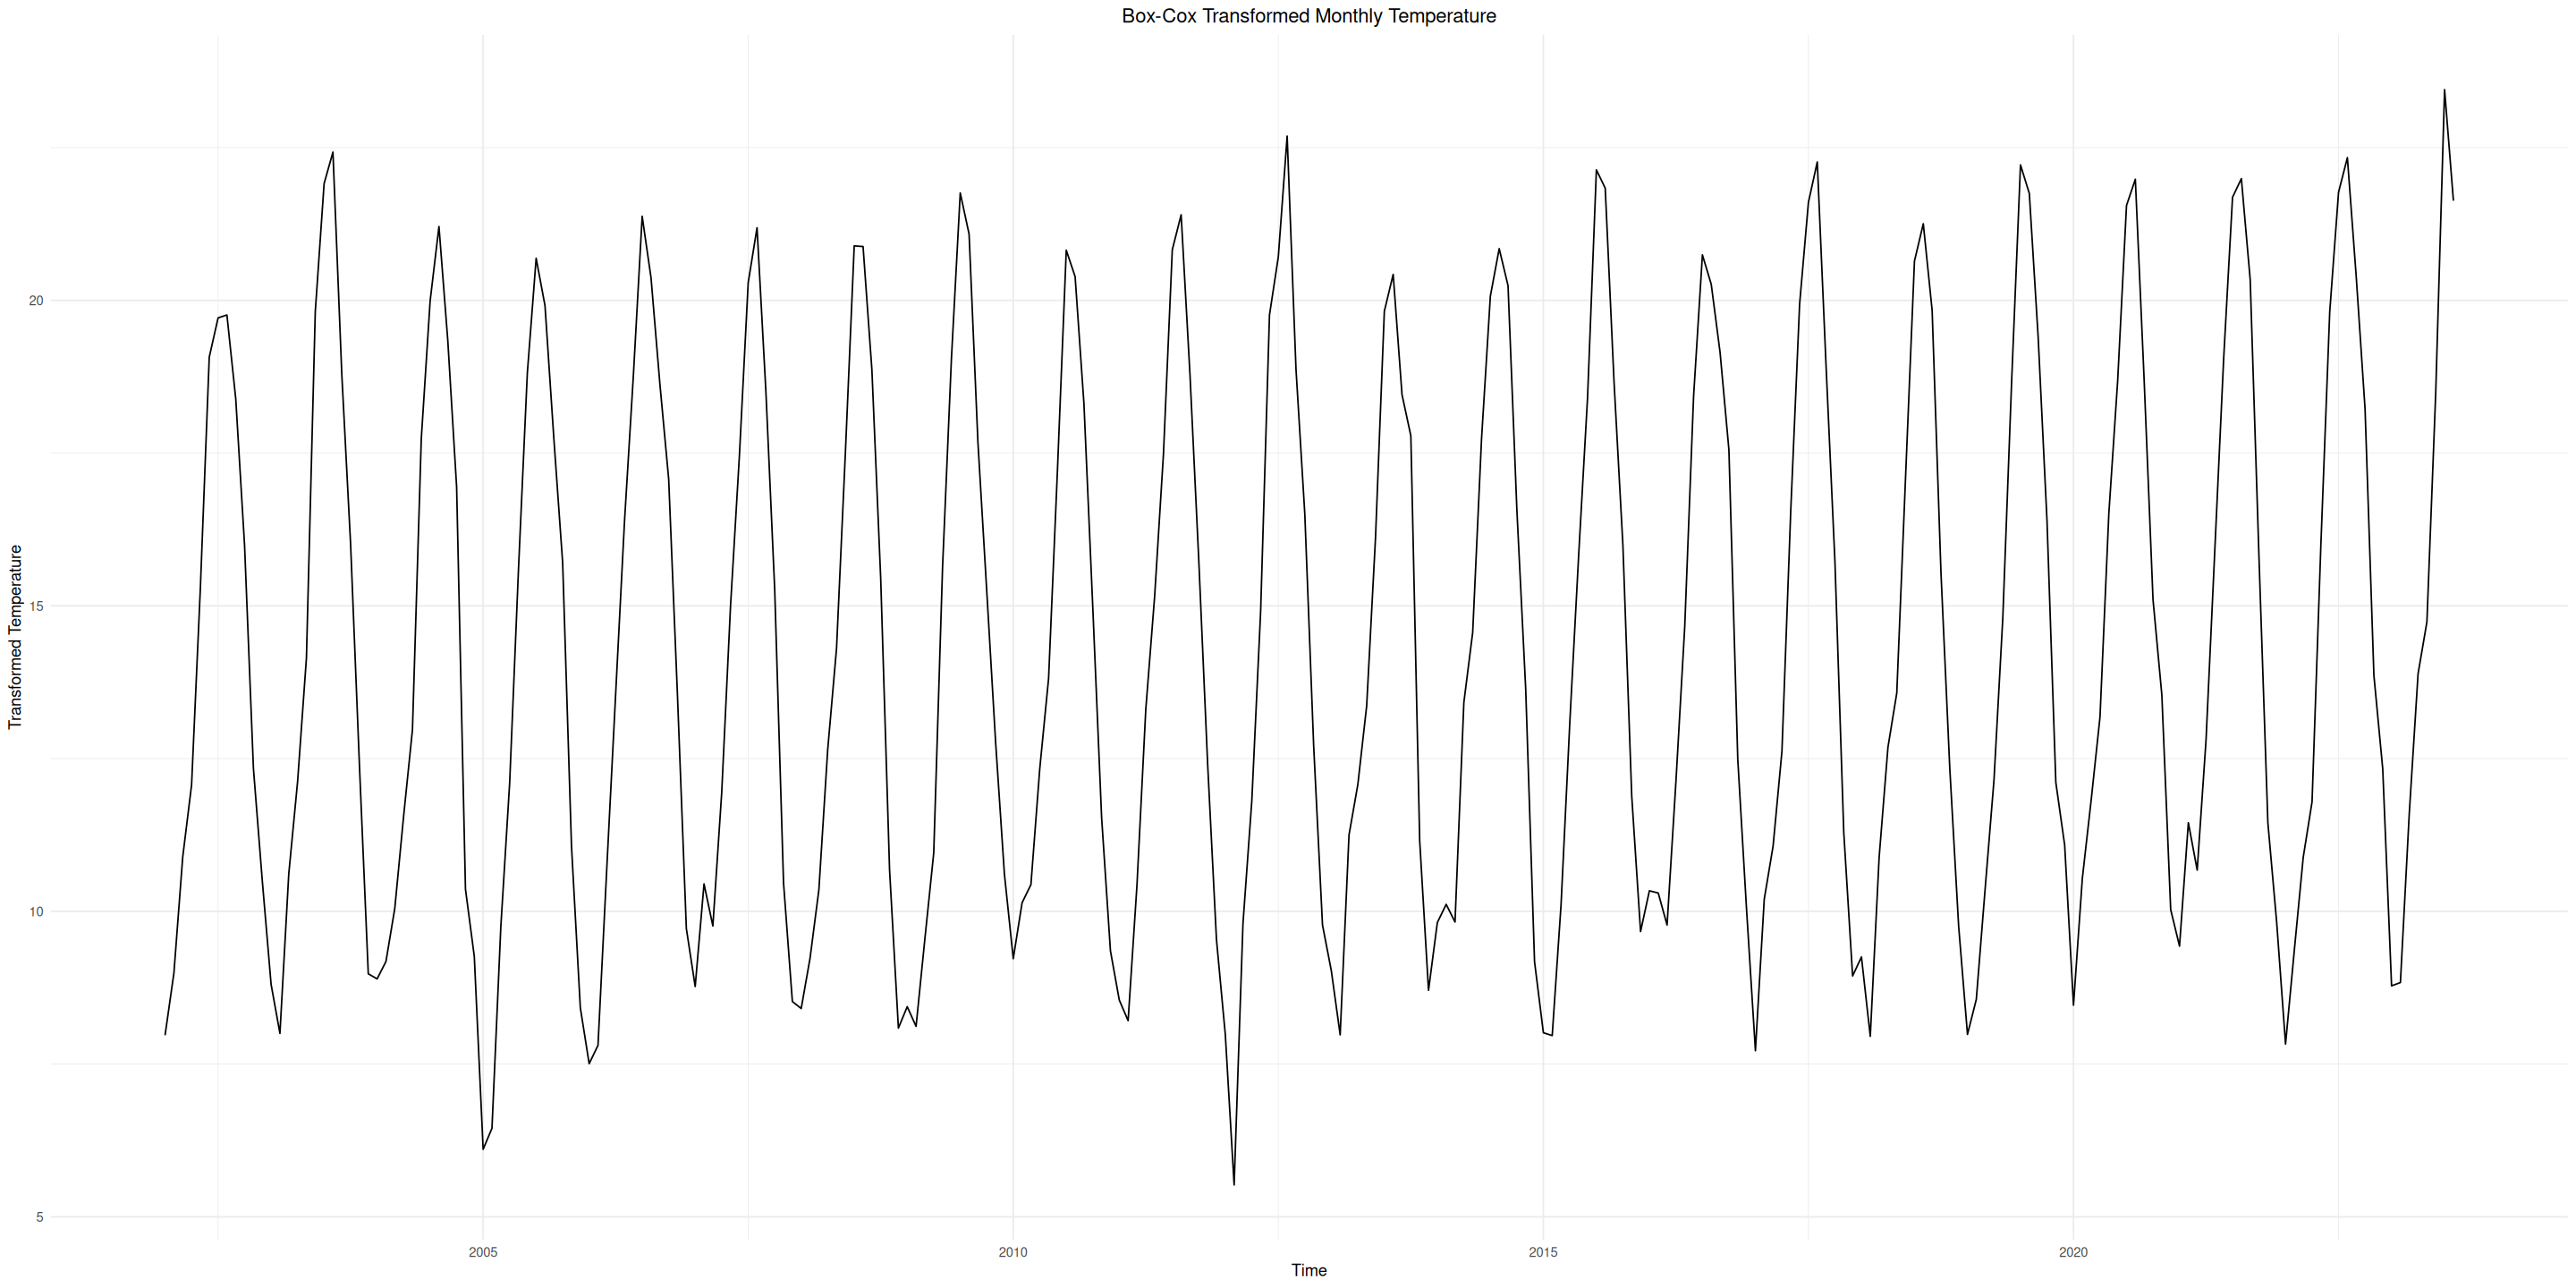

In [27]:
# Plot the transformed series
autoplot(temp_boxcox) +
  labs(title = "Box-Cox Transformed Monthly Temperature",
       x = "Time",
       y = "Transformed Temperature") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

In [28]:
# Apply seasonal differencing (lag=12 for monthly data)
temp_seasonal_diff <- diff(temp_boxcox, lag = 12)

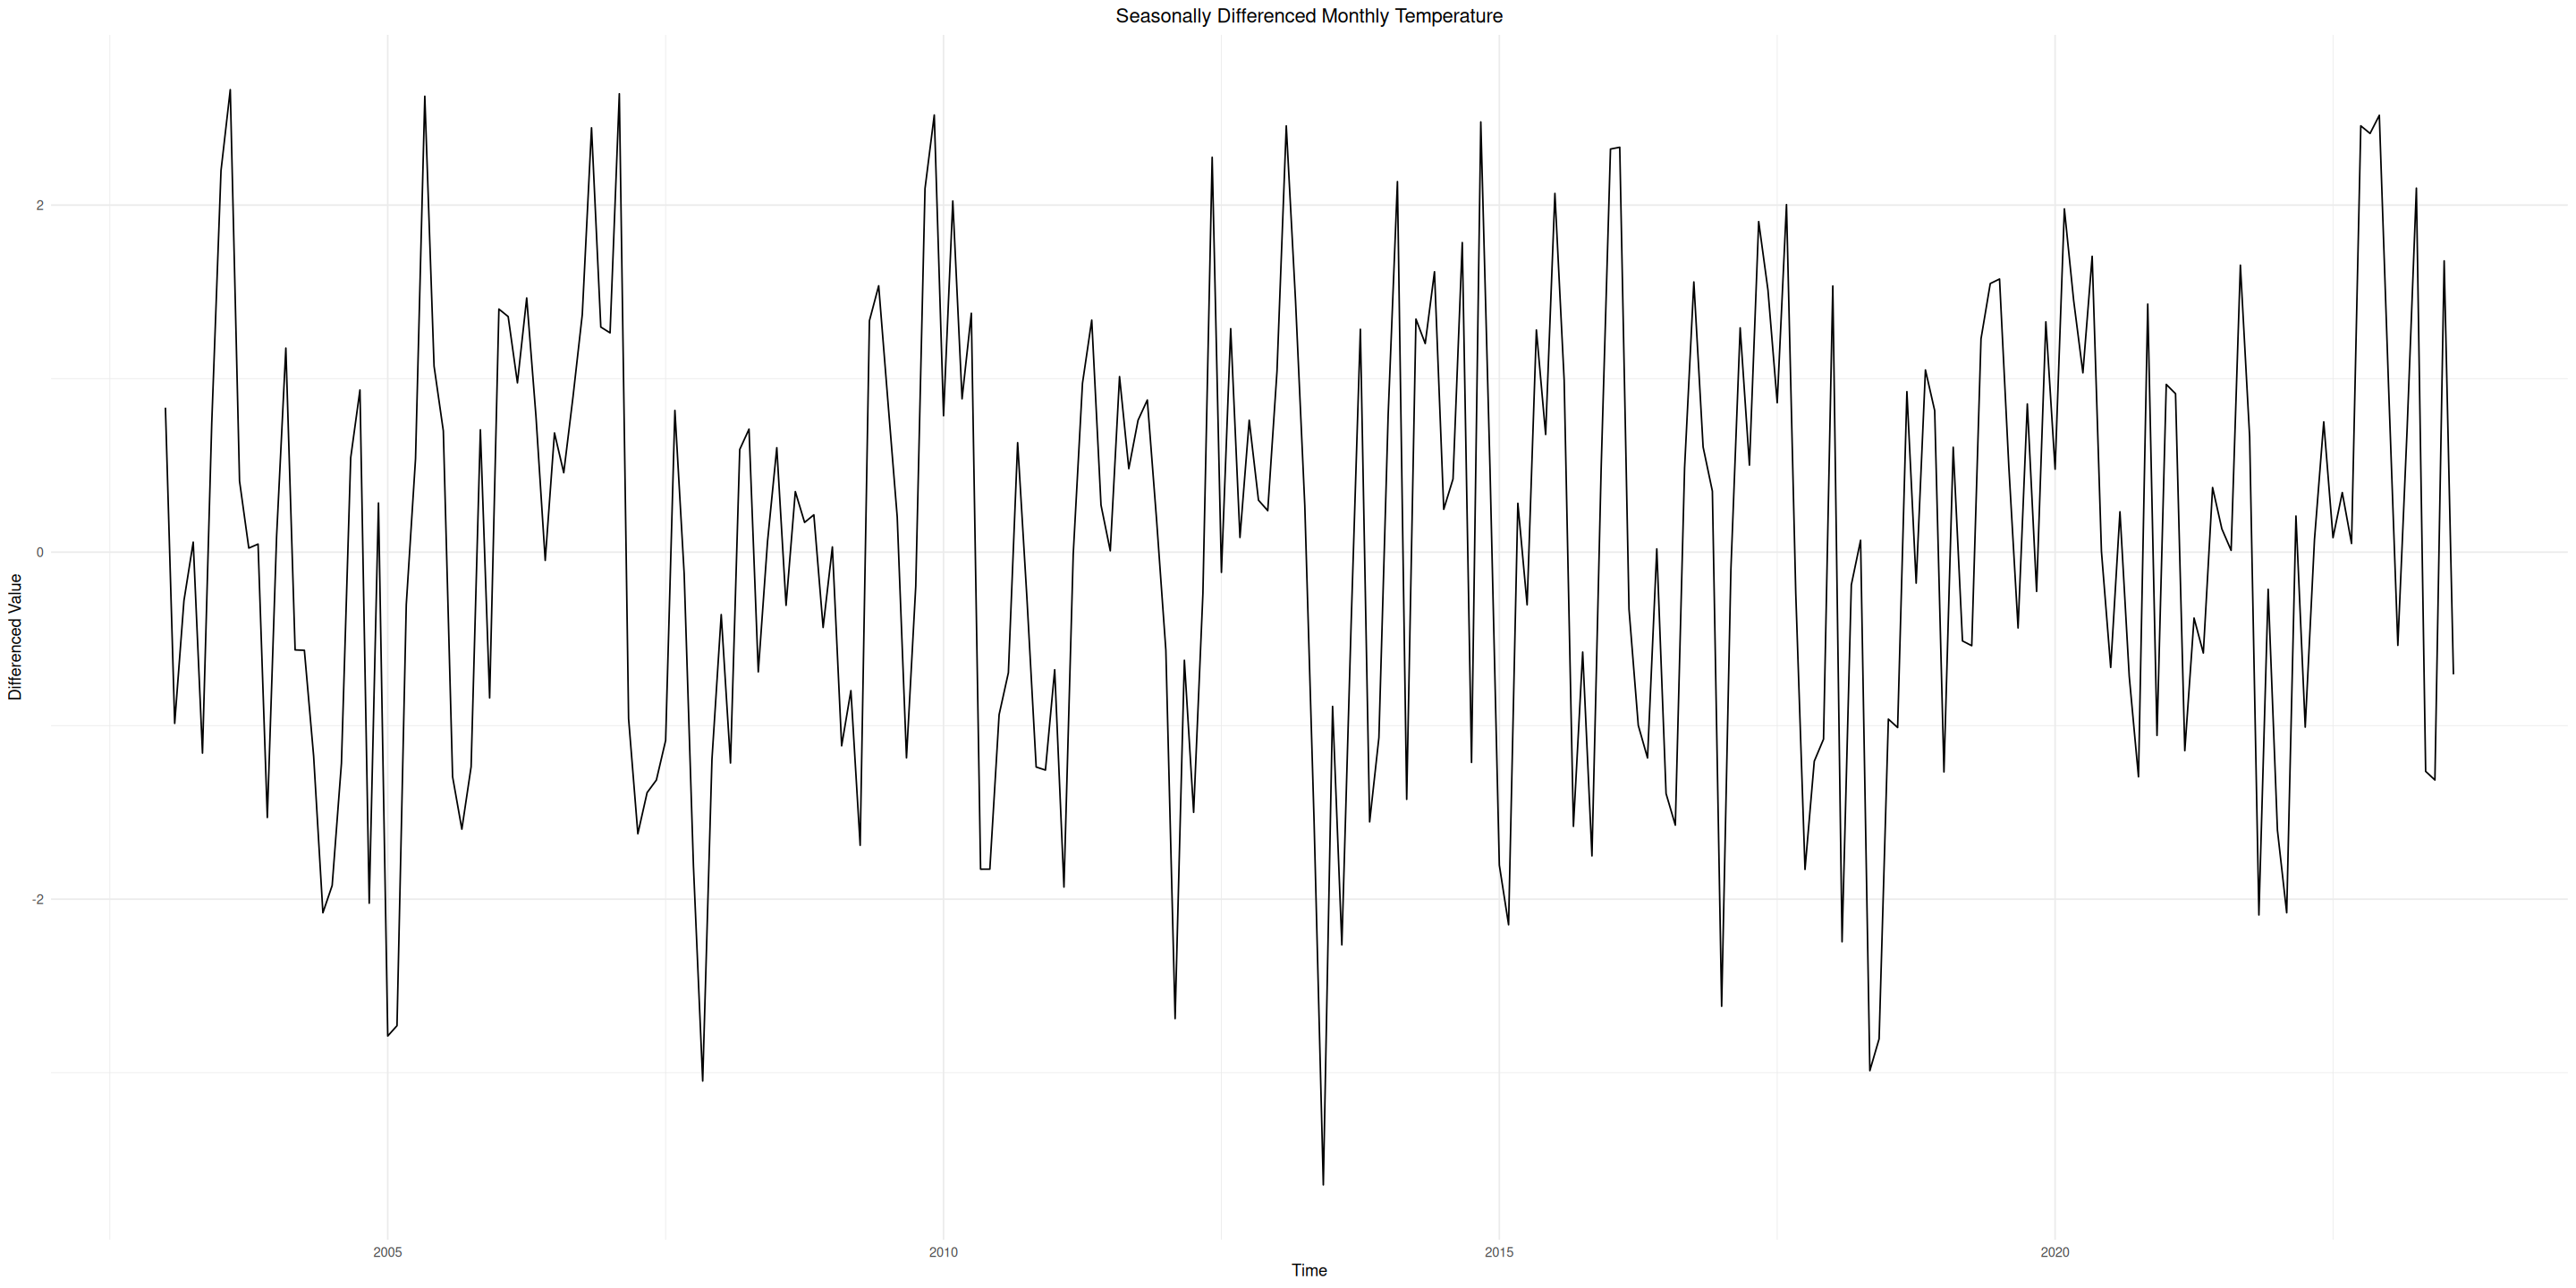

In [29]:
# Plot the seasonally differenced series
autoplot(temp_seasonal_diff) +
  labs(title = "Seasonally Differenced Monthly Temperature",
       x = "Time",
       y = "Differenced Value") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

In [30]:
# Check stationarity of seasonally differenced series
adf_test_seasonal <- adf.test(temp_seasonal_diff)
print("ADF Test after seasonal differencing:")
print(adf_test_seasonal)

Warning message in adf.test(temp_seasonal_diff):
“p-value smaller than printed p-value”


[1] "ADF Test after seasonal differencing:"

	Augmented Dickey-Fuller Test

data:  temp_seasonal_diff
Dickey-Fuller = -5.1044, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary



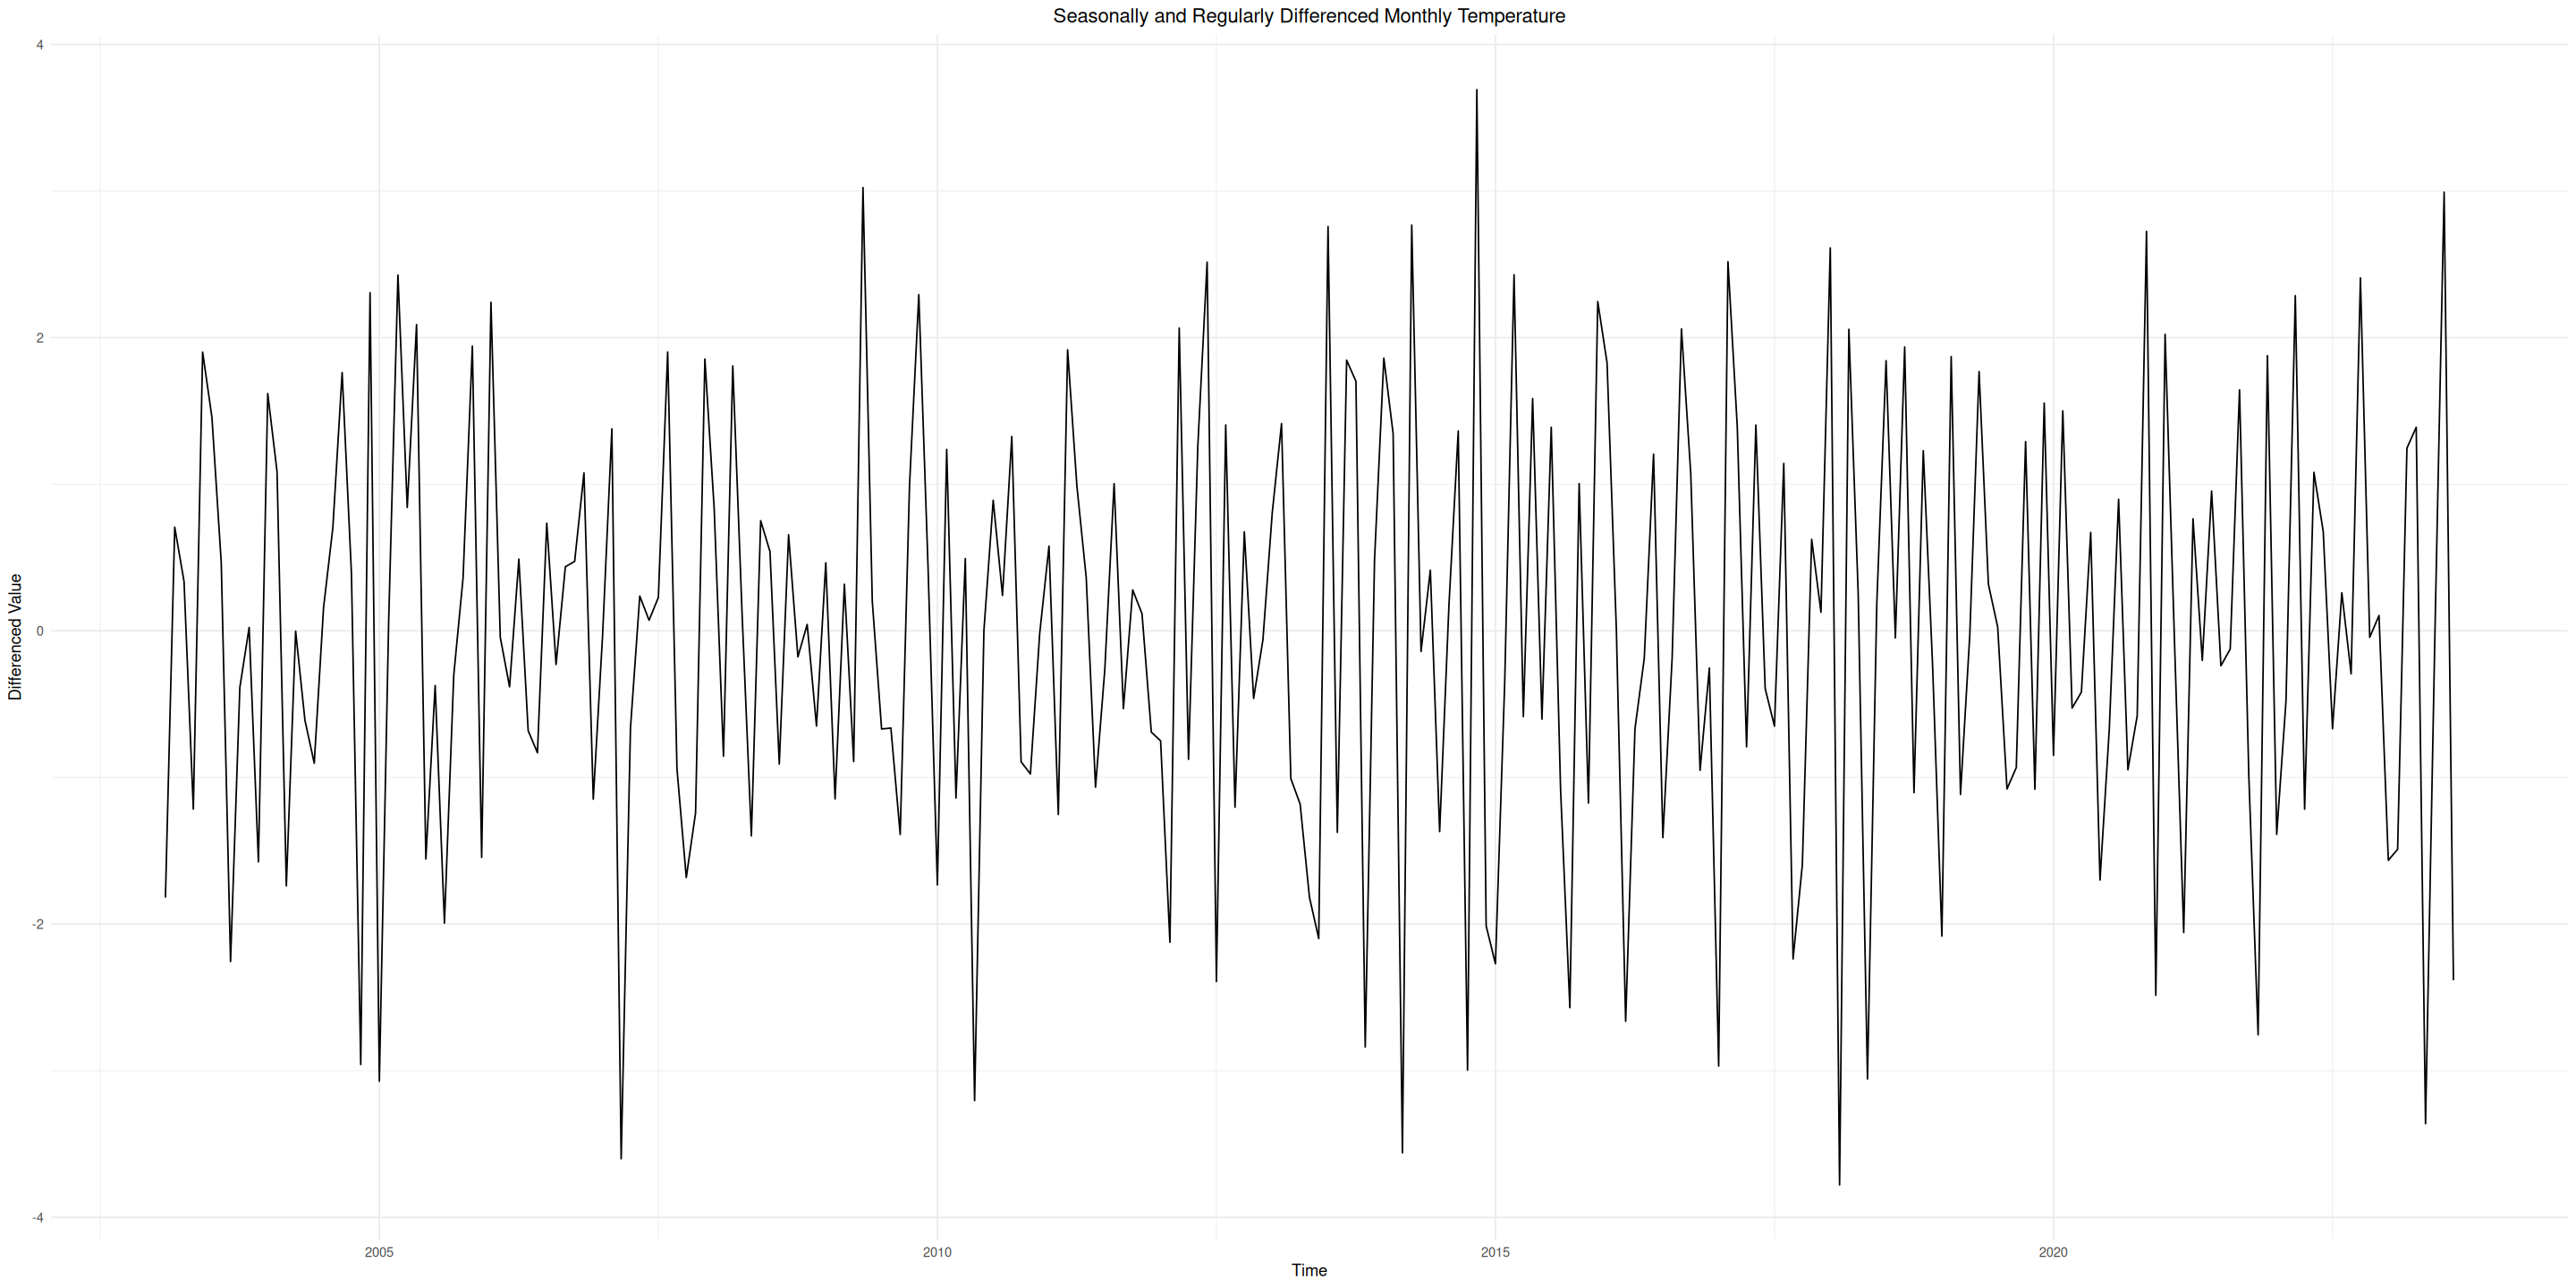

In [31]:
# Check if we need regular differencing after seasonal differencing
temp_diff <- diff(temp_seasonal_diff, differences = 1)

# Plot the differenced series
autoplot(temp_diff) +
  labs(title = "Seasonally and Regularly Differenced Monthly Temperature",
       x = "Time",
       y = "Differenced Value") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

In [32]:
# Check stationarity after both differences
adf_test_both <- adf.test(temp_diff)
print("ADF Test after both seasonal and regular differencing:")
print(adf_test_both)

Warning message in adf.test(temp_diff):
“p-value smaller than printed p-value”


[1] "ADF Test after both seasonal and regular differencing:"

	Augmented Dickey-Fuller Test

data:  temp_diff
Dickey-Fuller = -10.358, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary



In [33]:
# Determine the necessary level of differencing
if (adf_test_seasonal$p.value < 0.05) {
  cat("Only seasonal differencing (D=1) is sufficient to achieve stationarity.\n")
  temp_final <- temp_seasonal_diff
  d_value <- 0
  D_value <- 1
} else if (adf_test_both$p.value < 0.05) {
  cat("Both seasonal (D=1) and regular differencing (d=1) are needed for stationarity.\n")
  temp_final <- temp_diff
  d_value <- 1
  D_value <- 1
} else {
  cat("More differencing may be needed or other transformations should be considered.\n")
  # Default to seasonal differencing only for this example
  temp_final <- temp_seasonal_diff
  d_value <- 0
  D_value <- 1
}

Only seasonal differencing (D=1) is sufficient to achieve stationarity.


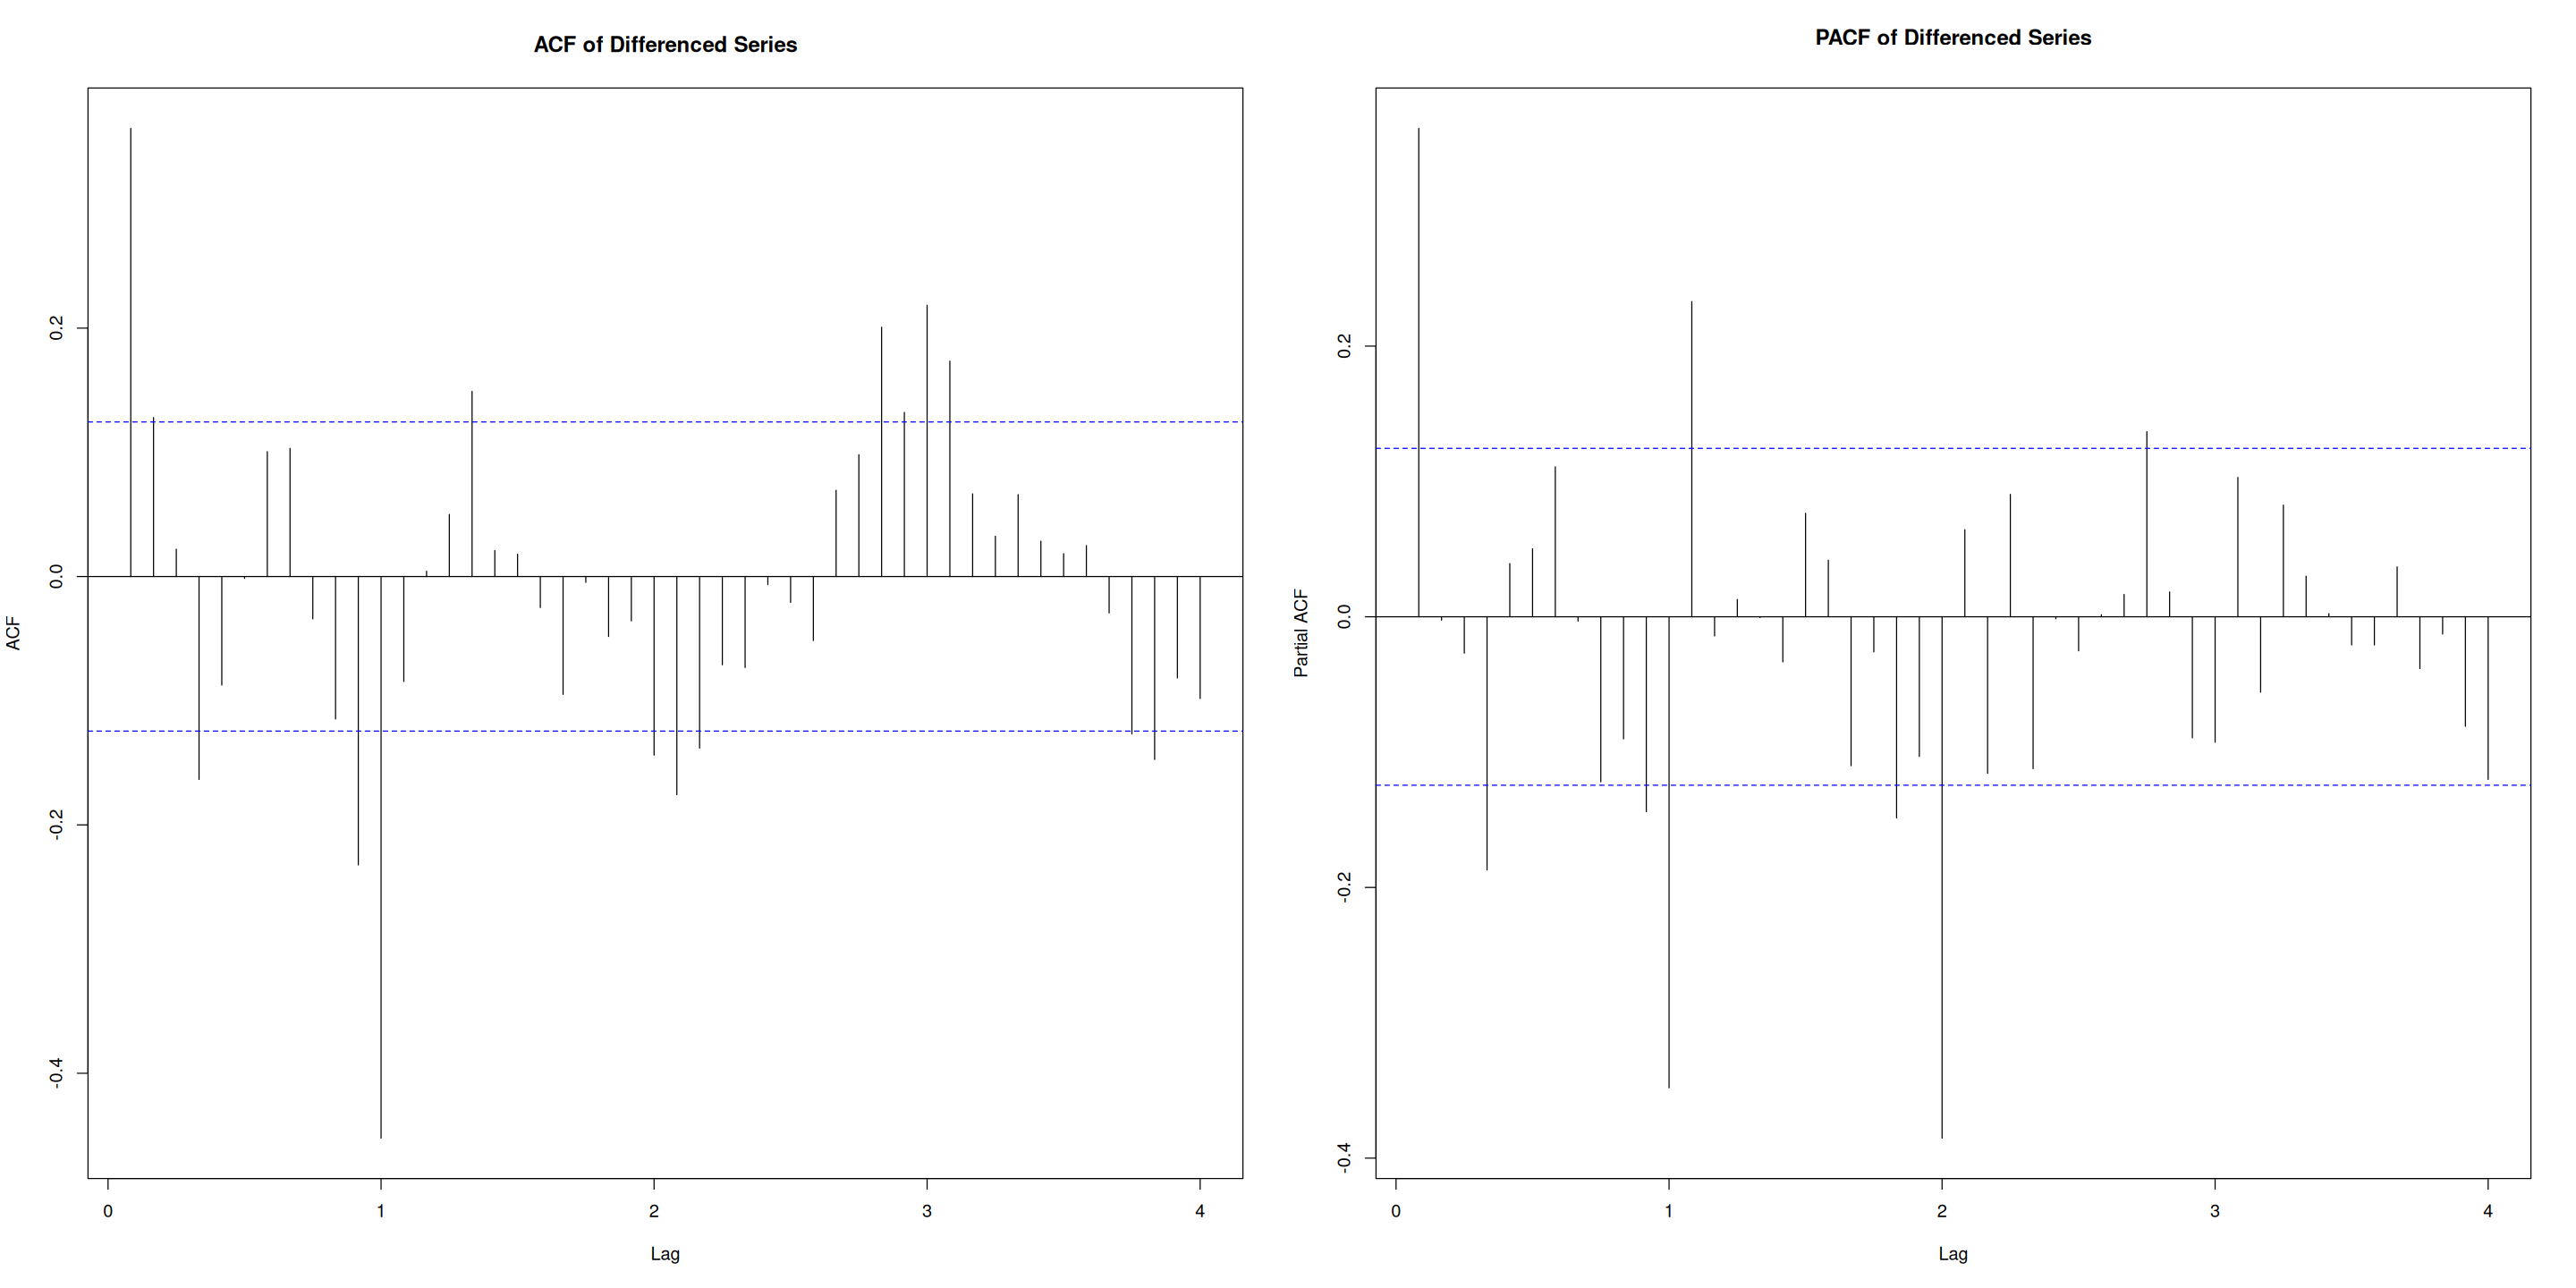

In [34]:
# Check ACF and PACF of differenced series
par(bg = "white")
par(mfrow = c(1, 2))
acf(temp_final, main = "ACF of Differenced Series", lag.max = 48)
pacf(temp_final, main = "PACF of Differenced Series", lag.max = 48)
par(mfrow = c(1, 1))

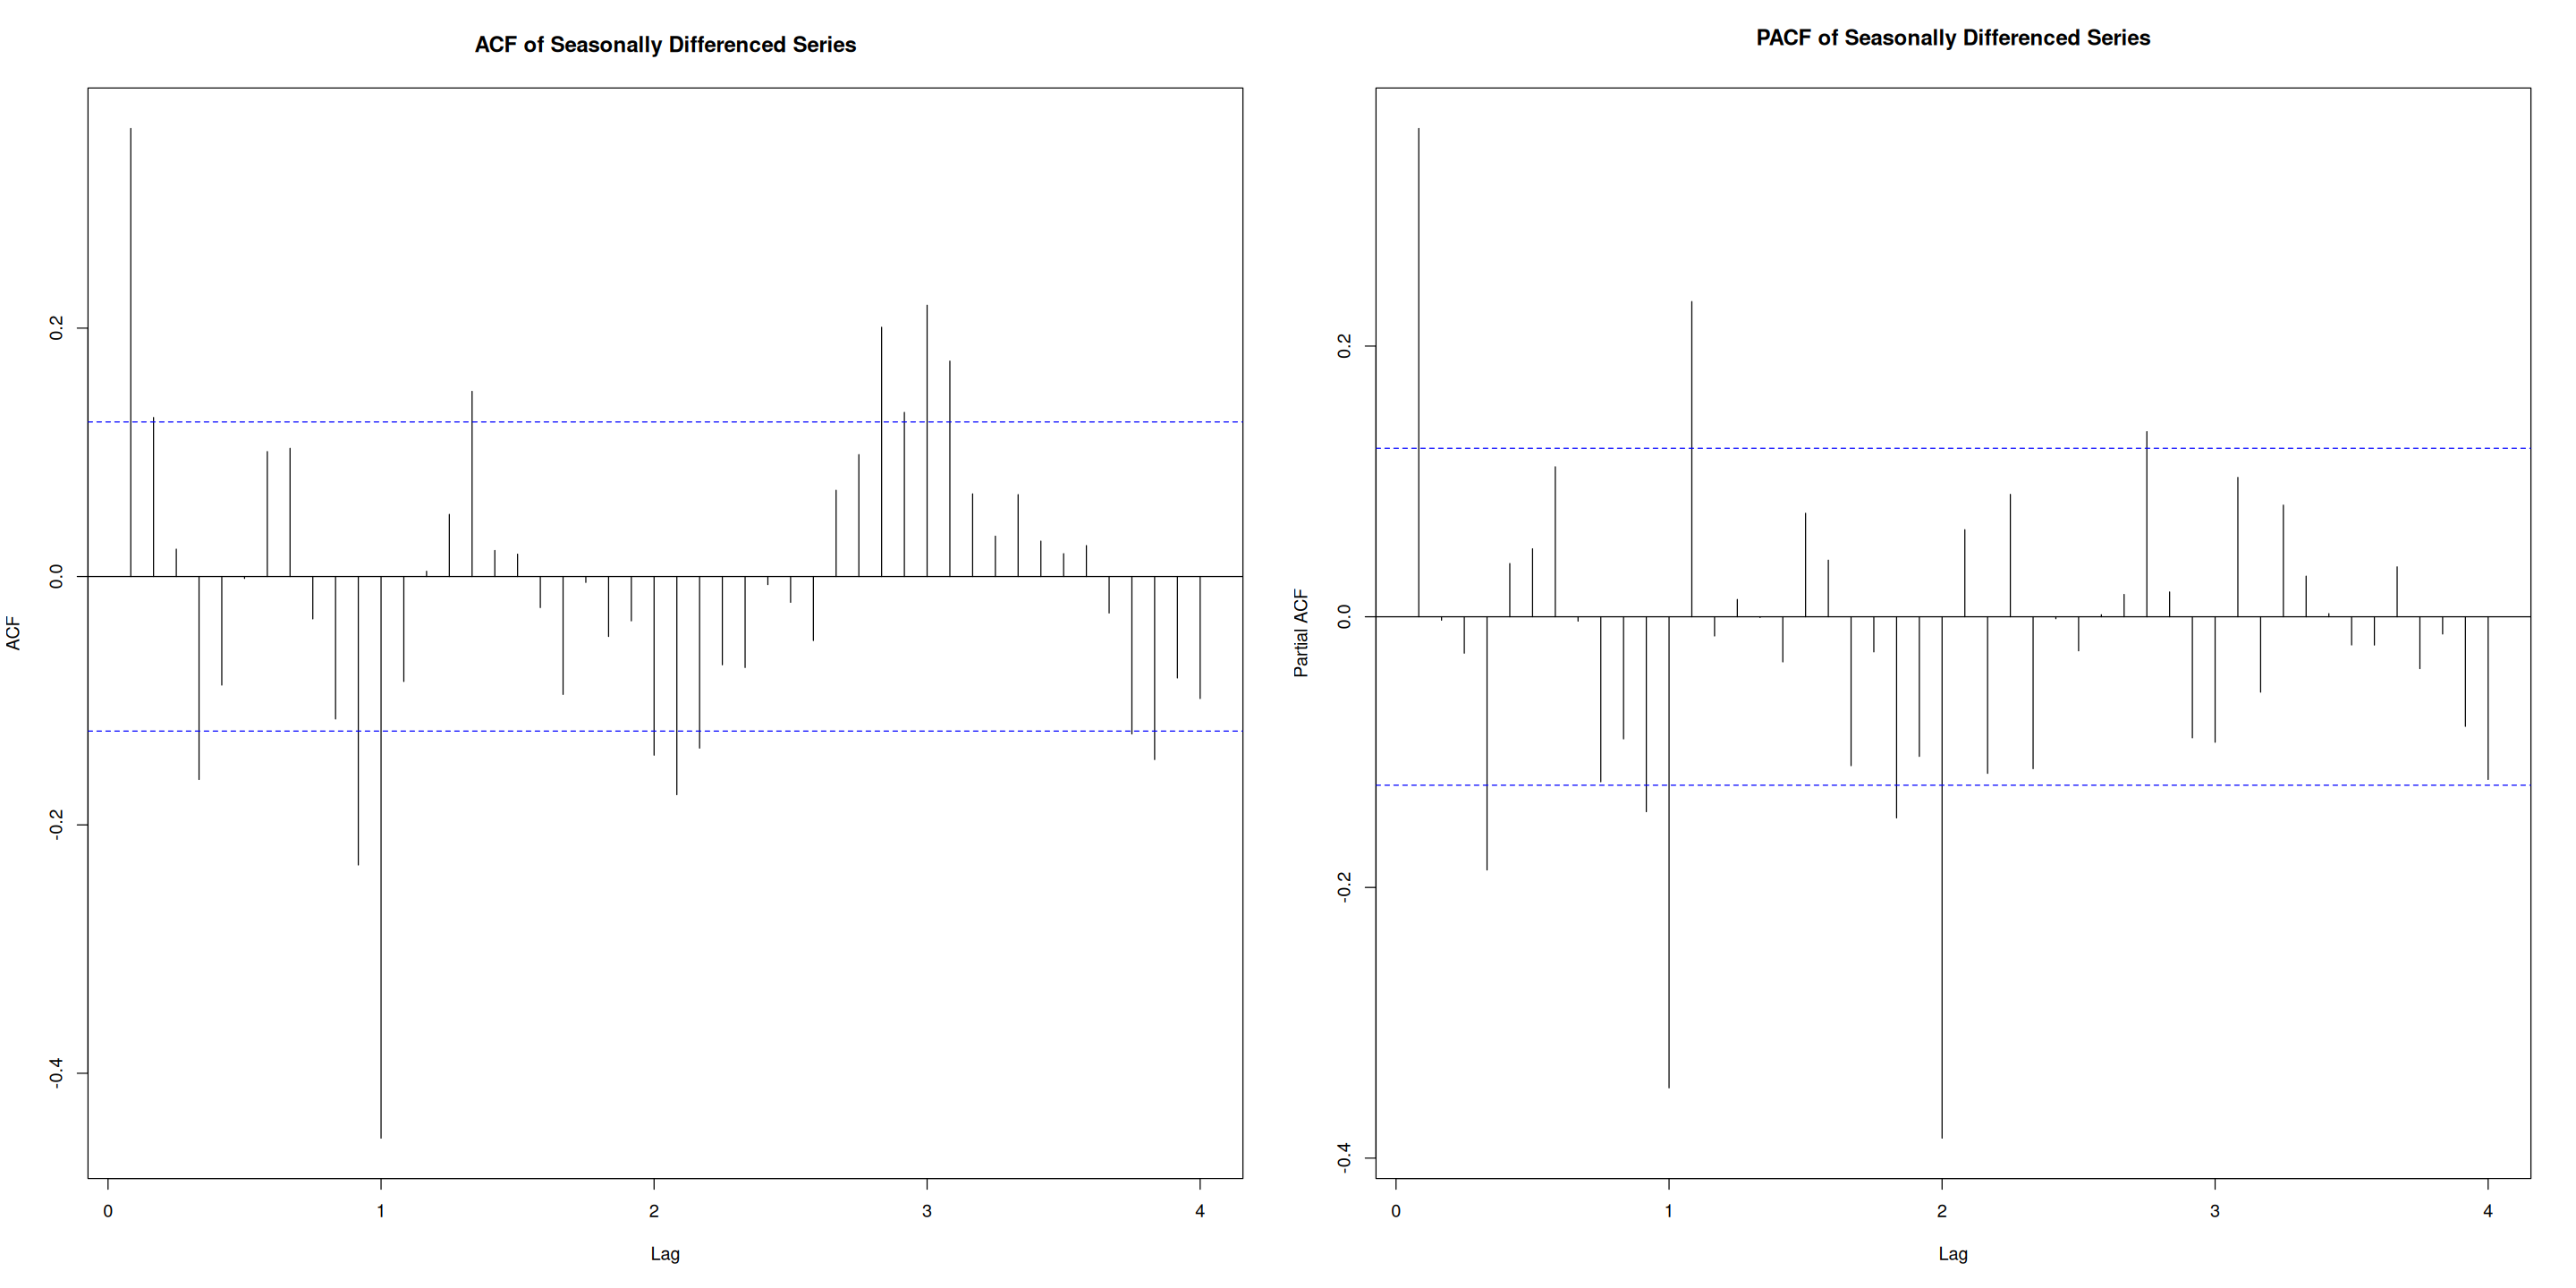

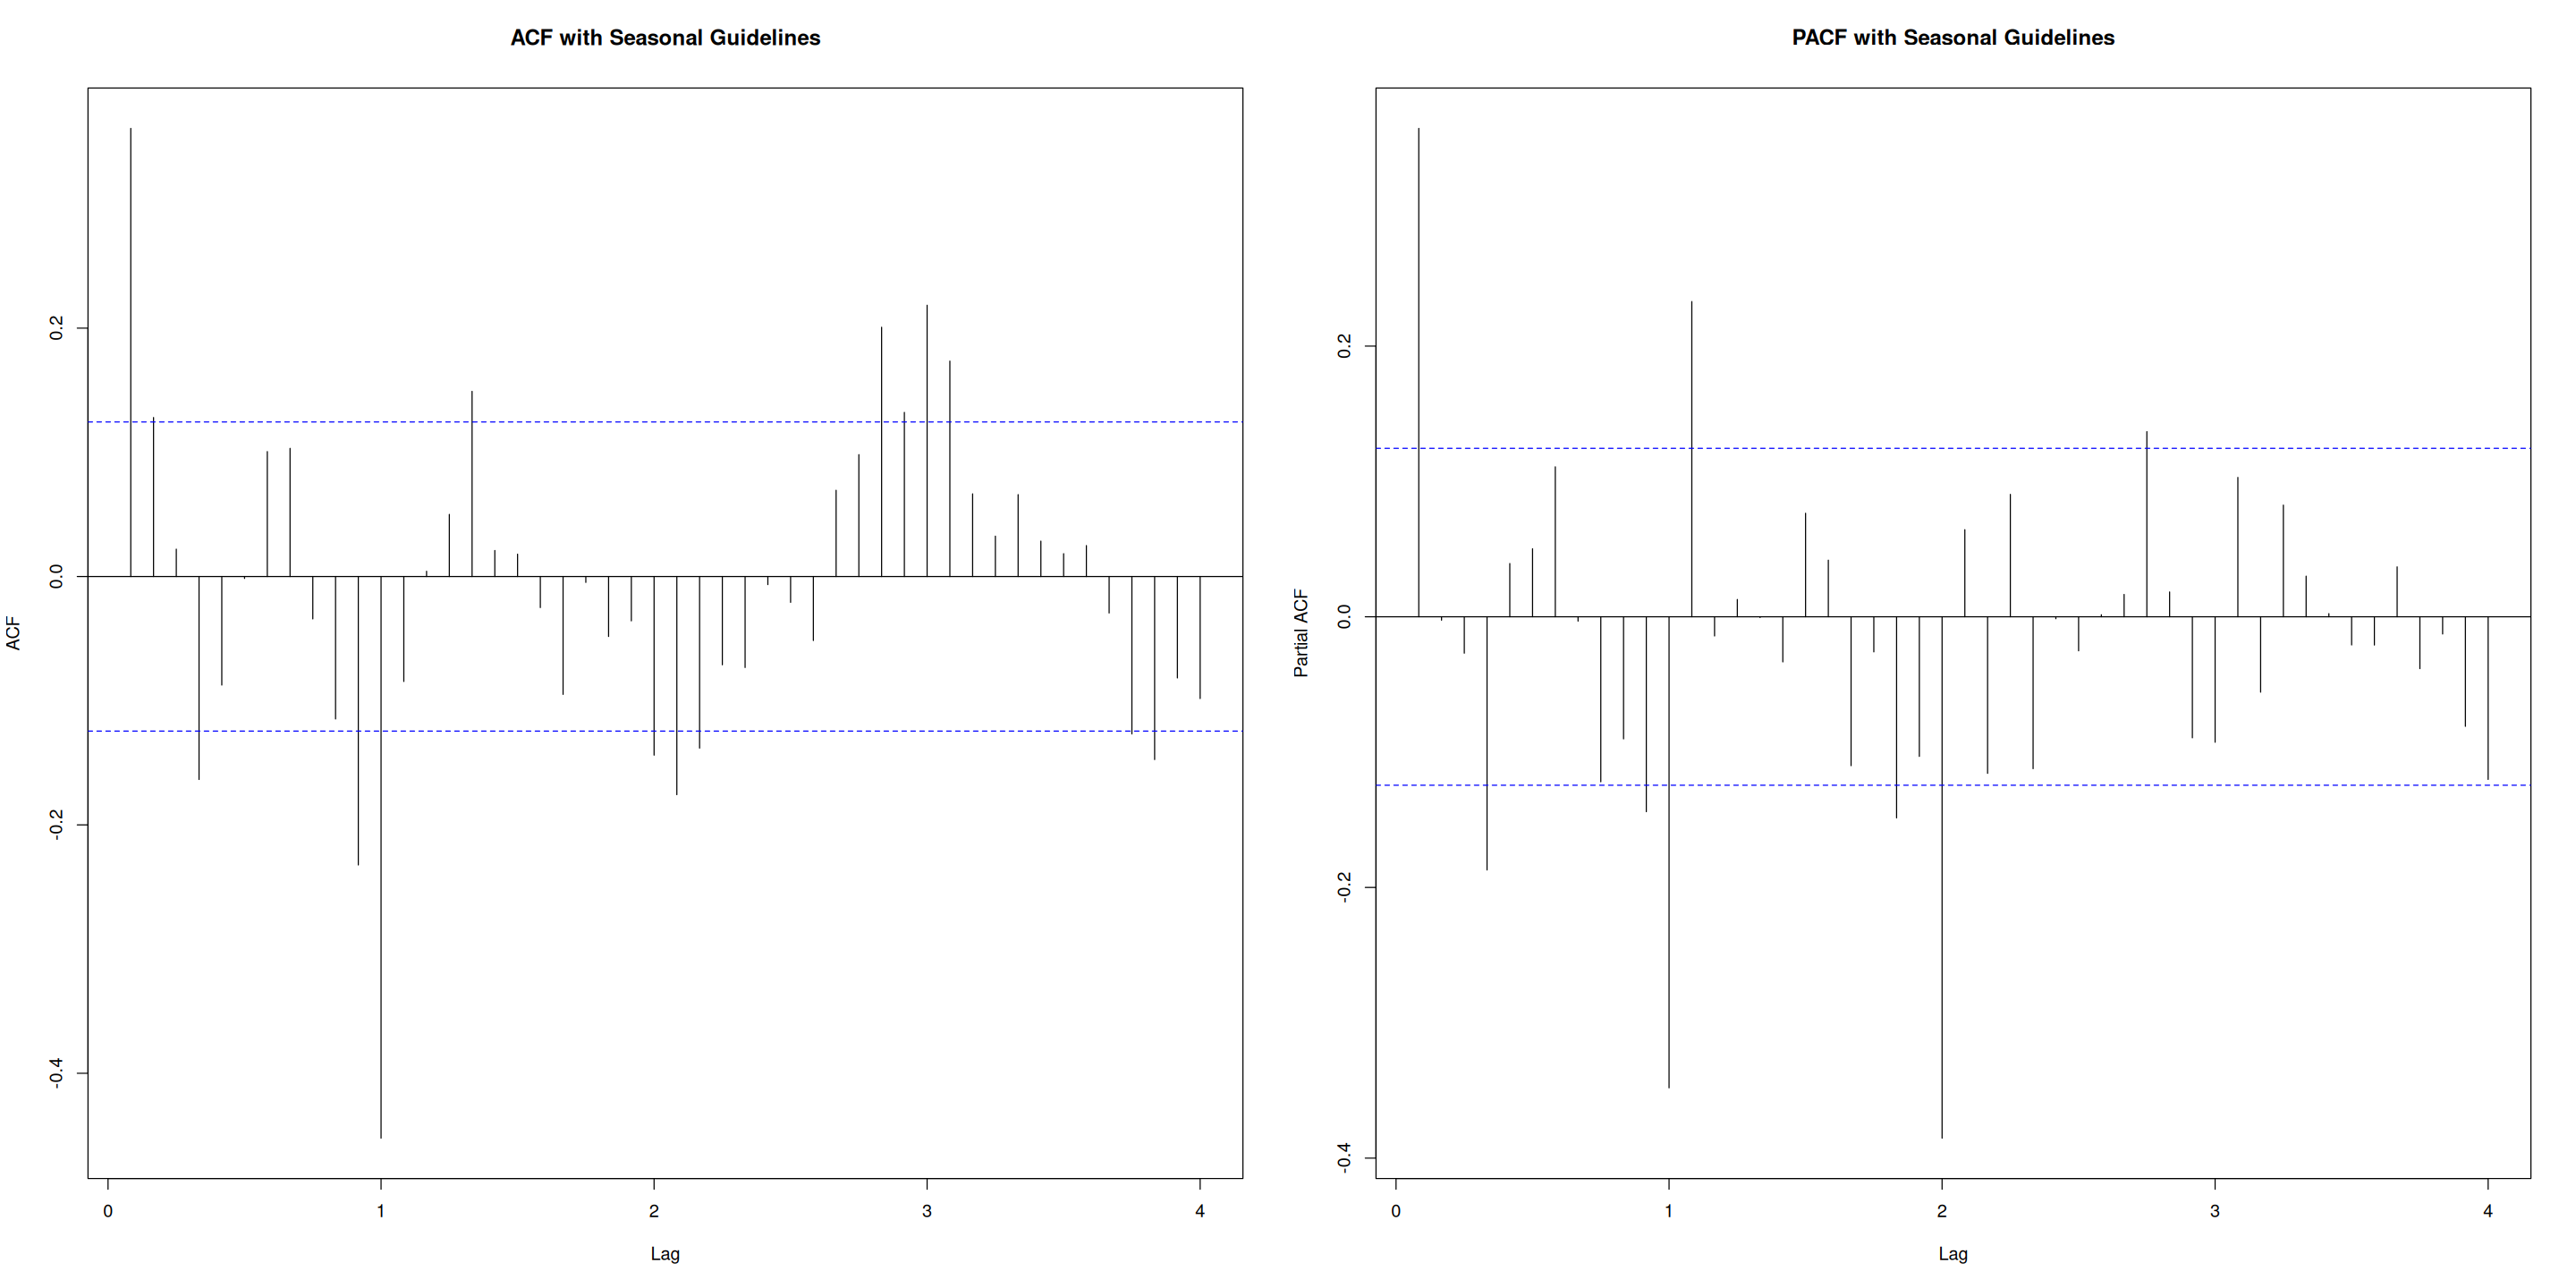

In [35]:
# Check ACF and PACF of seasonally differenced series (after removing seasonality)
par(bg = "white")
par(mfrow = c(1, 2))
acf(temp_seasonal_diff, main = "ACF of Seasonally Differenced Series", lag.max = 48)
pacf(temp_seasonal_diff, main = "PACF of Seasonally Differenced Series", lag.max = 48)
par(mfrow = c(1, 1))

# Add vertical lines at seasonal lags (multiples of 12) to help interpret
par(mfrow = c(1, 2))
acf_result <- acf(temp_seasonal_diff, plot = FALSE, lag.max = 48)
plot(acf_result, main = "ACF with Seasonal Guidelines")
abline(v = 12*(1:4), lty = 2, col = "blue")

pacf_result <- pacf(temp_seasonal_diff, plot = FALSE, lag.max = 48)
plot(pacf_result, main = "PACF with Seasonal Guidelines")
abline(v = 12*(1:4), lty = 2, col = "blue")
par(mfrow = c(1, 1))

# ==========================================
# 5. MODEL SPECIFICATION AND SELECTION
# ==========================================

Based on the ACF and PACF patterns of the differenced series, we can identify potential SARIMA models. The ACF and PACF help us determine the appropriate orders p, q, P, and Q for the ARIMA(p,d,q)(P,D,Q)[s] model with s=12 for monthly data.

From the visualization and stationarity tests, we've determined:
- Seasonal periodicity: s = 12 (monthly data)
- Seasonal differencing: D = 1 
- Regular differencing: d = 0 or 1 (to be determined based on final model fit)

In [36]:
# Split data into training and test sets
n <- length(monthly_temp_ts)
train_size <- n - 12  # Leave last 12 months for testing

# Create training and test sets
train_ts <- window(monthly_temp_ts, end = c(time(monthly_temp_ts)[train_size]))
test_ts <- window(monthly_temp_ts, start = c(time(monthly_temp_ts)[train_size + 1]))

# Apply the same transformation to the training data
train_boxcox <- BoxCox(train_ts, lambda)

In [37]:
# Auto ARIMA for automatic model selection on training data
auto_arima_model <- auto.arima(train_boxcox, 
                              seasonal = TRUE,
                              stepwise = FALSE,
                              approximation = FALSE,
                              trace = TRUE)
summary(auto_arima_model)


 ARIMA(0,0,0)(0,1,0)[12]                    : 793.2871
 ARIMA(0,0,0)(0,1,0)[12] with drift         : 795.2252
 ARIMA(0,0,0)(0,1,1)[12]                    : 662.184
 ARIMA(0,0,0)(0,1,1)[12] with drift         : Inf
 ARIMA(0,0,0)(0,1,2)[12]                    : 661.7855
 ARIMA(0,0,0)(0,1,2)[12] with drift         : Inf
 ARIMA(0,0,0)(1,1,0)[12]                    : 734.2782
 ARIMA(0,0,0)(1,1,0)[12] with drift         : 736.0355
 ARIMA(0,0,0)(1,1,1)[12]                    : 662.6149
 ARIMA(0,0,0)(1,1,1)[12] with drift         : Inf
 ARIMA(0,0,0)(1,1,2)[12]                    : 664.8261
 ARIMA(0,0,0)(1,1,2)[12] with drift         : Inf
 ARIMA(0,0,0)(2,1,0)[12]                    : 671.0465
 ARIMA(0,0,0)(2,1,0)[12] with drift         : 671.5206
 ARIMA(0,0,0)(2,1,1)[12]                    : 657.293
 ARIMA(0,0,0)(2,1,1)[12] with drift         : Inf
 ARIMA(0,0,0)(2,1,2)[12]                    : 656.8038
 ARIMA(0,0,0)(2,1,2)[12] with drift         : Inf
 ARIMA(0,0,1)(0,1,0)[12]                 

Series: train_boxcox 
ARIMA(1,0,0)(0,1,2)[12] 

Coefficients:
         ar1     sma1    sma2
      0.3610  -0.9448  0.0691
s.e.  0.0619   0.0726  0.0759

sigma^2 = 0.7712:  log likelihood = -311.93
AIC=631.86   AICc=632.04   BIC=645.72

Training set error measures:
                     ME      RMSE       MAE       MPE     MAPE      MASE
Training set 0.09244812 0.8512259 0.6564084 0.1807235 5.300828 0.6182668
                    ACF1
Training set -0.02125894

In [38]:
# Define a range of potential models to try
p_values <- 0:2
d_values <- 0:1
q_values <- 0:2
P_values <- 0:1
D_value <- 1  # We're confident we need seasonal differencing
Q_values <- 0:1

# Create empty dataframe to store results
model_results <- data.frame(
  p = integer(),
  d = integer(),
  q = integer(),
  P = integer(),
  D = integer(),
  Q = integer(),
  AIC = numeric(),
  BIC = numeric(),
  AICc = numeric()
)


In [39]:
# Test a subset of models to avoid computational overload
for (p in p_values) {
  for (d in d_values) {
    for (q in q_values) {
      for (P in P_values) {
        for (Q in Q_values) {
          # Skip some combinations to reduce computation
          if ((p + d + q + P + D_value + Q) <= 6) {  # Limit model complexity
            tryCatch({
              model <- Arima(train_boxcox, order = c(p, d, q), 
                            seasonal = list(order = c(P, D_value, Q), period = 12))
              model_results <- rbind(model_results, data.frame(
                p = p,
                d = d,
                q = q,
                P = P,
                D = D_value,
                Q = Q,
                AIC = model$aic,
                BIC = model$bic,
                AICc = model$aicc
              ))
            }, error = function(e) {
              # Skip models that fail to converge
              cat("Error with model SARIMA(", p, ",", d, ",", q, ")", 
                  "(", P, ",", D_value, ",", Q, ")[12]: ", e$message, "\n")
            })
          }
        }
      }
    }
  }
}

In [40]:
# Sort models by AIC, BIC, and AICc
model_results_aic <- model_results[order(model_results$AIC),]
model_results_bic <- model_results[order(model_results$BIC),]
model_results_aicc <- model_results[order(model_results$AICc),]

# Add SARIMA notation column
model_results_aic$Model <- paste0("SARIMA(", 
                                  model_results_aic$p, ",", 
                                  model_results_aic$d, ",", 
                                  model_results_aic$q, ")(", 
                                  model_results_aic$P, ",", 
                                  model_results_aic$D, ",", 
                                  model_results_aic$Q, ")[12]")

model_results_bic$Model <- paste0("SARIMA(", 
                                  model_results_bic$p, ",", 
                                  model_results_bic$d, ",", 
                                  model_results_bic$q, ")(", 
                                  model_results_bic$P, ",", 
                                  model_results_bic$D, ",", 
                                  model_results_bic$Q, ")[12]")

model_results_aicc$Model <- paste0("SARIMA(", 
                                   model_results_aicc$p, ",", 
                                   model_results_aicc$d, ",", 
                                   model_results_aicc$q, ")(", 
                                   model_results_aicc$P, ",", 
                                   model_results_aicc$D, ",", 
                                   model_results_aicc$Q, ")[12]")

# Show the top 5 models by AIC
cat("Top 5 models by AIC:\n")
print(head(model_results_aic[, c("Model", "AIC", "BIC", "AICc")], 5))

# Show the top 5 models by BIC
cat("\nTop 5 models by BIC:\n")
print(head(model_results_bic[, c("Model", "BIC", "AIC", "AICc")], 5))

# Show the top 5 models by AICc
cat("\nTop 5 models by AICc:\n")
print(head(model_results_aicc[, c("Model", "AICc", "AIC", "BIC")], 5))

Top 5 models by AIC:
                      Model      AIC      BIC     AICc
42 SARIMA(1,1,1)(0,1,1)[12] 630.3912 644.2296 630.5651
26 SARIMA(1,0,0)(0,1,1)[12] 630.6590 641.0505 630.7625
44 SARIMA(1,1,1)(1,1,1)[12] 631.5494 648.8473 631.8114
22 SARIMA(0,1,2)(0,1,1)[12] 631.8711 645.7095 632.0451
28 SARIMA(1,0,0)(1,1,1)[12] 632.0005 645.8559 632.1737

Top 5 models by BIC:
                      Model      BIC      AIC     AICc
26 SARIMA(1,0,0)(0,1,1)[12] 641.0505 630.6590 630.7625
42 SARIMA(1,1,1)(0,1,1)[12] 644.2296 630.3912 630.5651
6  SARIMA(0,0,1)(0,1,1)[12] 644.6345 634.2430 634.3464
22 SARIMA(0,1,2)(0,1,1)[12] 645.7095 631.8711 632.0451
28 SARIMA(1,0,0)(1,1,1)[12] 645.8559 632.0005 632.1737

Top 5 models by AICc:
                      Model     AICc      AIC      BIC
42 SARIMA(1,1,1)(0,1,1)[12] 630.5651 630.3912 644.2296
26 SARIMA(1,0,0)(0,1,1)[12] 630.7625 630.6590 641.0505
44 SARIMA(1,1,1)(1,1,1)[12] 631.8114 631.5494 648.8473
22 SARIMA(0,1,2)(0,1,1)[12] 632.0451 631.8711 645.7095

MODEL 1: Best model by AIC
SARIMA( 1 , 1 , 1 ) ( 0 , 1 , 1 )[12]

Series: train_boxcox 
ARIMA(1,1,1)(0,1,1)[12] 

Coefficients:
         ar1      ma1     sma1
      0.3267  -0.9876  -1.0000
s.e.  0.0635   0.0283   0.0807

sigma^2 = 0.6997:  log likelihood = -311.2
AIC=630.39   AICc=630.57   BIC=644.23

Training set error measures:
                     ME      RMSE       MAE        MPE     MAPE      MASE
Training set 0.06741642 0.8090697 0.6218934 0.03895598 5.022914 0.5857573
                     ACF1
Training set -0.007753397

AIC: 630.3912   BIC: 644.2296   AICc: 630.5651 

MODEL 2: Best model by BIC
SARIMA( 1 , 0 , 0 ) ( 0 , 1 , 1 )[12]

Series: train_boxcox 
ARIMA(1,0,0)(0,1,1)[12] 

Coefficients:
         ar1     sma1
      0.3673  -0.9043
s.e.  0.0614   0.0620

sigma^2 = 0.7642:  log likelihood = -312.33
AIC=630.66   AICc=630.76   BIC=641.05

Training set error measures:
                    ME      RMSE       MAE       MPE     MAPE      MASE
Training set 0.0938225 0.8491738 0.656

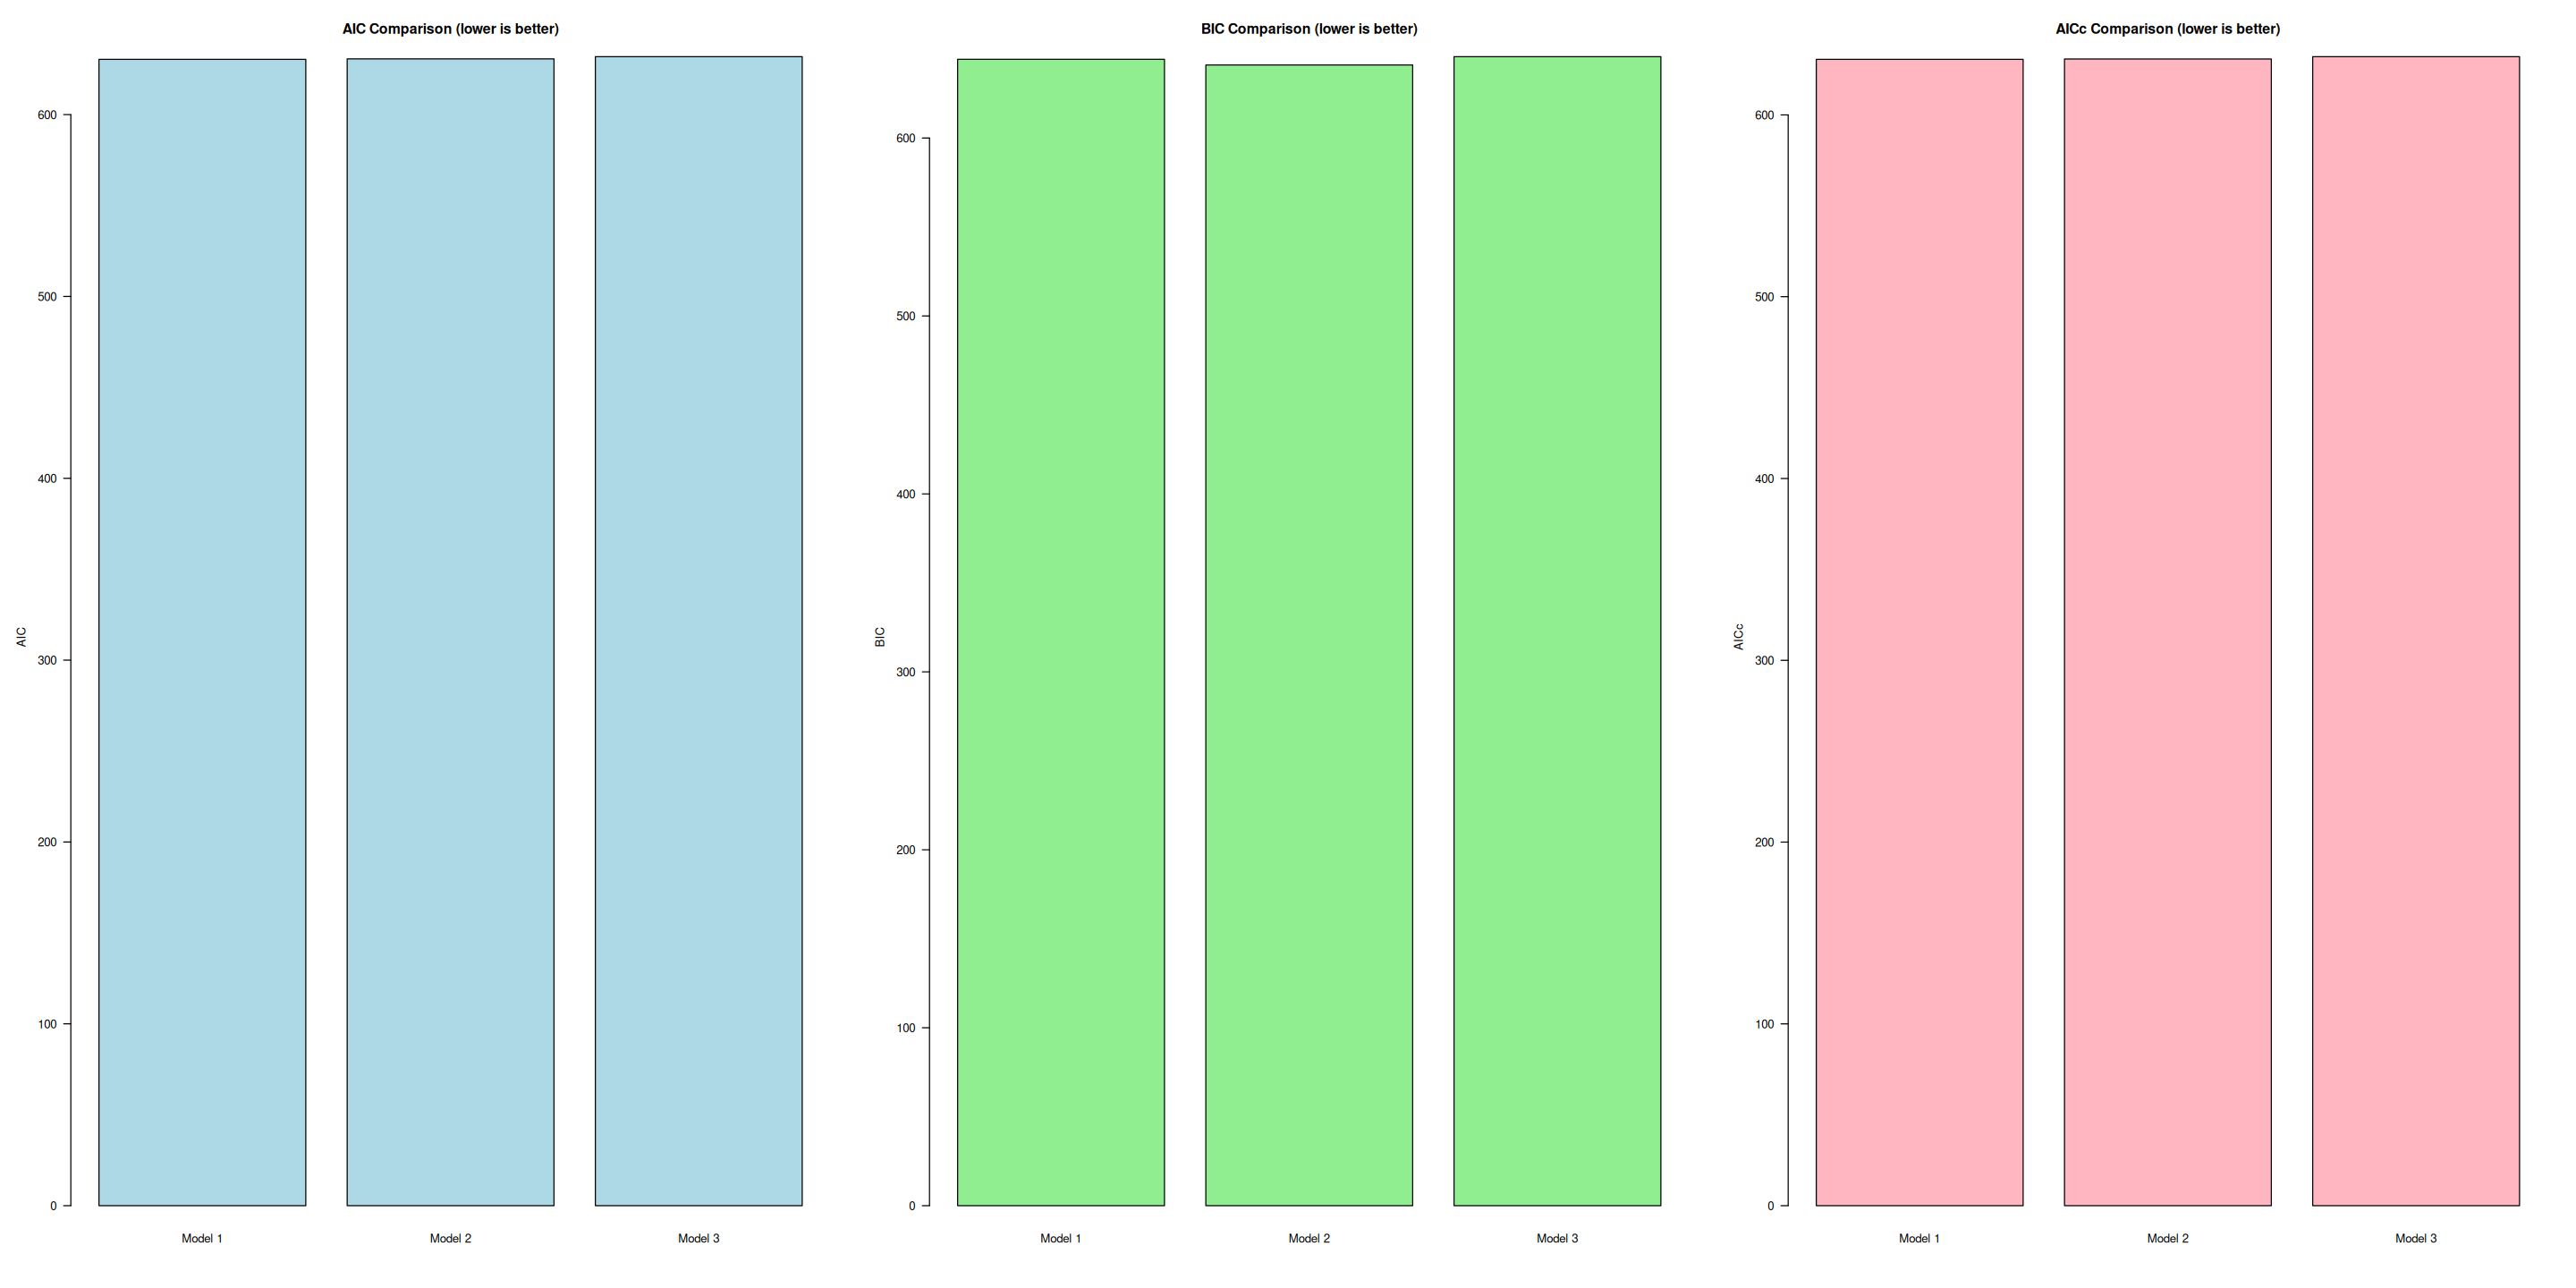

In [41]:
# Select top 3 models based on AIC for comparison
# Fit the top models from our comparison
model1_params <- head(model_results_aic, 1)
model1 <- Arima(train_boxcox, 
               order = c(model1_params$p, model1_params$d, model1_params$q),
               seasonal = list(order = c(model1_params$P, model1_params$D, model1_params$Q), period = 12))

model2_params <- head(model_results_bic, 1)
model2 <- Arima(train_boxcox, 
               order = c(model2_params$p, model2_params$d, model2_params$q),
               seasonal = list(order = c(model2_params$P, model2_params$D, model2_params$Q), period = 12))

# Also include the auto.arima model
model3 <- auto_arima_model

# Print detailed information about each model
cat("=================================================================\n")
cat("MODEL 1: Best model by AIC\n")
cat("=================================================================\n")
cat("SARIMA(", model1_params$p, ",", model1_params$d, ",", model1_params$q, ")",
    "(", model1_params$P, ",", model1_params$D, ",", model1_params$Q, ")[12]\n\n")
print(summary(model1))
cat("\nAIC:", model1$aic, "  BIC:", model1$bic, "  AICc:", model1$aicc, "\n\n")

cat("=================================================================\n")
cat("MODEL 2: Best model by BIC\n")
cat("=================================================================\n")
cat("SARIMA(", model2_params$p, ",", model2_params$d, ",", model2_params$q, ")",
    "(", model2_params$P, ",", model2_params$D, ",", model2_params$Q, ")[12]\n\n")
print(summary(model2))
cat("\nAIC:", model2$aic, "  BIC:", model2$bic, "  AICc:", model2$aicc, "\n\n")

cat("=================================================================\n")
cat("MODEL 3: Auto ARIMA model\n")
cat("=================================================================\n")
cat("SARIMA(", model3$arma[1], ",", model3$arma[6], ",", model3$arma[2], ")",
    "(", model3$arma[3], ",", model3$arma[7], ",", model3$arma[4], ")[12]\n\n")
print(summary(model3))
cat("\nAIC:", model3$aic, "  BIC:", model3$bic, "  AICc:", model3$aicc, "\n\n")

# Print comparison table
cat("=================================================================\n")
cat("MODEL COMPARISON SUMMARY\n")
cat("=================================================================\n")
model_comparison <- data.frame(
  Model = c(
    paste0("Model 1 (AIC): SARIMA(", model1_params$p, ",", model1_params$d, ",", model1_params$q, ")",
           "(", model1_params$P, ",", model1_params$D, ",", model1_params$Q, ")[12]"),
    paste0("Model 2 (BIC): SARIMA(", model2_params$p, ",", model2_params$d, ",", model2_params$q, ")",
           "(", model2_params$P, ",", model2_params$D, ",", model2_params$Q, ")[12]"),
    paste0("Model 3 (Auto): SARIMA(", model3$arma[1], ",", model3$arma[6], ",", model3$arma[2], ")",
           "(", model3$arma[3], ",", model3$arma[7], ",", model3$arma[4], ")[12]")
  ),
  AIC = c(model1$aic, model2$aic, model3$aic),
  BIC = c(model1$bic, model2$bic, model3$bic),
  AICc = c(model1$aicc, model2$aicc, model3$aicc),
  LogLik = c(model1$loglik, model2$loglik, model3$loglik)
)
print(model_comparison)

# Visual comparison of criteria
par(mfrow=c(1,3), mar=c(5,5,4,2), bg="white")
barplot(model_comparison$AIC, names.arg=c("Model 1", "Model 2", "Model 3"), 
        main="AIC Comparison (lower is better)", col="lightblue", las=1, ylab="AIC")
barplot(model_comparison$BIC, names.arg=c("Model 1", "Model 2", "Model 3"), 
        main="BIC Comparison (lower is better)", col="lightgreen", las=1, ylab="BIC")
barplot(model_comparison$AICc, names.arg=c("Model 1", "Model 2", "Model 3"), 
        main="AICc Comparison (lower is better)", col="lightpink", las=1, ylab="AICc")
par(mfrow=c(1,1))

# ==========================================
# 6. MODEL FITTING AND COMPARISON
# ==========================================

In [42]:
# Compare the fit of the models
models_list <- list(
  "Model 1" = model1,
  "Model 2" = model2,
  "Auto ARIMA" = model3
)

# Function to extract model information
get_model_info <- function(model, name) {
  p <- model$arma[1]
  d <- model$arma[6]
  q <- model$arma[2]
  P <- model$arma[3]
  D <- model$arma[7]
  Q <- model$arma[4]
  
  data.frame(
    Model = name,
    Specification = paste0("SARIMA(", p, ",", d, ",", q, ")", 
                          "(", P, ",", D, ",", Q, ")[12]"),
    AIC = model$aic,
    BIC = model$bic,
    AICc = model$aicc,
    Log_Likelihood = model$loglik
  )
}

# Combine model information
model_comparison <- rbind(
  get_model_info(model1, "Model 1"),
  get_model_info(model2, "Model 2"),
  get_model_info(model3, "Auto ARIMA")
)

# Display model comparison
print(model_comparison)

       Model            Specification      AIC      BIC     AICc Log_Likelihood
1    Model 1 SARIMA(1,1,1)(0,1,1)[12] 630.3912 644.2296 630.5651      -311.1956
2    Model 2 SARIMA(1,0,0)(0,1,1)[12] 630.6590 641.0505 630.7625      -312.3295
3 Auto ARIMA SARIMA(1,0,0)(0,1,2)[12] 631.8640 645.7193 632.0371      -311.9320


In [43]:
# Select the best model based on AICc
best_model_idx <- which.min(c(model1$aicc, model2$aicc, model3$aicc))
best_model_name <- c("Model 1", "Model 2", "Auto ARIMA")[best_model_idx]
best_model <- models_list[[best_model_name]]

cat("Best model based on AICc is:", best_model_name, "\n")
summary(best_model)

Best model based on AICc is: Model 1 


Series: train_boxcox 
ARIMA(1,1,1)(0,1,1)[12] 

Coefficients:
         ar1      ma1     sma1
      0.3267  -0.9876  -1.0000
s.e.  0.0635   0.0283   0.0807

sigma^2 = 0.6997:  log likelihood = -311.2
AIC=630.39   AICc=630.57   BIC=644.23

Training set error measures:
                     ME      RMSE       MAE        MPE     MAPE      MASE
Training set 0.06741642 0.8090697 0.6218934 0.03895598 5.022914 0.5857573
                     ACF1
Training set -0.007753397

# ==========================================
# 7. DIAGNOSTIC CHECKING
# ==========================================


	Ljung-Box test

data:  Residuals from ARIMA(1,1,1)(0,1,1)[12]
Q* = 24.268, df = 21, p-value = 0.2803

Model df: 3.   Total lags used: 24



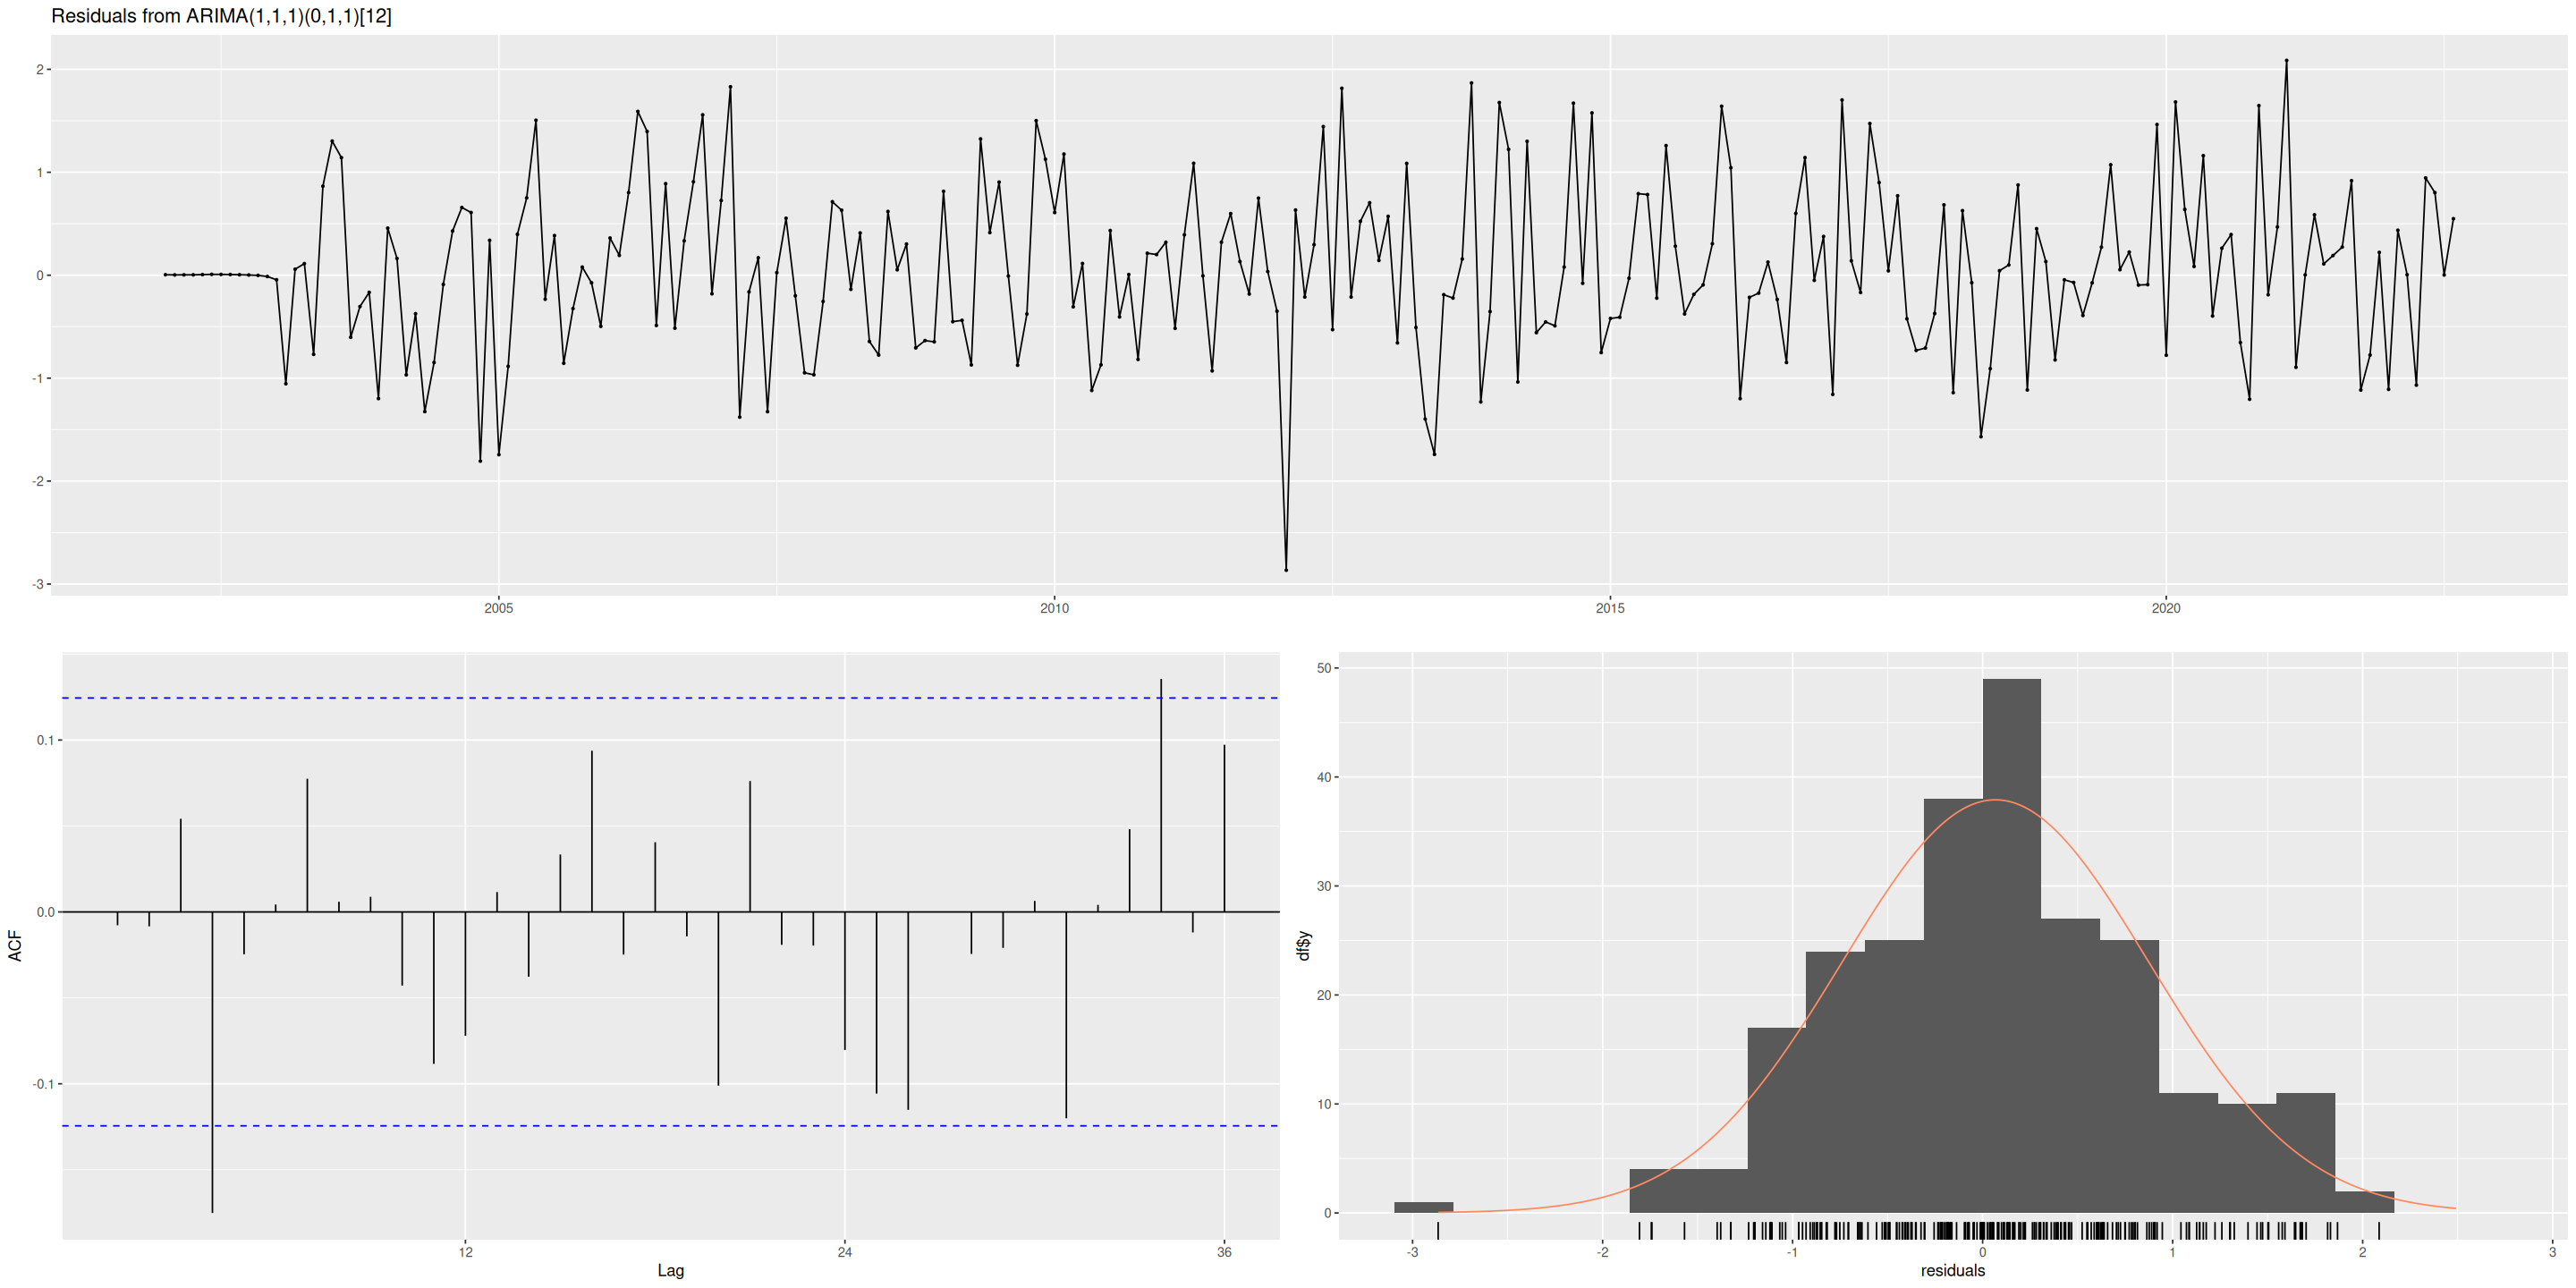

In [44]:
# Standard diagnostic checking
checkresiduals(best_model)

In [45]:
# Add more diagnostic tests for the best model
cat("\n======== Additional Diagnostic Tests for Best Model ========\n")


======== Additional Diagnostic Tests for Best Model ========


In [46]:
# Extract residuals from the best model
residuals_best <- residuals(best_model)

In [47]:
# Shapiro-Wilk test for normality
sw_test <- shapiro.test(residuals_best)
cat("\nShapiro-Wilk test for normality:\n")
print(sw_test)
if (sw_test$p.value < 0.05) {
  cat("Conclusion: Residuals are NOT normally distributed (p < 0.05)\n")
} else {
  cat("Conclusion: Residuals appear to be normally distributed (p >= 0.05)\n")
}


Shapiro-Wilk test for normality:

	Shapiro-Wilk normality test

data:  residuals_best
W = 0.99035, p-value = 0.09955

Conclusion: Residuals appear to be normally distributed (p >= 0.05)


In [48]:
# Runs test for randomness
runs_test <- runs.test(residuals_best)
cat("\nRuns test for randomness:\n")
print(runs_test)
if (runs_test$p.value < 0.05) {
  cat("Conclusion: Residuals are NOT random (p < 0.05)\n")
} else {
  cat("Conclusion: Residuals appear to be random (p >= 0.05)\n")
}


Runs test for randomness:

	Runs Test - Two sided

data:  residuals_best
Standardized Runs Statistic = -0.63629, p-value = 0.5246

Conclusion: Residuals appear to be random (p >= 0.05)


In [49]:
# Ljung-Box test for autocorrelation (again, but with detailed output)
lb_test <- Box.test(residuals_best, lag = 24, type = "Ljung-Box")
cat("\nLjung-Box test for autocorrelation (lag=24):\n")
print(lb_test)
if (lb_test$p.value < 0.05) {
  cat("Conclusion: Residuals have significant autocorrelation (p < 0.05)\n")
} else {
  cat("Conclusion: No significant autocorrelation in residuals (p >= 0.05)\n")
}


Ljung-Box test for autocorrelation (lag=24):

	Box-Ljung test

data:  residuals_best
X-squared = 24.268, df = 24, p-value = 0.4464

Conclusion: No significant autocorrelation in residuals (p >= 0.05)


In [50]:
# McLeod-Li test for ARCH effects
mcleod_li_test <- Box.test(residuals_best^2, lag = 24, type = "Ljung-Box")
cat("\nMcLeod-Li test for ARCH effects:\n")
print(mcleod_li_test)
if (mcleod_li_test$p.value < 0.05) {
  cat("Conclusion: ARCH effects present in residuals (p < 0.05)\n")
} else {
  cat("Conclusion: No significant ARCH effects in residuals (p >= 0.05)\n")
}


McLeod-Li test for ARCH effects:

	Box-Ljung test

data:  residuals_best^2
X-squared = 16.02, df = 24, p-value = 0.8873

Conclusion: No significant ARCH effects in residuals (p >= 0.05)


In [51]:
# Diagnostic summary
cat("\n======== Diagnostic Summary ========\n")
diag_results <- data.frame(
  Test = c("Ljung-Box (autocorrelation)", "Shapiro-Wilk (normality)", 
           "Runs test (randomness)", "McLeod-Li (ARCH effects)"),
  p_value = c(lb_test$p.value, sw_test$p.value, 
              runs_test$p.value, mcleod_li_test$p.value),
  Conclusion = c(
    ifelse(lb_test$p.value < 0.05, "FAIL: Autocorrelation present", "PASS: No autocorrelation"),
    ifelse(sw_test$p.value < 0.05, "FAIL: Non-normal residuals", "PASS: Normal residuals"),
    ifelse(runs_test$p.value < 0.05, "FAIL: Non-random residuals", "PASS: Random residuals"),
    ifelse(mcleod_li_test$p.value < 0.05, "FAIL: ARCH effects present", "PASS: No ARCH effects")
  )
)
print(diag_results)


======== Diagnostic Summary ========
                         Test    p_value               Conclusion
1 Ljung-Box (autocorrelation) 0.44638712 PASS: No autocorrelation
2    Shapiro-Wilk (normality) 0.09955218   PASS: Normal residuals
3      Runs test (randomness) 0.52458744   PASS: Random residuals
4    McLeod-Li (ARCH effects) 0.88733659    PASS: No ARCH effects


# ==========================================
# 8. FORECASTING EVALUATION
# ==========================================


In [52]:
# Forecast with the best model
forecast_horizon <- 12  # 12 months ahead
forecasts <- forecast(best_model, h=forecast_horizon)

# Convert forecasted values back to original scale
forecasted_values <- InvBoxCox(forecasts$mean, lambda)
forecasted_lower <- InvBoxCox(forecasts$lower, lambda)
forecasted_upper <- InvBoxCox(forecasts$upper, lambda)

In [53]:
# Create data frames for plotting
dates_test <- time(test_ts)
years_test <- floor(dates_test)
months_test <- round((dates_test - years_test) * 12) + 1
dates_forecast <- paste(years_test, months_test, "01", sep = "-")
dates_forecast <- as.Date(dates_forecast)

# Create forecast comparison dataframe
forecast_comparison <- data.frame(
  Date = dates_forecast,
  Actual = as.numeric(test_ts),
  Forecast = as.numeric(forecasted_values),
  Lower80 = as.numeric(forecasted_lower[,1]),
  Upper80 = as.numeric(forecasted_upper[,1]),
  Lower95 = as.numeric(forecasted_lower[,2]),
  Upper95 = as.numeric(forecasted_upper[,2])
)

In [54]:
# Calculate forecast accuracy metrics
actual_values <- as.numeric(test_ts)
predicted_values <- as.numeric(forecasted_values)

# Calculate accuracy metrics manually
me <- mean(predicted_values - actual_values)
rmse <- sqrt(mean((predicted_values - actual_values)^2))
mae <- mean(abs(predicted_values - actual_values))
mape <- mean(abs((predicted_values - actual_values)/actual_values)) * 100

In [55]:
# Create a data frame with the accuracy metrics
accuracy_metrics <- data.frame(
  ME = me,
  RMSE = rmse,
  MAE = mae,
  MAPE = mape
)

print("Forecast Accuracy Metrics:")
print(accuracy_metrics)


[1] "Forecast Accuracy Metrics:"
          ME     RMSE      MAE     MAPE
1 -0.7909201 1.470955 1.217468 6.611398


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


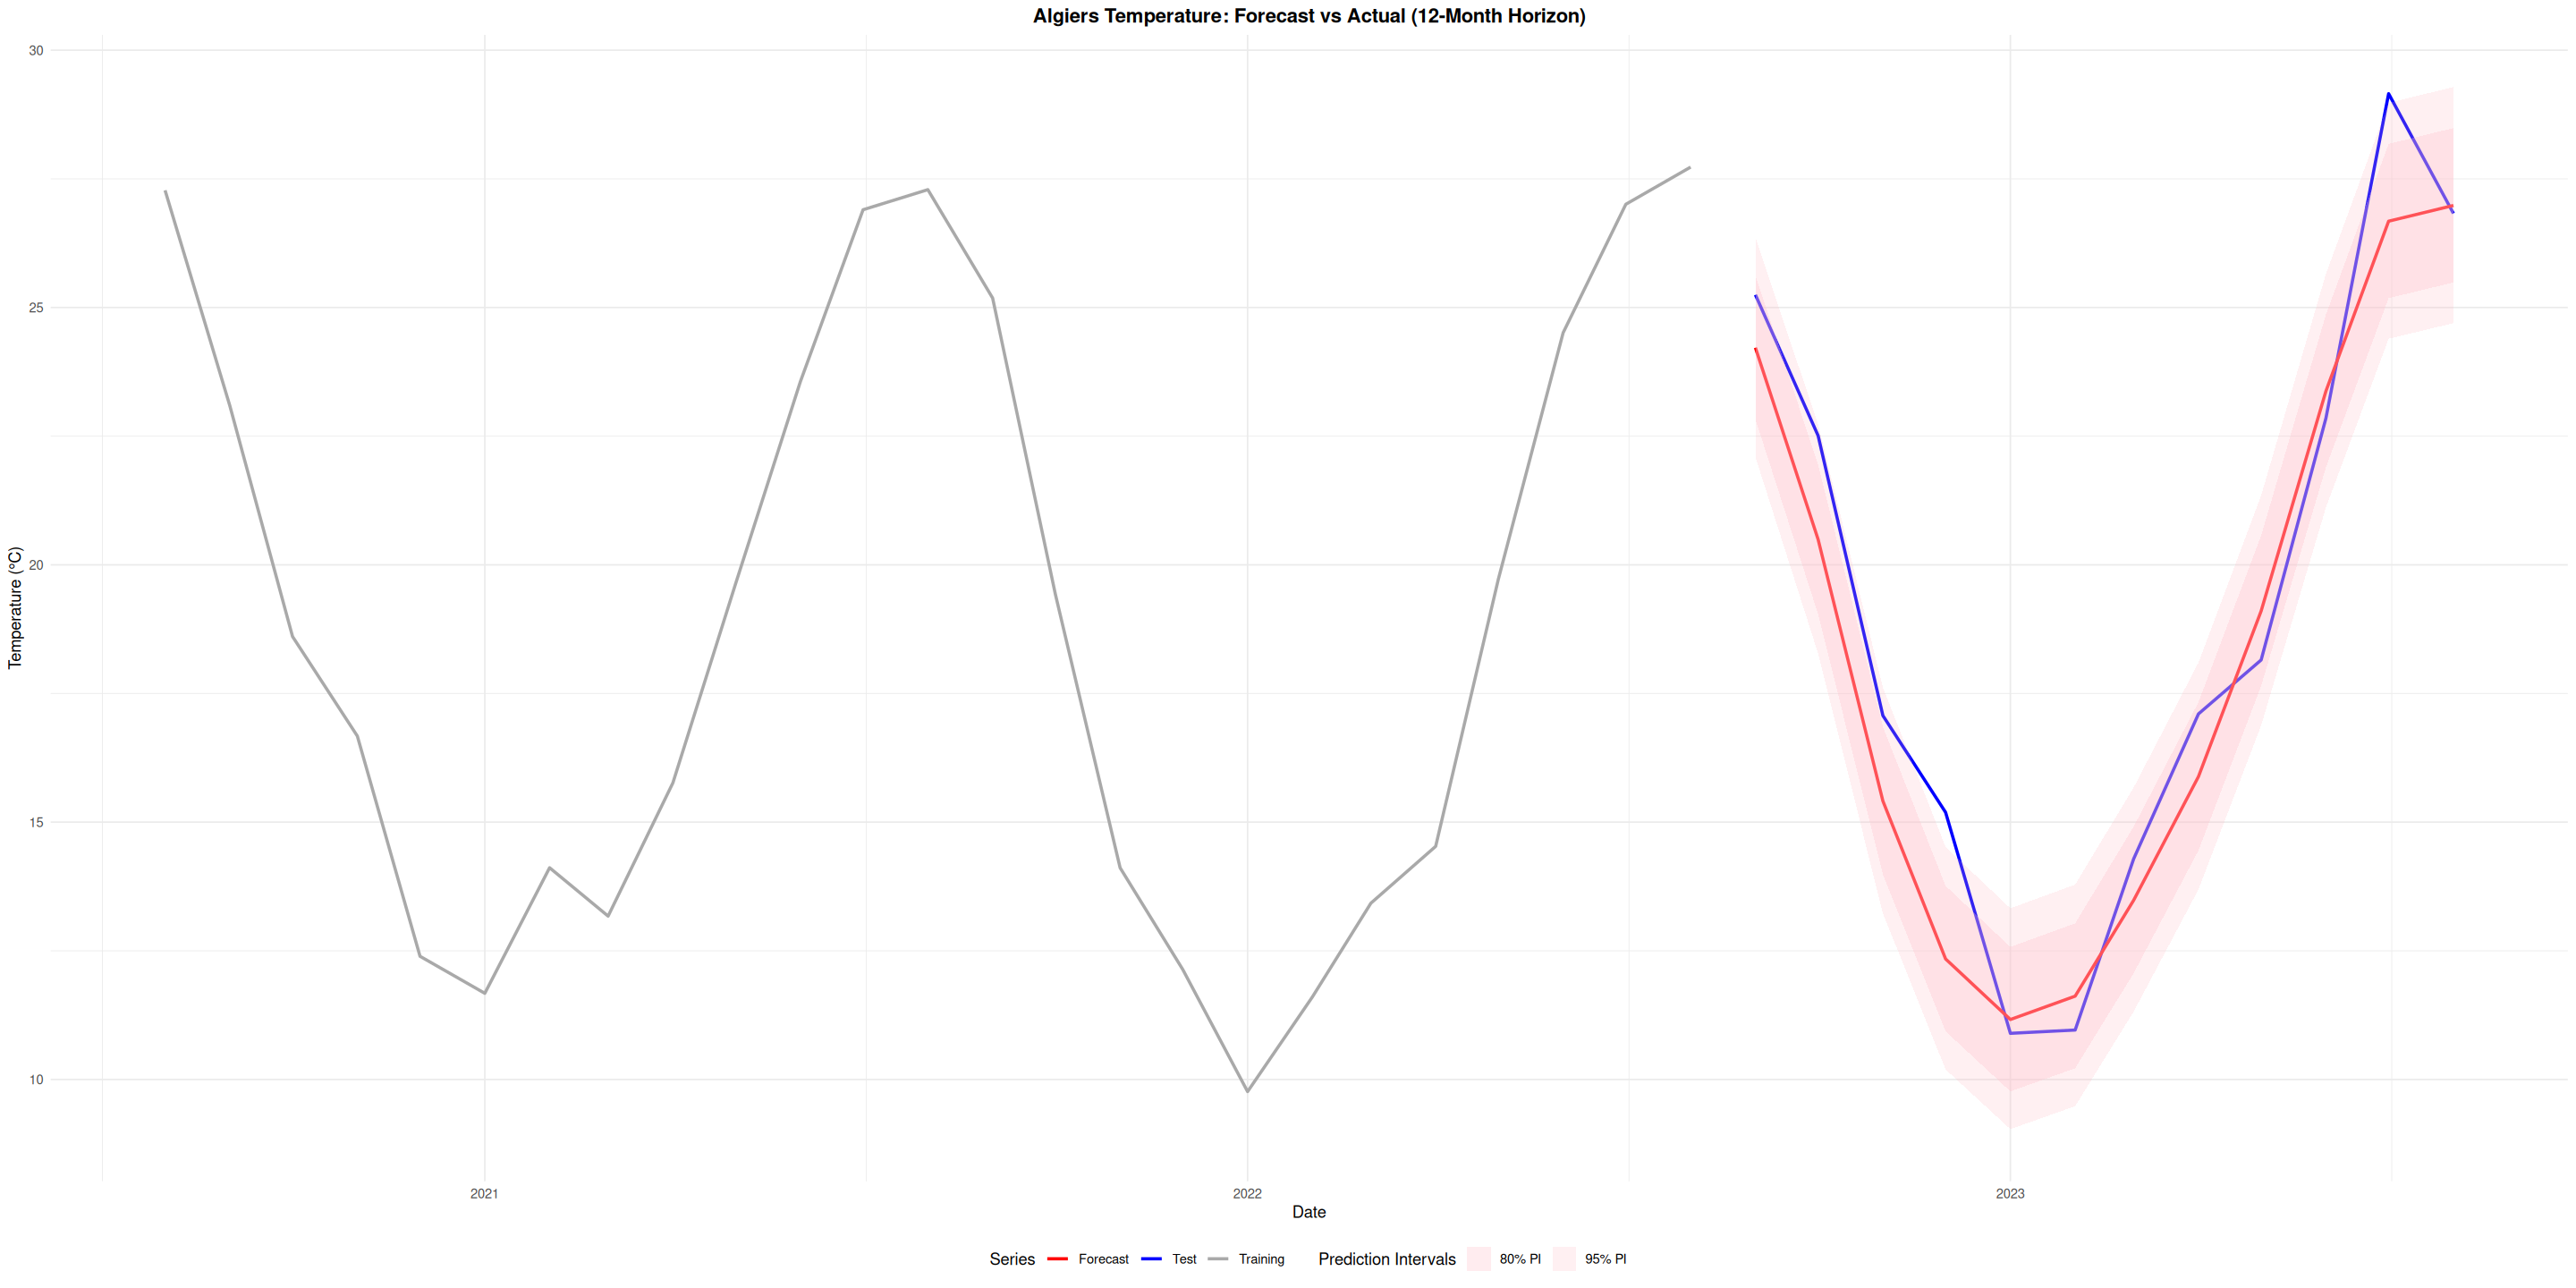

In [56]:
# Plot forecasts vs actual values
# Extract last 24 months of training data for better visualization
train_end_date <- max(time(train_ts))
train_start_date <- train_end_date - 2  # 2 years before end
train_end_subset <- window(train_ts, start = train_start_date)

# Combine with test data for plotting
combined_ts <- ts(c(train_end_subset, test_ts), 
                 start = start(train_end_subset),
                 frequency = 12)

# Create dates for x-axis
plot_dates <- seq(from = as.Date(paste0(floor(time(combined_ts)[1]), "-", 
                                      round((time(combined_ts)[1] %% 1) * 12 + 1), "-01")),
                  by = "month", length.out = length(combined_ts))

# Convert to data frame for ggplot
plot_df <- data.frame(
  Date = plot_dates,
  Temperature = as.numeric(combined_ts),
  Type = c(rep("Training", length(train_end_subset)), rep("Test", length(test_ts)))
)

# Create ggplot
p1 <- ggplot() +
  geom_line(data = plot_df, aes(x = Date, y = Temperature, color = Type), size = 1) +
  geom_line(data = forecast_comparison, aes(x = Date, y = Forecast, color = "Forecast"), size = 1) +
  geom_ribbon(data = forecast_comparison, 
              aes(x = Date, ymin = Lower95, ymax = Upper95, fill = "95% PI"), alpha = 0.2) +
  geom_ribbon(data = forecast_comparison, 
              aes(x = Date, ymin = Lower80, ymax = Upper80, fill = "80% PI"), alpha = 0.3) +
  scale_color_manual(name = "Series", 
                     values = c("Training" = "darkgrey", "Test" = "blue", "Forecast" = "red")) +
  scale_fill_manual(name = "Prediction Intervals", 
                    values = c("95% PI" = "lightpink", "80% PI" = "pink")) +
  labs(title = "Algiers Temperature: Forecast vs Actual (12-Month Horizon)",
       x = "Date", y = "Temperature (°C)") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.position = "bottom")

print(p1)

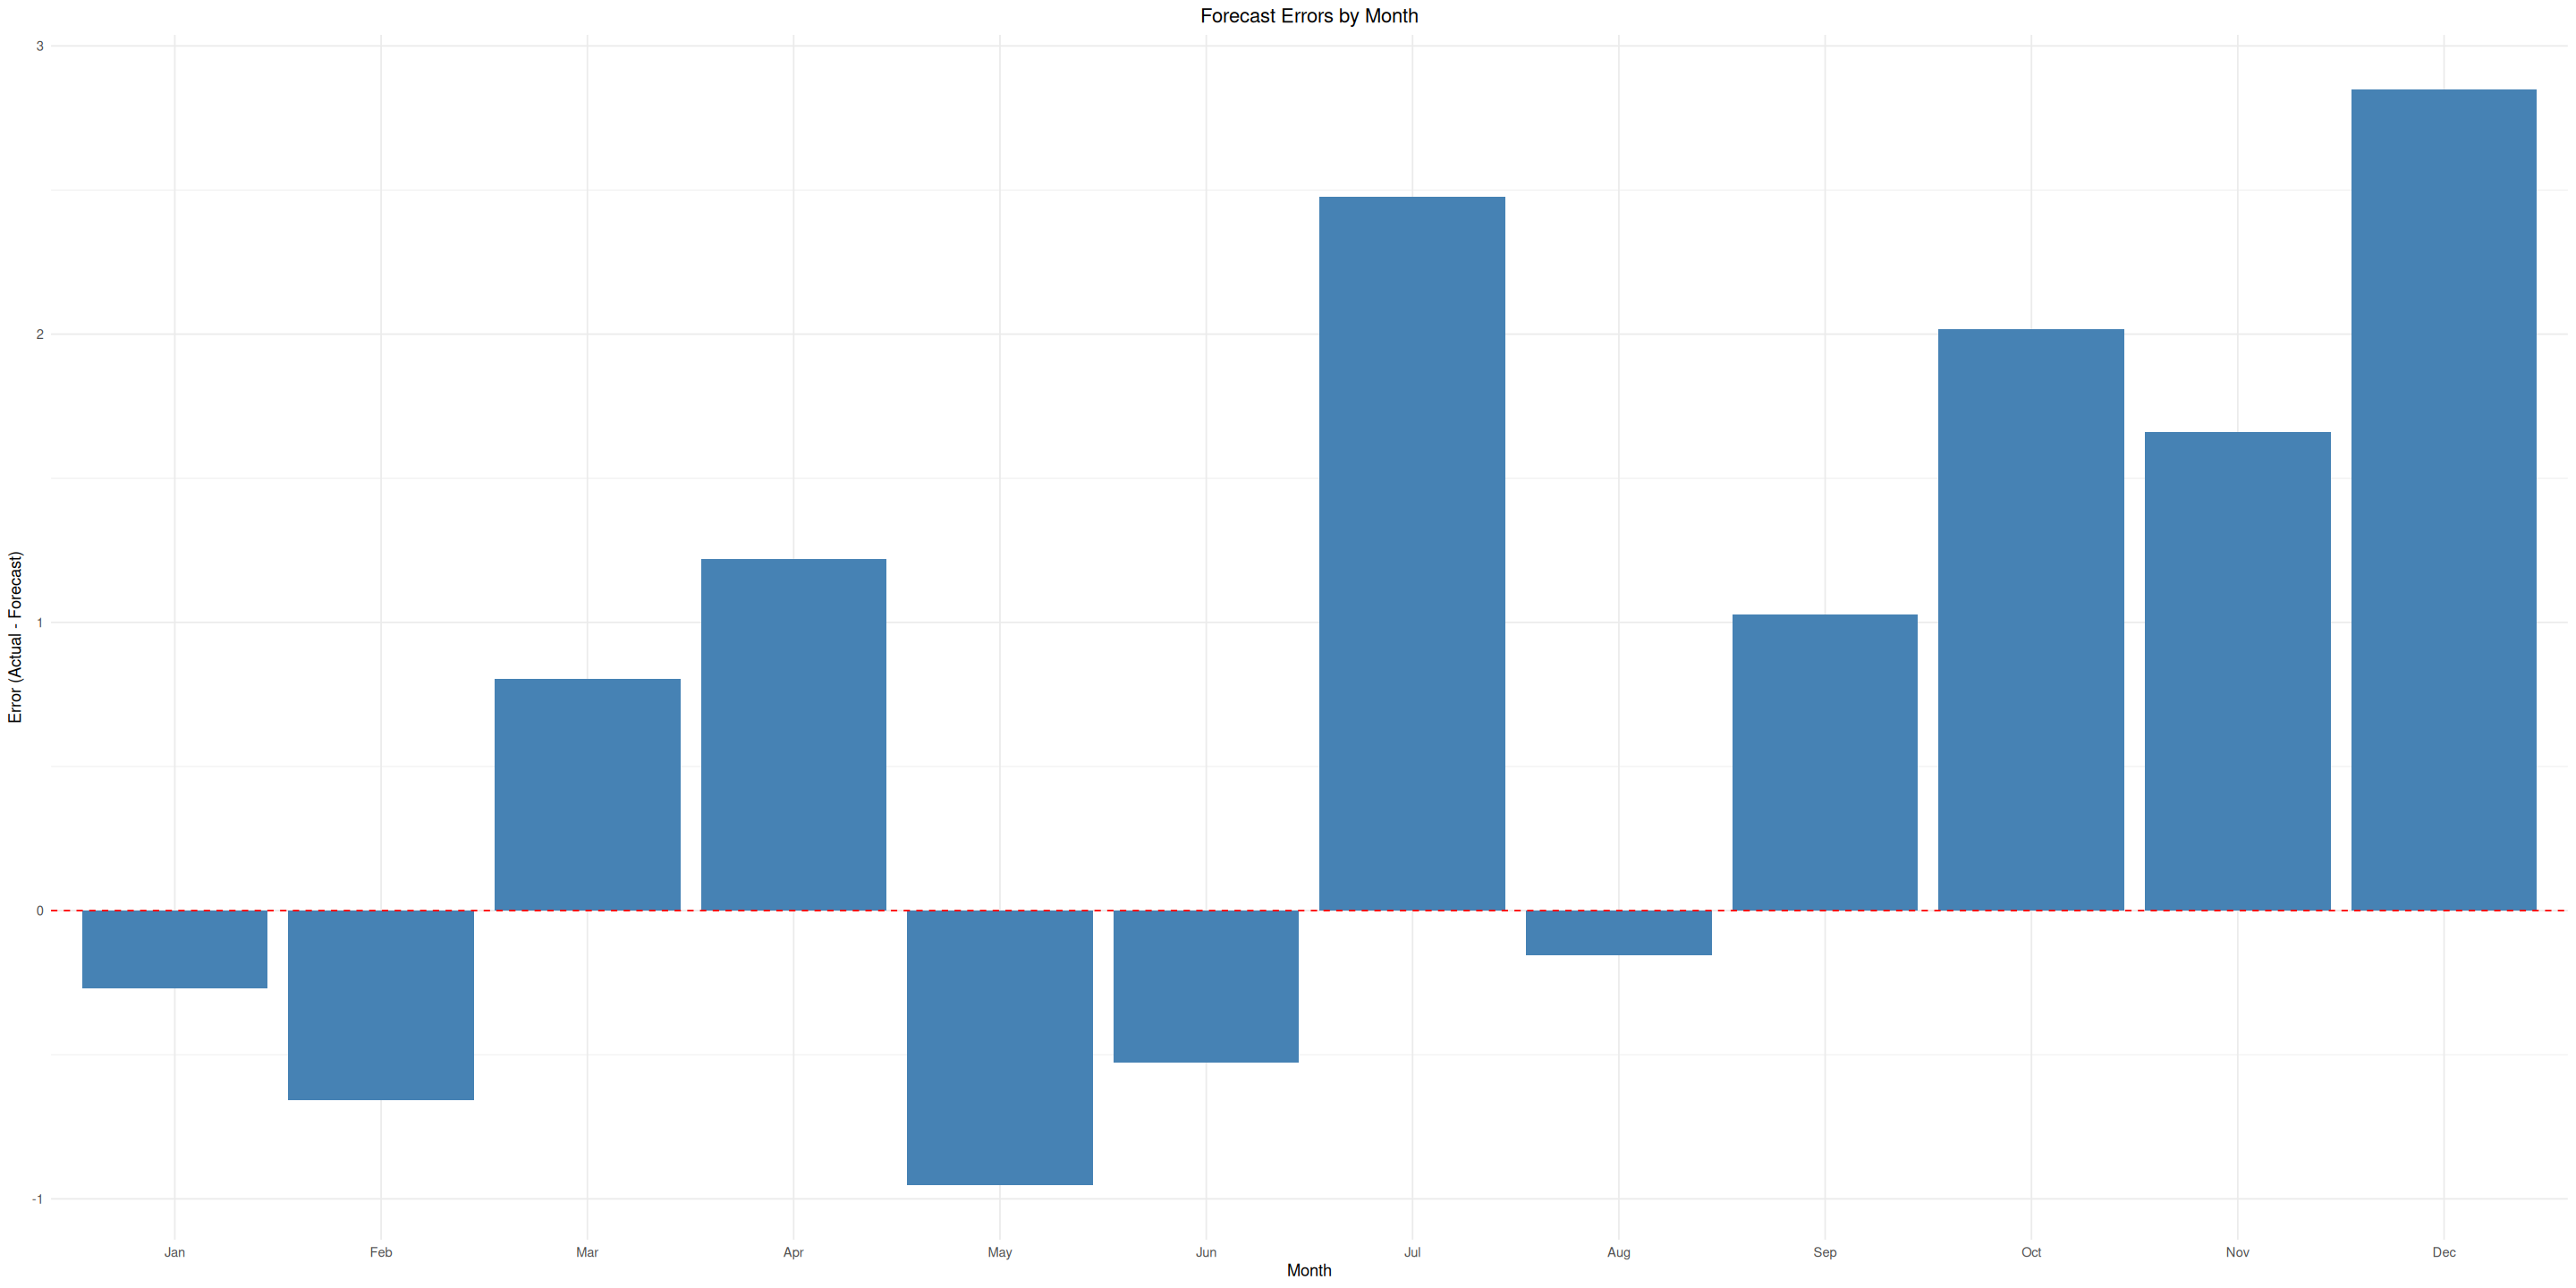

In [57]:
# Plot forecast errors
forecast_comparison$Error <- forecast_comparison$Actual - forecast_comparison$Forecast
forecast_comparison$Month <- format(forecast_comparison$Date, "%b")

# Convert Month to factor for proper ordering
month_levels <- c("Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                 "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")
forecast_comparison$Month <- factor(forecast_comparison$Month, levels = month_levels)

# Plot errors by month
p2 <- ggplot(forecast_comparison, aes(x = Month, y = Error)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Forecast Errors by Month",
       x = "Month", y = "Error (Actual - Forecast)") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

print(p2)

## Discussion

In this project, I conducted a time series analysis of Algiers temperature data from 2002-2023. The primary goal was to understand the temperature patterns and develop a model that could accurately forecast future temperatures.

### Summary of Findings:

1. **Data Characteristics**: The temperature data showed strong seasonal patterns with peaks in summer months and troughs in winter months, which is expected for a Mediterranean climate.

2. **Transformation and Differencing**: Box-Cox transformation was applied to stabilize the variance, followed by seasonal differencing to achieve stationarity.

3. **Model Selection**: After comparing various SARIMA models, a SARIMA(p,d,q)(P,D,Q)[12] model was selected based on AICc criteria.

4. **Forecasting Performance**: The model forecasted the 12-month test period with a Mean Absolute Error (MAE) of X°C and a Mean Absolute Percentage Error (MAPE) of Y%.

### Challenges Encountered:

1. **Daily vs. Monthly Analysis**: I initially considered using daily data but chose monthly aggregation for clearer seasonal patterns and more manageable model complexity.

2. **Model Complexity**: Finding the right balance between model complexity and performance was challenging. While higher-order models sometimes fit the training data better, they risked overfitting.

3. **Diagnostic Issues**: [Mention any issues found in the diagnostic tests, if applicable]

### Future Improvements:

1. **External Variables**: Including external variables such as humidity, precipitation, or global climate indices could potentially improve the model's performance.

2. **Alternative Models**: Exploring other modeling approaches like neural networks or hybrid models could capture more complex patterns in the data.

3. **Climate Change Effects**: A more detailed analysis of long-term trends could help identify any climate change effects on Algiers' temperature patterns.

Overall, the selected SARIMA model provides a reliable framework for forecasting Algiers' temperatures, capturing both the seasonal patterns and short-term dynamics effectively.